# Generate the UV Luminosity function from galaxy fluxes

In [1]:
%matplotlib inline
# %config InlineBackend.figure_format = 'retina'
import sys, os, glob, gc, re, linecache, subprocess
sys.path.append('/Volumes/GoogleDrive/My Drive/ASU/Codes/PythonCode/modules')
import numpy as np
from scipy.io import readsav
from scipy.stats import norm as normDist
from scipy.optimize import curve_fit
from scipy import optimize

import pandas as pd
import seaborn as sns

sns.set(style="whitegrid", font_scale=2, color_codes=True)
sns.set_style({'axes.edgecolor': '0.0','axes.linewidth': 2.0})

from astropy.cosmology import FlatLambdaCDM
from astropy import units as u
import astropy 

import matplotlib.mlab as mlab
import matplotlib.pylab as pylab
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt 
from matplotlib.ticker import FuncFormatter
from matplotlib.ticker import NullFormatter
import matplotlib as mpl
import copy as copy

import loadfilt as lf
import igm as lyA
import buildFluxTables as bft
import loadSP as lsp

pylab.rcParams['figure.figsize'] = (10,8)

mpl.rcParams['font.size'] = 24
mpl.rcParams['legend.fontsize'] = 'large'
#mpl.rcParams['figure.titlesize'] = 'medium'


pylab.rcParams.update({'font.size': 22, 'font.family': 'STIXGeneral', 'mathtext.fontset': 'stix'})
#pylab.rcParams.update({'font.size': 20, 'text.usetex': False})

print("Python version:\n{}\n".format(sys.version))
print("matplotlib version: {}".format(mpl.__version__))
print("pandas version: {}".format(pd.__version__))
print("numpy version: {}".format(np.__version__))

Python version:
3.5.2 |Anaconda custom (x86_64)| (default, Jul  2 2016, 17:52:12) 
[GCC 4.2.1 Compatible Apple LLVM 4.2 (clang-425.0.28)]

matplotlib version: 2.2.2
pandas version: 0.22.0
numpy version: 1.14.2


In [2]:
def log_formatter(x,pos):
    return format(np.log10(x), '.0f')
logfmt  = FuncFormatter(log_formatter)

def log_GHzFormatter(x,pos):
    return format(np.log10(x)-9.0, '.0f')
logGHzfmt  = FuncFormatter(log_GHzFormatter)

def GHzFormatter(x,pos):
    return format(x/1e9, '.2e')
GHzfmt  = FuncFormatter(GHzFormatter)

def mic_formatter(x,pos):
    return format(x/10000., '.1f')
micfmt  = FuncFormatter(mic_formatter)

nullfmt = NullFormatter()
labelsize = 24

In [3]:
# Setup the cosmology used in the runs
# This provides comoving distance, lumin distance, etc... 
cosmo = FlatLambdaCDM(H0=71, Om0=0.267, Ob0=0.0449,name='myCosmo')

In [4]:
cosmo.age([16,15,12,11,9,8.6])

<Quantity [0.25347056, 0.27759578, 0.37899712, 0.4273213 , 0.56162034,
           0.59704923] Gyr>

In [5]:
cosmo.age([8.6])-cosmo.age([12])

<Quantity [0.21805212] Gyr>

# Load data... 

In [6]:
haloData={}

fluxes = {15: np.genfromtxt('./p3SN/haloFluxes_UV_z_15.0.txt', delimiter=',',names=True),
         12: np.genfromtxt('./p3SN/haloFluxes_UV_z_12.0.txt', delimiter=',',names=True),
         10: np.genfromtxt('./p3SN/haloFluxes_UV_z_10.0.txt', delimiter=',',names=True),
         9: np.genfromtxt('./p3SN/haloFluxes_UV_z_9.0.txt', delimiter=',',names=True),
         8: np.genfromtxt('./p3SN/haloFluxes_UV_z_8.0.txt', delimiter=',',names=True),
         7: np.genfromtxt('./p3SN/haloFluxes_UV_z_7.0.txt', delimiter=',',names=True)}
haloData['P3SN'] = fluxes

fluxes = {15: np.genfromtxt('./fid/haloFluxes_UV_z_15.0_salP3.txt', delimiter=',',names=True),
         12: np.genfromtxt('./fid/haloFluxes_UV_z_12.0_salP3.txt', delimiter=',',names=True),
         10: np.genfromtxt('./fid/haloFluxes_UV_z_10.0_salP3.txt', delimiter=',',names=True),
         9: np.genfromtxt('./fid/haloFluxes_UV_z_9.0_salP3.txt', delimiter=',',names=True),
         8: np.genfromtxt('./fid/haloFluxes_UV_z_8.0_salP3.txt', delimiter=',',names=True),
         7: np.genfromtxt('./fid/haloFluxes_UV_z_7.0_salP3.txt', delimiter=',',names=True)}
haloData['Fid_Sal'] = fluxes

fluxes = {15: np.genfromtxt('./fw1/haloFluxes_UV_z_15.0_salP3.txt', delimiter=',',names=True),
         12: np.genfromtxt('./fw1/haloFluxes_UV_z_12.0_salP3.txt', delimiter=',',names=True),
         10: np.genfromtxt('./fw1/haloFluxes_UV_z_10.0_salP3.txt', delimiter=',',names=True),
         9: np.genfromtxt('./fw1/haloFluxes_UV_z_9.0_salP3.txt', delimiter=',',names=True),
         8: np.genfromtxt('./fw1/haloFluxes_UV_z_8.0_salP3.txt', delimiter=',',names=True),
         7: np.genfromtxt('./fw1/haloFluxes_UV_z_7.0_salP3.txt', delimiter=',',names=True)}
haloData['fw1'] = fluxes

fluxes = {15: np.genfromtxt('./Z-4/haloFluxes_UV_z_15.0_salP3.txt', delimiter=',',names=True),
         12: np.genfromtxt('./Z-4/haloFluxes_UV_z_12.0_salP3.txt', delimiter=',',names=True),
         10: np.genfromtxt('./Z-4/haloFluxes_UV_z_10.0_salP3.txt', delimiter=',',names=True),
         9: np.genfromtxt('./Z-4/haloFluxes_UV_z_9.0_salP3.txt', delimiter=',',names=True),
         8: np.genfromtxt('./Z-4/haloFluxes_UV_z_8.0_salP3.txt', delimiter=',',names=True),
         7: np.genfromtxt('./Z-4/haloFluxes_UV_z_7.0_salP3.txt', delimiter=',',names=True)}
haloData['Z4'] = fluxes

fluxes = {15: np.genfromtxt('./Z-6/haloFluxes_UV_z_15.0_salP3.txt', delimiter=',',names=True),
         12: np.genfromtxt('./Z-6/haloFluxes_UV_z_12.0_salP3.txt', delimiter=',',names=True),
         10: np.genfromtxt('./Z-6/haloFluxes_UV_z_10.0_salP3.txt', delimiter=',',names=True),
         9: np.genfromtxt('./Z-6/haloFluxes_UV_z_9.0_salP3.txt', delimiter=',',names=True),
         8: np.genfromtxt('./Z-6/haloFluxes_UV_z_8.0_salP3.txt', delimiter=',',names=True),
         7: np.genfromtxt('./Z-6/haloFluxes_UV_z_7.0_salP3.txt', delimiter=',',names=True)}
haloData['Z6'] = fluxes

fluxes = {15: np.genfromtxt('./fid/haloFluxes_UV_z_15.0.txt', delimiter=',',names=True),
         12: np.genfromtxt('./fid/haloFluxes_UV_z_12.0.txt', delimiter=',',names=True),
         10: np.genfromtxt('./fid/haloFluxes_UV_z_10.0.txt', delimiter=',',names=True),
         9: np.genfromtxt('./fid/haloFluxes_UV_z_9.0.txt', delimiter=',',names=True),
         8: np.genfromtxt('./fid/haloFluxes_UV_z_8.0.txt', delimiter=',',names=True),
         7: np.genfromtxt('./fid/haloFluxes_UV_z_7.0.txt', delimiter=',',names=True)}
haloData['Fid_Orig'] = fluxes


thezs = [15,12,10,9,8,7]
# haloData={}
# runs = ['P3SN','Fiducial']
# for name, rootPath in zip(runs, ['./p3SN/','./fid/']):
#     filePat = 'haloFluxes_UV_z_[0-9]*.[05].txt' 
#     files   = glob.glob(rootPath+filePat)  
#     fileListz = []
#     for file in files:
#         start = file.index('z_') + 2
#         end = len(file) - 4
#         fileListz.append(file[start:end])
#     fluxes = {float(filez):  np.genfromtxt(file, delimiter=',',names=True) for filez,file in zip(fileListz,files)}
#     haloData[name] = fluxes
#     print(name, fileListz)
    
# for z in sorted(fileListz,reverse=True):
#     print("Number of halos for z={} is {}".format(z,len(fluxes[float(z)]['halo'])) )
# thezs= [float(i) for i in fileListz]
print(thezs)
runs = list(haloData.keys())
print(runs)
print("p3sn", len(haloData['P3SN'][7]))
print("fid", len(haloData['Fid_Sal'][7]))
print("fid orig", len(haloData['Fid_Orig'][7]))

[15, 12, 10, 9, 8, 7]
['Z6', 'Z4', 'Fid_Orig', 'P3SN', 'Fid_Sal', 'fw1']
p3sn 9240
fid 8248
fid orig 8248


In [7]:
# Load the raw halos that have DM masses ... these are not used directly for the LM compuation
# since they haven't been processed by finalizeDenPro2.py where we look for observationally 
# distinguishable galaxies. However, we can get a DM mass for a given stellar mass using these
# galaxies... 

dmMasses={}
runs = ['P3SN','Fid_Sal','Fid_Orig','fw1','Z4','Z6']
for name, rootPath in zip(runs, ['./p3SN/','./fid/','./fid/','./fw1/','./Z-4/','./Z-6/']):
    filePat = 'stellar_DM_masses_z_[0-9]*.[05].txt' 
    files   = glob.glob(rootPath+filePat)  
    fileListz = []
    for file in files:
        start = file.index('z_') + 2
        end = len(file) - 4
        fileListz.append(file[start:end])
    # We now have all the z's for the halo files
    massFiles = {float(filez):  np.genfromtxt(file, delimiter=',',names=True) for filez,file in zip(fileListz,files)}
    dmMasses[name] = massFiles
    print(name, fileListz)
    
# dmMasses has flux and DM Mass info for all of the RAW halos... 
# We'll use these to find DM masses based on Stellar mass

P3SN ['10.0', '11.0', '12.0', '13.0', '14.0', '15.0', '16.0', '7.0', '8.0', '9.0']
Fid_Sal ['10.0', '11.0', '12.0', '13.0', '14.0', '15.0', '16.0', '7.0', '8.0', '9.0']
Fid_Orig ['10.0', '11.0', '12.0', '13.0', '14.0', '15.0', '16.0', '7.0', '8.0', '9.0']
fw1 ['10.0', '11.0', '12.0', '13.0', '14.0', '15.0', '16.0', '7.0', '8.0', '9.0']
Z4 ['10.0', '11.0', '12.0', '13.0', '14.0', '15.0', '16.0', '7.0', '8.0', '9.0']
Z6 ['10.0', '11.0', '12.0', '13.0', '14.0', '15.0', '16.0', '7.0', '8.0', '9.0']


In [8]:
list(haloData.keys())

['Z6', 'Z4', 'Fid_Orig', 'P3SN', 'Fid_Sal', 'fw1']

In [9]:
for z in thezs:
    print("{} {:.2e} {:.2e}".format(z, dmMasses['P3SN'][z]['M_DMMsun'].min(),dmMasses['P3SN'][z]['M_DMMsun'].max()))
    print("{} {:.2e} {:.2e}".format(z, dmMasses['P3SN'][z]['MstarMsun'].min(),dmMasses['P3SN'][z]['MstarMsun'].max()))

15 5.46e+07 9.68e+08
15 8.60e+01 2.38e+06
12 6.42e+07 5.34e+09
12 8.60e+01 1.15e+07
10 8.54e+07 1.87e+10
10 8.60e+01 2.32e+08
9 8.32e+07 2.91e+10
9 8.60e+01 4.64e+08
8 4.60e+07 3.26e+10
8 8.60e+01 9.74e+08
7 3.13e+07 4.27e+10
7 8.60e+01 1.77e+09


In [10]:
# Find the DM halo mass the maps to the stellar mass... 
eps = 1e4
lin_scale_fac = {15: 230., 12: 200, 10: 85, 9: 80, 8: 50,7: 35}
def findDMMass(dir,z,M,dmm):
    cond = ((dmm[dir][z]['MstarMsun'] < M + eps) & 
            (dmm[dir][z]['MstarMsun'] > M - eps))
    vals = dmm[dir][z]['M_DMMsun'][cond]
    if vals.size==0:
        vals = np.array([M * lin_scale_fac[z]]) # Estimate if we don't have dm mass in the range requested
    return vals.mean()

findDMMass_v = np.vectorize(findDMMass)

In [11]:
for dir in runs:
    for z in thezs:
        cooefs = np.polyfit(dmMasses[dir][z]['MstarMsun'],dmMasses[dir][z]['M_DMMsun'],1) # returns highest power first
        print(z, cooefs)

15 [4.68770517e+02 2.22183747e+08]
12 [4.11053927e+02 3.50782351e+08]
10 [9.58213826e+01 6.27867758e+08]
9 [7.77780942e+01 5.64031336e+08]
8 [5.10684676e+01 4.63823845e+08]
7 [3.54621673e+01 6.11586784e+08]
15 [2.49387996e+02 2.16389721e+08]
12 [2.26828027e+02 3.04488942e+08]
10 [8.64486961e+01 5.36536390e+08]
9 [7.83290324e+01 5.03808749e+08]
8 [4.81852745e+01 4.11479364e+08]
7 [3.54973507e+01 5.61604428e+08]
15 [2.49387996e+02 2.16389721e+08]
12 [2.26828027e+02 3.04488942e+08]
10 [8.64486961e+01 5.36536390e+08]
9 [7.83290324e+01 5.03808749e+08]
8 [4.81852745e+01 4.11479364e+08]
7 [3.54973507e+01 5.61604428e+08]
15 [2.26841970e+02 2.19927062e+08]
12 [2.16036346e+02 2.96748325e+08]
10 [8.52140114e+01 5.32948344e+08]
9 [7.06968639e+01 4.99979322e+08]
8 [4.44037038e+01 4.08521504e+08]
7 [3.30104754e+01 5.59654129e+08]
15 [2.58772779e+02 2.14724424e+08]
12 [2.27899927e+02 3.01667054e+08]
10 [8.66622033e+01 5.39546839e+08]
9 [8.54333901e+01 4.93943088e+08]
8 [4.93500053e+01 4.07152230e+08]

In [12]:
simVol = (12.0/0.71)**3

In [13]:
#
# Convert flux into magnitude, no extinction...
#
ABref = 48.6
def mag(flux):
    """Convert flux into magnitude, no extinction"""
    return -2.5 * np.log10(flux) - ABref # (1+z) there since I forgot it in flux computation.

def compMags(dir,z):
    """Convert observed magnitude to Absolute"""
    # See notebook for calculation: D = m_ab - M_ab
    cDM = 2.5*np.log10((1.0+z)**-1*(cosmo.luminosity_distance(z).to(u.pc)/(10.0 * u.pc))**2) 

    print("Convert to Abs Mag. DM = {:.2f} @ z={:.1f}".format(cDM,z))
    absMag   = mag(haloData[dir][z]['1500A'])-cDM
    pop3Mag  = mag(haloData[dir][z]['1500A_P3'])-cDM
    nmAbsMag = mag(haloData[dir][z]['1500A_NM'])-cDM
    return absMag, pop3Mag,nmAbsMag


def getMag(Mags,z):
    """Convert Absolute magnitude to observational at z"""
    cDM = 2.5*np.log10((1.0+z)**-1*(cosmo.luminosity_distance(z).to(u.pc)/(10.0 * u.pc))**2) 
    return Mags + cDM


def getHaloMasses(dir,z):
    return haloData[dir][z]['MstarMsun']

def getHaloP3Masses(dir,z):
    return haloData[dir][z]['M3StarMsun']

def getHaloRadii(dir,z):
    return haloData[dir][z]['r_v']

In [14]:
# Compute sigma(scale,z)
# sigma of a sphere with radius <size>
# ** Assumes units are Mpc **
def sigma_sphere(size,z):
    tmp = str(subprocess.run(['/Users/earnric/bin/pp -om 0.267 -ob 0.0449 -flat -h 0.71 -n 0.96 -z %f -scale %f'%
                              (z,size)], shell=True,stdout=subprocess.PIPE))
    sigma = float(re.split(r'(rms tophat fluctuations are|\\n)',tmp)[-3])
    return sigma

# Compute sigma(M,z) - sigma of a peak of mass M at z
# sig^2(M,z) = sig^2(M,z=0)*D(z)^2/D(z=0)^2
# masses is an array of galaxy DM masses all at redshift z
# ** Masses are in solar **
def sigma_mass(masses,z):
    sigma2Mz = np.empty(0)
    for M in masses:
#             print("mass m=",M)
            tmp = str(subprocess.run(
                    ['/Users/earnric/bin/pp -om 0.267 -ob 0.0449 -flat -h 0.71 -n 0.96 -z %f -mass %f'%(z,M)],
                    shell=True,stdout=subprocess.PIPE))
            sigmaMz = float(re.split(r'(rms tophat fluctuations are|\\n)',tmp)[-3])
            sigma2Mz = np.append(sigma2Mz, sigmaMz**2) 
        
    return np.sqrt(sigma2Mz)

In [15]:
# ** Find error due to cosmic var IN EACH BINS **
# Compute sigma_nu for galaxies (masses) that make up each
# Magnitude bin ... use that sigma_nu with count of galaxies
# in that bin to compute error

def sigma_nu(dir,z,absMag,bins):
    sigma_nu_for_bins = np.empty(0)
    for i in bins:
        mag_bin  = [i,i+1]
        # We only have stellar mass for galaxies (that have flux values). We'll look up the corresponding
        # DM mass... 
        masses = haloData[dir][z]['MstarMsun'][(absMag >= mag_bin[0]) & (absMag < mag_bin[1])]
#         print("sigma_nu: bin, masses ",  mag_bin, masses)
        if masses.size == 0:
#             print("sigma_nu: No masses in bin ", mag_bin)
            sigma_nu_for_bins = np.append(sigma_nu_for_bins,0.0)
        else:
#             print("sigma_nu: masses.size, masses, bin bounds",masses.size, masses[0][:10],  mag_bin)
            galaxies_masses_in_bin = findDMMass_v(dir,z, masses, dmMasses)  # to DM. For some reason, masses is '[[]]
#             print("Num of galaxies= {} in bin ".format(len(galaxies_masses_in_bin)), mag_bin)
            sigma_Mz = sigma_mass(galaxies_masses_in_bin,z) # sigma of mass-peak at z
            nu = 1.69/sigma_Mz / 1.0 # The 0.95 corrects for our under-estimation of DM tied up in halos (at z=9)
#           print("nu",nu.mean())
            b  = 1 + (nu**2-1)/1.69
            sigma_nu_for_bins = np.append(sigma_nu_for_bins, sigma_sphere(7.4,z) * b.mean())
#             sigma_nu_for_bins = np.append(sigma_nu_for_bins, np.sqrt(sigma_sphere(7.4,z)**2 * (b**2).sum()))
            # replaced sqrt b^2 sum with an average b value... 

    return sigma_nu_for_bins

In [16]:
# Schechter values from Finkelstein, 2016
# Phi*, alpha, M*
# z=10 is based only on 4 datapoints... !!!!
finkel = {
    5: [10**-3.18,-1.8,-20.92],
    6: [10**-3.37,-1.91,-20.79],
    7: [10**-3.56,-2.02,-20.66],
    8: [10**-3.75,-2.13,-20.52],
    9: [10**-3.94,-2.24,-20.39],
    10:[10**-4.13,-2.35,-20.25], # Weak constraints on this ... 
    11:[10**-4.29,-2.47,-20.11], # Extrapolated from here
    12:[10**-4.49,-2.58,-19.98],
    13:[10**-4.69,-2.69,-19.84],
    14:[10**-4.89,-2.81,-19.71],
    15:[10**-5.08,-2.92,-19.57],
    16:[10**-5.28,-3.03,-19.44]
}

finkel10Bounds = {
    'low':[10**-4.07,-2.31,-20.19],
    'up':[10**-4.21,-2.41,-20.32]

}

# From Finkel+16
def finkelAlphaEvolution(x):
    return -1.22928 - 0.112557 * x

bouwens15 =np.loadtxt("../12Mpc-n1.0-eps01-fek1-del200-rb300-newICs/Bouwens15-errs.txt",skiprows=1)
oesch13   =np.loadtxt("../12Mpc-n1.0-eps01-fek1-del200-rb300-newICs/Oesch13-Errs.txt",skiprows=1)

In [17]:
# phiStar=1.46e-2, MStar=-20.79, alpha=-1.2 from Finkelstein
# From mathematica fit for z=10 data - Use to check this fit... 
# \[Phi]star -> 0.16573, \[Alpha] -> -1.18934, Mstar -> -17.1986
def schechterM_forFit(params, magnitude):
    """Schechter luminosity function by magnitudes."""
    phiStar = params[0]
    alpha   = params[1]
    MStar   = params[2]
    MStarMinM = 0.4 * (MStar - magnitude)
    return (0.4 * np.log(10) * phiStar *
            10.0**(MStarMinM * (alpha + 1.)) * np.exp(-10.**MStarMinM))


# phiStar=1.46e-2, MStar=-20.79, alpha=-1.2 from Finkelstein
# From mathematica fit for z=10 data - Use to check this fit... 
# \[Phi]star -> 0.16573, \[Alpha] -> -1.18934, Mstar -> -17.1986
def pwrLaw_forFit(params, magnitude):
    """Schechter luminosity function by magnitudes."""
    phiStar = params[0]
    alpha   = params[1]
    MStar   = params[2]
    MStarMinM = 0.4 * (MStar - magnitude)
    return (phiStar * 10.0**((0.4 * (MStar - magnitude)) * (alpha + 1.)))

In [18]:
bouwens=np.loadtxt("../12Mpc-n1.0-eps01-fek1-del200-rb300-newICs/Bouwensz12LF.txt",skiprows=1)
OShea12=np.loadtxt("../12Mpc-n1.0-eps01-fek1-del200-rb300-newICs/OShea-z12.txt",skiprows=1)
OShea14=np.loadtxt("../12Mpc-n1.0-eps01-fek1-del200-rb300-newICs/OShea-z14.txt",skiprows=1)
OShea15=np.loadtxt("../12Mpc-n1.0-eps01-fek1-del200-rb300-newICs/OShea-z15.txt",skiprows=1)
OShea16=np.loadtxt("../12Mpc-n1.0-eps01-fek1-del200-rb300-newICs/OShea-z16.txt",skiprows=1)
OShea = {
    12: OShea12,
    14: OShea14,
    15: OShea15,
    16: OShea16
}

In [19]:
# This converts a error (dx) in log space (so log of the error in x)
# into a error away from the central data point 
def logErrFix(dp, dx):
    return np.abs((10**dx-1.0)*dp)

# The following is a more logical way to plot the data

We really can't see M*, so a power law fit makes more sense.

In [20]:
dmMasses['P3SN'][15].dtype

dtype([('halo', '<f8'), ('r_v', '<f8'), ('MstarMsun', '<f8'), ('M_DMMsun', '<f8')])

In [21]:
runs

['P3SN', 'Fid_Sal', 'Fid_Orig', 'fw1', 'Z4', 'Z6']

Convert to Abs Mag. DM = 46.99 @ z=7.0
7 [   1    2    8   39   86  215  576 1222 2020]
Working: Fid_Orig 7 [-22. -21. -20. -19. -18. -17. -16. -15. -14.]


/Users/earnric/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log10
  import sys


Convert to Abs Mag. DM = 47.20 @ z=8.0
8 [   0    2    5   18   59  164  497 1140 1938]
Working: Fid_Orig 8 [-22. -21. -20. -19. -18. -17. -16. -15. -14.]


/Users/earnric/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:68: RuntimeWarning: divide by zero encountered in true_divide
/Users/earnric/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in multiply
/Users/earnric/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: invalid value encountered in less_equal


Convert to Abs Mag. DM = 47.38 @ z=9.0
9 [  0   1   0  14  44 138 443 802 435]
Working: Fid_Orig 9 [-22. -21. -20. -19. -18. -17. -16. -15. -14.]
Convert to Abs Mag. DM = 47.54 @ z=10.0
10 [  0   0   1   2  12  41 120 255 366]
Working: Fid_Orig 10 [-22. -21. -20. -19. -18. -17. -16. -15. -14.]
Convert to Abs Mag. DM = 47.81 @ z=12.0
12 [  0   0   0   0   1  10  41  99 172]
Working: Fid_Orig 12 [-22. -21. -20. -19. -18. -17. -16. -15. -14.]
Convert to Abs Mag. DM = 48.13 @ z=15.0
15 [ 0  0  0  0  0  0  3 14 31]
Working: Fid_Orig 15 [-22. -21. -20. -19. -18. -17. -16. -15. -14.]
Convert to Abs Mag. DM = 46.99 @ z=7.0
7 [   1    2    8   39   86  215  566 1222 2041]
Working: Fid_Sal 7 [-22. -21. -20. -19. -18. -17. -16. -15. -14.]
Convert to Abs Mag. DM = 47.20 @ z=8.0
8 [   0    2    5   18   59  164  498 1139 1990]
Working: Fid_Sal 8 [-22. -21. -20. -19. -18. -17. -16. -15. -14.]
Convert to Abs Mag. DM = 47.38 @ z=9.0
9 [  0   1   0  14  39 105 280 517 593]
Working: Fid_Sal 9 [-22. -21.

8672

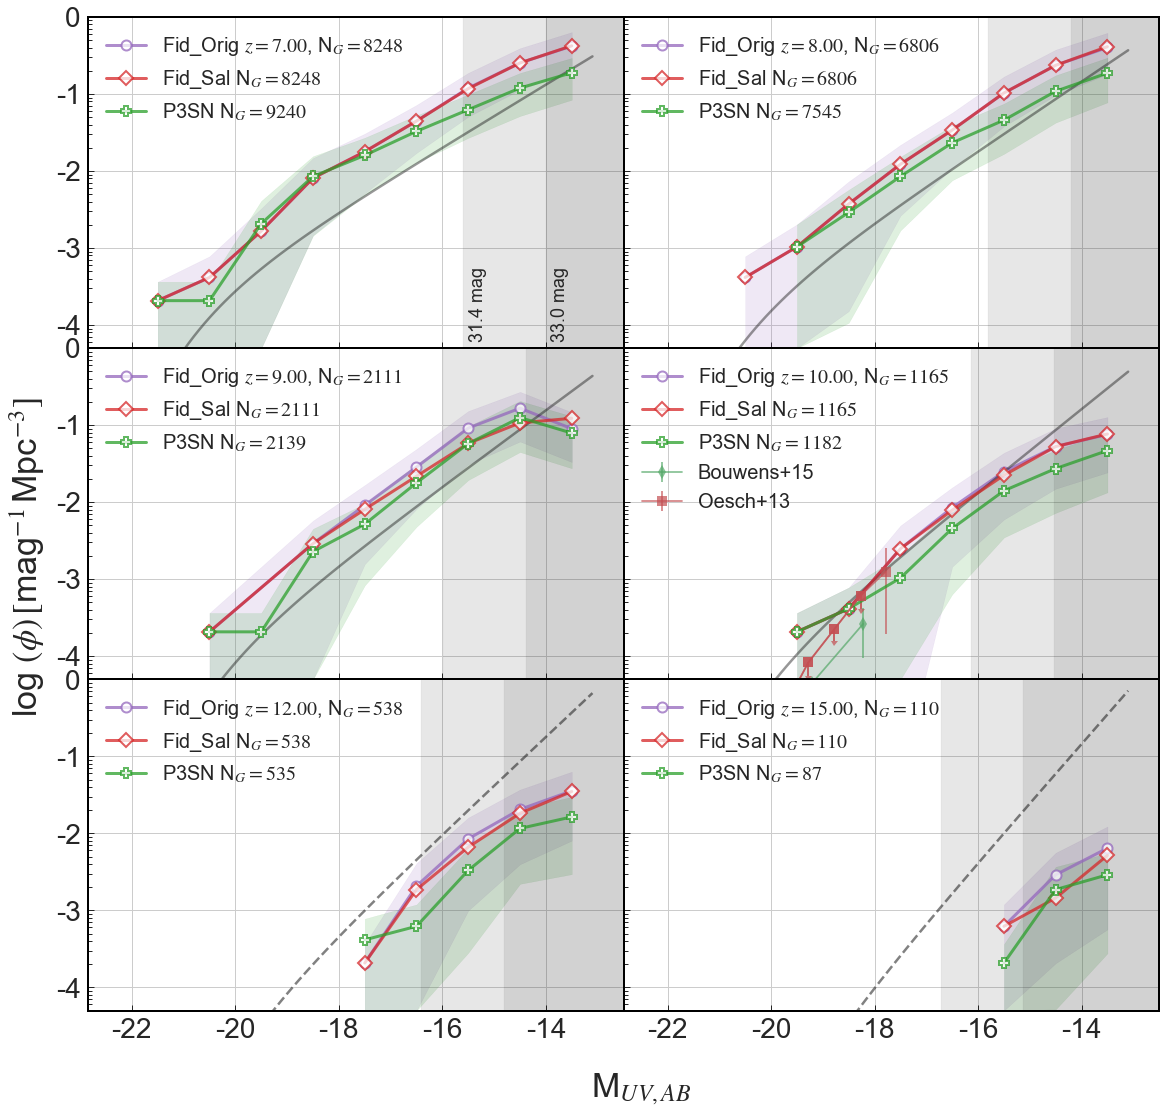

In [22]:
# Print LFs compared to Finkelstein projections... 
# Four plots in one figure

sns.set(style="whitegrid", font_scale=2,color_codes=True)
sns.set_style({'axes.edgecolor': '0.0','axes.linewidth': 2.0})
colors = ['#1f77b4',
 '#ff7f0e',
 '#2ca02c',
 '#d62728',
 '#9467bd'
         ]

plotSyms = ['o','D','P','s','^','*']
brightM = -22 # Plot range... 
limitM  = -13
magBins = np.linspace(brightM,limitM,(-brightM+limitM)*1+1) 
plotBins= np.linspace(-22,-14,9)

jwstUDC = 31.4
jwstUDC2 = 33.0

fig, axs = plt.subplots(nrows=3, ncols=2, sharex='col',sharey='row',figsize=(16,15))
done = False
for ps,c,dir in zip(plotSyms,reversed(colors),sorted(['Fid_Orig','Fid_Sal','P3SN'])):
    # for z,ax in zip(np.sort(thezs), axs.reshape(-1)):
    for z,ax in zip(np.sort(thezs), axs.reshape(-1)):

        if z not in thezs:
            continue;
        # Convert observed magnitude to Absolute ...
        absMag, pop3Mag, nmAbsMag       = compMags(dir,z)

        # Get the JWST ultra-deep campaign limit
        jwstUDCM= jwstUDC - 2.5*np.log10((1.0+z)**-1*(cosmo.luminosity_distance(z).to(u.pc)/(10.0 * u.pc))**2)
        jwstUDC2M= jwstUDC2 - 2.5*np.log10((1.0+z)**-1*(cosmo.luminosity_distance(z).to(u.pc)/(10.0 * u.pc))**2)
#         print("JWST lim {:.1f}".format(jwstUDCM))
#         print("JWST lim {:.1f}".format(jwstUDC2M))
        Ng = len(absMag) # Number of galaxies at this z

        rgForSFunc = np.arange(brightM,limitM, 0.1) # Smooth Schechter (Finkelstein data) curve... 

        dx = np.diff(magBins)
#         print("Bin size is {}".format(dx[0]))

        # GENERATE THE HISTOGRAM and HISTOGRAM DATA in the array 'n' for
        # both the improved Pop III luminosity and the classical
        n, binsA = np.histogram(absMag,bins=magBins, density=False)
        nNM, binsANM = np.histogram(nmAbsMag,bins=magBins, density=False)
        print(z,n)

        n_orig = n
        n = n/dx/simVol
        nNM = nNM/dx/simVol

        ################################
        # Replace zero halos in a bin with
        # nan ... since we are undersampled
        ################################
        AllNonZero    = np.nonzero(n)  # Define a mask of non-zero values
        AllNonZeroNM  = np.nonzero(nNM)  # Define a mask of non-zero values

        # With Evans help
        print("Working:", dir,z,plotBins)
        if dir in ["Fid_Orig", "P3SN"]:
            sigma_nu_for_bins = sigma_nu(dir,z,absMag,plotBins)
#             print("sigma_nu for bins",sigma_nu_for_bins)
            # Without cosmic variance we'd have sqrt(1/n_orig) * n_orig/dx/simVol = sqrt(n_orig)/dx/SimVol
            err_w_var = np.sqrt(sigma_nu_for_bins**2 + 1/n_orig) * n_orig/dx/simVol # Error: sqrt term, signal: n/dx/simVol
#             print("Errors: ",err_w_var)
            err_w_var_dwn = err_w_var # In case err_w_var puts us less than 0
            err_w_var_dwn[n-err_w_var_dwn <= 0.0] = n[n-err_w_var_dwn <= 0] - 5e-5 # which extends error to the plot's lower limit
#         print("Corrected lower Errors: ",err_w_var_dwn)

        # Find bin-centers
        binDeltaA = (binsA[0]-binsA[1])/2.0
        binCentersA = binsA[1::]+binDeltaA

        if dir == "Fid_Orig":
            label = dir+r' $z={:.2f}$, N$_G={}$'.format(z,Ng)
        else:
            label = dir+r' N$_G={}$'.format(Ng)
        mec = mpl.colors.colorConverter.to_rgba(c, alpha=0.9)
        # So here we are only plotting non-zero values -- and connecting them with a line.
        # So there are dropouts in this data that we are ignorning! I think this is ok since
        # we are sampling a small volume and are gonna miss halos in the intermediate mags
        ax.plot(binCentersA[AllNonZero],n[AllNonZero],markeredgewidth=2.0,
                ls='-',marker=ps, c=c, alpha=0.75,markerfacecolor="w",
                markersize=10,lw=3.0,mec=mec,label=label)
        if z >= 16:
            ax.plot(binCentersA[AllNonZeroNM],nNM[AllNonZeroNM],markeredgewidth=2.0,
                ls='-',marker='^', c='C2', alpha=0.9,markerfacecolor="w",
                markersize=10,lw=3.0,mec='C2',label=r'Classical Pop III'.format(z,Ng))
            ax.fill_between(binCentersA[AllNonZeroNM],n[AllNonZeroNM]+err_w_var[AllNonZeroNM],
                            nNM[AllNonZeroNM]-err_w_var_dwn[AllNonZeroNM],
                            color='C2', alpha=0.2)
        if dir in ["Fid_Orig", "P3SN"]:
            ax.fill_between(binCentersA[AllNonZero],n[AllNonZero]+err_w_var[AllNonZero],
                        n[AllNonZero]-err_w_var_dwn[AllNonZero],
                        color=c, alpha=0.15)

        if not done:
            ax.axvspan( jwstUDCM, limitM+0.5, alpha=0.1, color='k')
            ax.axvspan( jwstUDC2M, limitM+0.5, alpha=0.1, color='k')
        if z in [7] and not done:
            ax.annotate('31.4 mag', xy = (0.5, 0.5), xytext = (jwstUDCM+0.1, 6e-5), xycoords='axes fraction',
                textcoords = 'data', ha = 'left', va = 'bottom',fontsize=18, rotation=90)
            ax.annotate('33.0 mag', xy = (0.5, 0.5), xytext = (jwstUDC2M+0.1, 6e-5), xycoords='axes fraction',
                textcoords = 'data', ha = 'left', va = 'bottom',fontsize=18, rotation=90)

        # Format plt
        ax.set_xscale('linear')
        ax.set_yscale('log')
        ax.yaxis.set_major_formatter(logfmt)
        ax.set_xlim([brightM-0.85,limitM+0.5])
        ax.set_xticks(np.arange(brightM,limitM+1,2))
        ax.set_xticklabels([str(i) for i in np.arange(brightM,limitM+1,2)])
        ax.set_ylim([5e-5,1])
        ax.set_yticks([1e-4,1e-3,1e-2,1e-1,1])
        ax.xaxis.set_tick_params(which='both',width=1,length=6,direction='in',labelsize=28)
        ax.yaxis.set_tick_params(which='major',width=1,length=6,direction='in',labelsize=28)
        ax.yaxis.set_tick_params(which='minor',width=1,length=4,direction='in')

        #     plt.gca().invert_xaxis()
        gc.collect()

        if z > 10 and (not done):
            ax.plot(rgForSFunc, schechterM_forFit(finkel[z], rgForSFunc),'k--',lw=2.5,alpha=0.55)
        elif not done:
            ax.plot(rgForSFunc, schechterM_forFit(finkel[z], rgForSFunc),'k-',lw=2.5,alpha=0.45)

        if z==10 and not done:
    #         print("To logErrFix:",(10**bouwens15[:,1],bouwens15[:,2]),(10**bouwens15[:,1],bouwens15[:,3]))

            ax.errorbar(bouwens15[:,0],10**bouwens15[:,1], yerr=[logErrFix(10**bouwens15[:,1],bouwens15[:,2]),
                                                             logErrFix(10**bouwens15[:,1],bouwens15[:,3])],
                        marker='d',c='C1',alpha=0.7, markersize=10, mec='None',
                        label=r'Bouwens+15')
            ax.errorbar(oesch13[:,0],10**oesch13[:,1], yerr=[logErrFix(10**oesch13[:,1],oesch13[:,2]),
                                                             logErrFix(10**oesch13[:,1],oesch13[:,3])],
                        marker='s',c='C2',alpha=0.7,markersize=10,mec='k',label=r'Oesch+13'.format(z,Ng))
            ax.errorbar(oesch13[2:7,0],10**oesch13[2:7,1], yerr=[logErrFix(10**oesch13[2:7,1],oesch13[2:7,2]),
                                                             logErrFix(10**oesch13[2:7,1],oesch13[2:7,3])],
                        marker='s',c='C2',alpha=0.7,markersize=10,mec='k',uplims=True)
        # Add O'Shea data if available
        if z in OShea and dir=='fw1':
            ax.plot(OShea[z][:,0][OShea[z][:,0] < -14],OShea[z][:,1][OShea[z][:,0] < -14],ls='-.',marker='s',
                    markeredgewidth=2.0,markerfacecolor="w",c='k', ms=8, lw=3.0,alpha=0.5, label='O`Shea+15')
        ax.legend(loc=2, fontsize=20, numpoints=1 )

    done = True

fig.text(0.55, 0.00,'M$_{UV,AB}$', ha='center',size=34, )
fig.text(0.00, 0.5, r'log $(\phi)\, [$mag$^{-1}\, $Mpc$^{-3}]$',size=34,
         va='center', rotation='vertical')
plt.subplots_adjust(left=0.07, bottom=0.08, right=1.0, top=1.0, wspace=.0, hspace=.0)
plt.savefig("haloUVMag_Summary_scatter6_new.pdf".format(z),dpi=fig.dpi,bbox_inches='tight')
gc.collect()

Convert to Abs Mag. DM = 46.99 @ z=7.0
7 [   1    2    8   39   86  215  566 1222 2041]
Working: Fid_Sal 7 [-22. -21. -20. -19. -18. -17. -16. -15. -14.]


/Users/earnric/.conda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:7: RuntimeWarning: divide by zero encountered in log10


Convert to Abs Mag. DM = 47.20 @ z=8.0
8 [   0    2    5   18   59  164  498 1139 1990]
Working: Fid_Sal 8 [-22. -21. -20. -19. -18. -17. -16. -15. -14.]


/Users/earnric/.conda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:75: RuntimeWarning: divide by zero encountered in true_divide
/Users/earnric/.conda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:75: RuntimeWarning: invalid value encountered in multiply
/Users/earnric/.conda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:78: RuntimeWarning: invalid value encountered in less_equal


Convert to Abs Mag. DM = 47.38 @ z=9.0
9 [  0   1   0  14  39 105 280 517 593]
Working: Fid_Sal 9 [-22. -21. -20. -19. -18. -17. -16. -15. -14.]
Convert to Abs Mag. DM = 47.54 @ z=10.0
10 [  0   0   1   2  12  38 108 255 371]
Working: Fid_Sal 10 [-22. -21. -20. -19. -18. -17. -16. -15. -14.]
Convert to Abs Mag. DM = 47.81 @ z=12.0
12 [  0   0   0   0   1   9  32  88 169]
Working: Fid_Sal 12 [-22. -21. -20. -19. -18. -17. -16. -15. -14.]
Convert to Abs Mag. DM = 48.13 @ z=15.0
15 [ 0  0  0  0  0  0  3  7 25]
Working: Fid_Sal 15 [-22. -21. -20. -19. -18. -17. -16. -15. -14.]
Convert to Abs Mag. DM = 46.99 @ z=7.0
7 [  1   1  10  41  77 158 302 577 911]
Working: P3SN 7 [-22. -21. -20. -19. -18. -17. -16. -15. -14.]
Convert to Abs Mag. DM = 47.20 @ z=8.0
8 [  0   0   5  14  41 112 221 524 903]
Working: P3SN 8 [-22. -21. -20. -19. -18. -17. -16. -15. -14.]
Convert to Abs Mag. DM = 47.38 @ z=9.0
9 [  0   1   1  11  25  86 279 606 381]
Working: P3SN 9 [-22. -21. -20. -19. -18. -17. -16. -15. 

33746

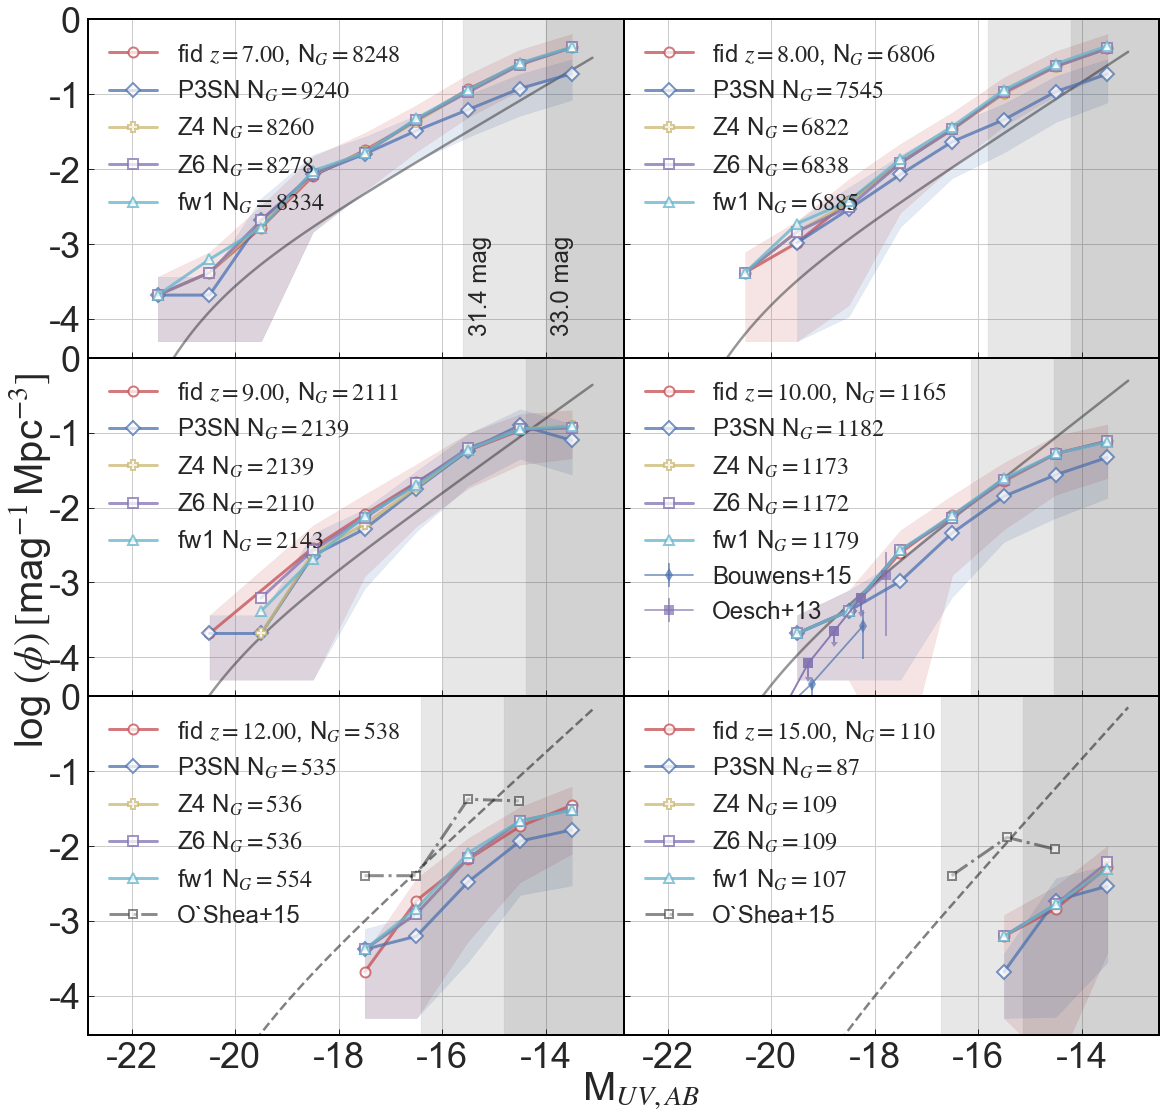

In [70]:
# Print LFs compared to Finkelstein projections... 
# Four plots in one figure

sns.set(style="whitegrid", font_scale=2,color_codes=True)
sns.set_style({'axes.edgecolor': '0.0','axes.linewidth': 2.0})
colors = ['#1f77b4',
 '#ff7f0e',
 '#2ca02c',
 '#d62728',
 '#9467bd'
         ]
colors = [
    'C5',
    'C3',
    'C4',
    'C6',
    'C2'
     ]

plotSyms = ['o','D','P','s','^','*']
brightM = -22 # Plot range... 
limitM  = -13
magBins = np.linspace(brightM,limitM,(-brightM+limitM)*1+1) 
plotBins= np.linspace(-22,-14,9)

jwstUDC = 31.4
jwstUDC2 = 33.0

fig, axs = plt.subplots(nrows=3, ncols=2, sharex='col',sharey='row',figsize=(16,15))
done = False
for ps,c,dir in zip(plotSyms,reversed(colors),sorted(['Fid_Sal','P3SN','fw1','Z6','Z4'])):
    # for z,ax in zip(np.sort(thezs), axs.reshape(-1)):
    for z,ax in zip(np.sort(thezs), axs.reshape(-1)):

        if z not in thezs:
            continue;
        # Convert observed magnitude to Absolute ...
        absMag, pop3Mag, nmAbsMag       = compMags(dir,z)

        # Get the JWST ultra-deep campaign limit
        jwstUDCM= jwstUDC - 2.5*np.log10((1.0+z)**-1*(cosmo.luminosity_distance(z).to(u.pc)/(10.0 * u.pc))**2)
        jwstUDC2M= jwstUDC2 - 2.5*np.log10((1.0+z)**-1*(cosmo.luminosity_distance(z).to(u.pc)/(10.0 * u.pc))**2)
#         print("JWST lim {:.1f}".format(jwstUDCM))
#         print("JWST lim {:.1f}".format(jwstUDC2M))
        Ng = len(absMag) # Number of galaxies at this z

        rgForSFunc = np.arange(brightM,limitM, 0.1) # Smooth Schechter (Finkelstein data) curve... 

        dx = np.diff(magBins)
#         print("Bin size is {}".format(dx[0]))

        # GENERATE THE HISTOGRAM and HISTOGRAM DATA in the array 'n' for
        # both the improved Pop III luminosity and the classical
        n, binsA = np.histogram(absMag,bins=magBins, density=False)
        nNM, binsANM = np.histogram(nmAbsMag,bins=magBins, density=False)
        print(z,n)

        n_orig = n
        n = n/dx/simVol
        nNM = nNM/dx/simVol

        ################################
        # Replace zero halos in a bin with
        # nan ... since we are undersampled
        ################################
        AllNonZero    = np.nonzero(n)  # Define a mask of non-zero values
        AllNonZeroNM  = np.nonzero(nNM)  # Define a mask of non-zero values

        # With Evans help
        print("Working:", dir,z,plotBins)
        if dir in ["Fid_Sal", "P3SN"]:
            sigma_nu_for_bins = sigma_nu(dir,z,absMag,plotBins)
#             print("sigma_nu for bins",sigma_nu_for_bins)
            # Without cosmic variance we'd have sqrt(1/n_orig) * n_orig/dx/simVol = sqrt(n_orig)/dx/SimVol
            err_w_var = np.sqrt(sigma_nu_for_bins**2 + 1/n_orig) * n_orig/dx/simVol # Error: sqrt term, signal: n/dx/simVol
#             print("Errors: ",err_w_var)
            err_w_var_dwn = err_w_var # In case err_w_var puts us less than 0
            err_w_var_dwn[n-err_w_var_dwn <= 0.0] = n[n-err_w_var_dwn <= 0] - 5e-5 # which extends error to the plot's lower limit
#         print("Corrected lower Errors: ",err_w_var_dwn)

        # Find bin-centers
        binDeltaA = (binsA[0]-binsA[1])/2.0
        binCentersA = binsA[1::]+binDeltaA

        if dir == "Fid_Sal":
            label = 'fid'+r' $z={:.2f}$, N$_G={}$'.format(z,Ng)
        else:
            label = dir+r' N$_G={}$'.format(Ng)
        mec = mpl.colors.colorConverter.to_rgba(c, alpha=0.9)
        # So here we are only plotting non-zero values -- and connecting them with a line.
        # So there are dropouts in this data that we are ignorning! I think this is ok since
        # we are sampling a small volume and are gonna miss halos in the intermediate mags
        ax.plot(binCentersA[AllNonZero],n[AllNonZero],markeredgewidth=2.0,
                ls='-',marker=ps, c=c, alpha=0.75,markerfacecolor="w",
                markersize=10,lw=3.0,mec=mec,label=label)
        if z >= 16:
            ax.plot(binCentersA[AllNonZeroNM],nNM[AllNonZeroNM],markeredgewidth=2.0,
                ls='-',marker='^', c='C2', alpha=0.9,markerfacecolor="w",
                markersize=10,lw=3.0,mec='C2',label=r'Classical Pop III'.format(z,Ng))
            ax.fill_between(binCentersA[AllNonZeroNM],n[AllNonZeroNM]+err_w_var[AllNonZeroNM],
                            nNM[AllNonZeroNM]-err_w_var_dwn[AllNonZeroNM],
                            color='C2', alpha=0.2)
        if dir in ["Fid_Sal", "P3SN"]:
            ax.fill_between(binCentersA[AllNonZero],n[AllNonZero]+err_w_var[AllNonZero],
                        n[AllNonZero]-err_w_var_dwn[AllNonZero],
                        color=c, alpha=0.15)

        if not done:
            ax.axvspan( jwstUDCM, limitM+0.5, alpha=0.1, color='k')
            ax.axvspan( jwstUDC2M, limitM+0.5, alpha=0.1, color='k')
        if z in [7] and not done:
            ax.annotate('31.4 mag', xy = (0.5, 0.5), xytext = (jwstUDCM+0.1, 6e-5), xycoords='axes fraction',
                textcoords = 'data', ha = 'left', va = 'bottom',fontsize=24, rotation=90)
            ax.annotate('33.0 mag', xy = (0.5, 0.5), xytext = (jwstUDC2M+0.1, 6e-5), xycoords='axes fraction',
                textcoords = 'data', ha = 'left', va = 'bottom',fontsize=24, rotation=90)

        # Format plt
        ax.set_xscale('linear')
        ax.set_yscale('log')
        ax.yaxis.set_major_formatter(logfmt)
        ax.set_xlim([brightM-0.85,limitM+0.5])
        ax.set_xticks(np.arange(brightM,limitM+1,2))
        ax.set_xticklabels([str(i) for i in np.arange(brightM,limitM+1,2)])
        ax.set_ylim([3e-5,1])
        ax.set_yticks([1e-4,1e-3,1e-2,1e-1,1])
        ax.xaxis.set_tick_params(which='both',width=1,length=6,direction='in',labelsize=36)
        ax.yaxis.set_tick_params(which='major',width=1,length=6,direction='in',labelsize=36)
        ax.yaxis.set_tick_params(which='minor',width=1,length=4,direction='in')

        #     plt.gca().invert_xaxis()
        gc.collect()

        if z > 10 and (not done):
            ax.plot(rgForSFunc, schechterM_forFit(finkel[z], rgForSFunc),'k--',lw=2.5,alpha=0.55)
        elif not done:
            ax.plot(rgForSFunc, schechterM_forFit(finkel[z], rgForSFunc),'k-',lw=2.5,alpha=0.45)

        if z==10 and not done:
    #         print("To logErrFix:",(10**bouwens15[:,1],bouwens15[:,2]),(10**bouwens15[:,1],bouwens15[:,3]))

            ax.errorbar(bouwens15[:,0],10**bouwens15[:,1], yerr=[logErrFix(10**bouwens15[:,1],bouwens15[:,2]),
                                                             logErrFix(10**bouwens15[:,1],bouwens15[:,3])],
                        marker='d',c='C0',alpha=0.7, markersize=10, mec='None',
                        label=r'Bouwens+15')
            ax.errorbar(oesch13[:,0],10**oesch13[:,1], yerr=[logErrFix(10**oesch13[:,1],oesch13[:,2]),
                                                             logErrFix(10**oesch13[:,1],oesch13[:,3])],
                        marker='s',c='C9',alpha=0.7,markersize=10,mec='k',label=r'Oesch+13'.format(z,Ng))
            ax.errorbar(oesch13[2:7,0],10**oesch13[2:7,1], yerr=[logErrFix(10**oesch13[2:7,1],oesch13[2:7,2]),
                                                             logErrFix(10**oesch13[2:7,1],oesch13[2:7,3])],
                        marker='s',c='C9',alpha=0.7,markersize=10,mec='k',uplims=True)
        # Add O'Shea data if available
        if z in OShea and dir=='fw1':
            ax.plot(OShea[z][:,0][OShea[z][:,0] < -14],OShea[z][:,1][OShea[z][:,0] < -14],ls='-.',marker='s',
                    markeredgewidth=2.0,markerfacecolor="w",c='k', ms=8, lw=3.0,alpha=0.5, label='O`Shea+15')
        ax.legend(loc=2, fontsize=24, numpoints=1 )

    done = True

fig.text(0.55, 0.00,'M$_{UV,AB}$', ha='center',size=40, )
fig.text(0.00, 0.5, r'log $(\phi)\, [$mag$^{-1}\, $Mpc$^{-3}]$',size=40,
         va='center', rotation='vertical')
plt.subplots_adjust(left=0.07, bottom=0.06, right=1.0, top=1.0, wspace=.0, hspace=.0)
plt.savefig("haloUVMag_Summary_scatter6_new.pdf".format(z),dpi=fig.dpi,bbox_inches='tight')
gc.collect()

Convert to Abs Mag. DM = 46.99 @ z=7.0
7 [   1    2    8   39   86  215  576 1222 2020]
Working: Fid_Orig 7


/Users/earnric/.conda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:7: RuntimeWarning: divide by zero encountered in log10


Convert to Abs Mag. DM = 47.20 @ z=8.0
8 [   0    2    5   18   59  164  497 1140 1938]
Working: Fid_Orig 8


/Users/earnric/.conda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:74: RuntimeWarning: divide by zero encountered in true_divide
/Users/earnric/.conda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:74: RuntimeWarning: invalid value encountered in multiply
/Users/earnric/.conda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:77: RuntimeWarning: invalid value encountered in less_equal


Convert to Abs Mag. DM = 47.38 @ z=9.0
9 [  0   1   0  14  44 138 443 802 435]
Working: Fid_Orig 9
Convert to Abs Mag. DM = 47.54 @ z=10.0
10 [  0   0   1   2  12  41 120 255 366]
Working: Fid_Orig 10
Convert to Abs Mag. DM = 47.81 @ z=12.0
12 [  0   0   0   0   1  10  41  99 172]
Working: Fid_Orig 12
Convert to Abs Mag. DM = 48.13 @ z=15.0
15 [ 0  0  0  0  0  0  3 14 31]
Working: Fid_Orig 15
Convert to Abs Mag. DM = 46.99 @ z=7.0
7 [   1    2    8   39   86  215  566 1222 2041]
Working: Fid_Sal 7
Convert to Abs Mag. DM = 47.20 @ z=8.0
8 [   0    2    5   18   59  164  498 1139 1990]
Working: Fid_Sal 8
Convert to Abs Mag. DM = 47.38 @ z=9.0
9 [  0   1   0  14  39 105 280 517 593]
Working: Fid_Sal 9
Convert to Abs Mag. DM = 47.54 @ z=10.0
10 [  0   0   1   2  12  38 108 255 371]
Working: Fid_Sal 10
Convert to Abs Mag. DM = 47.81 @ z=12.0
12 [  0   0   0   0   1   9  32  88 169]
Working: Fid_Sal 12
Convert to Abs Mag. DM = 48.13 @ z=15.0
15 [ 0  0  0  0  0  0  3  7 25]
Working: Fid_Sal 1

24970

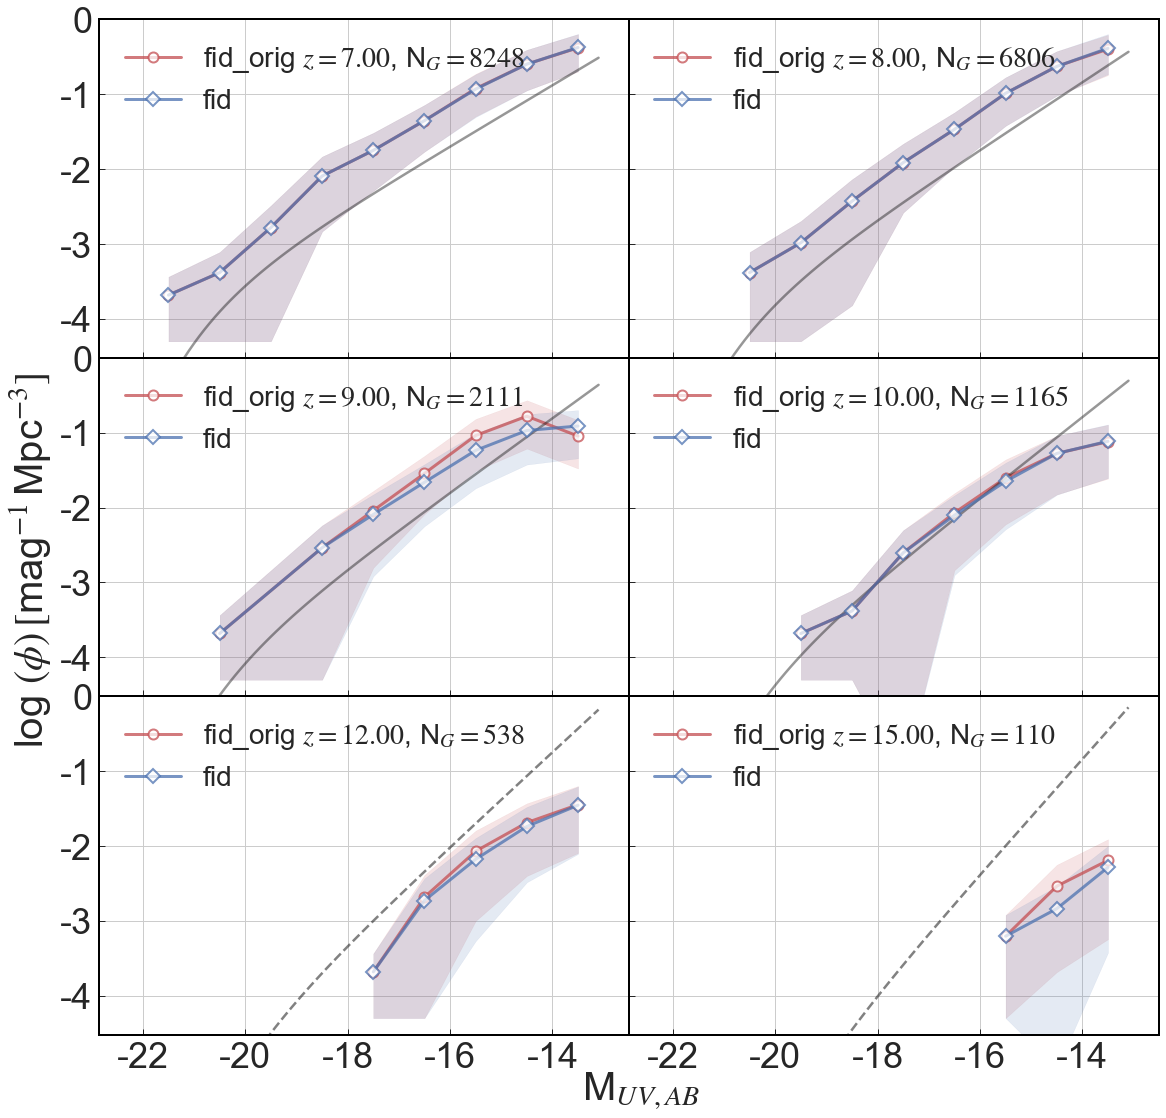

In [71]:
# Print LFs compared to Finkelstein projections... 
# Four plots in one figure

sns.set(style="whitegrid", font_scale=2,color_codes=True)
sns.set_style({'axes.edgecolor': '0.0','axes.linewidth': 2.0})
colors = ['#1f77b4',
 '#ff7f0e',
 '#2ca02c',
 '#d62728',
 '#9467bd'
         ]
colors = [
    'C2',
    'C0',
    'C1',
    'C3',
    'C4'
     ]

plotSyms = ['o','D','P','s','^','*']
brightM = -22 # Plot range... 
limitM  = -13
magBins = np.linspace(brightM,limitM,(-brightM+limitM)*1+1) 
plotBins= np.linspace(-22,-14,9)

jwstUDC = 31.4
jwstUDC2 = 33.0

fig, axs = plt.subplots(nrows=3, ncols=2, sharex='col',sharey='row',figsize=(16,15))
done = False
for ps,c,dir in zip(plotSyms,colors,sorted(['Fid_Sal','Fid_Orig'])):
    # for z,ax in zip(np.sort(thezs), axs.reshape(-1)):
    for z,ax in zip(np.sort(thezs), axs.reshape(-1)):

        if z not in thezs:
            continue;
        # Convert observed magnitude to Absolute ...
        absMag, pop3Mag, nmAbsMag       = compMags(dir,z)

        # Get the JWST ultra-deep campaign limit
        jwstUDCM= jwstUDC - 2.5*np.log10((1.0+z)**-1*(cosmo.luminosity_distance(z).to(u.pc)/(10.0 * u.pc))**2)
        jwstUDC2M= jwstUDC2 - 2.5*np.log10((1.0+z)**-1*(cosmo.luminosity_distance(z).to(u.pc)/(10.0 * u.pc))**2)
#         print("JWST lim {:.1f}".format(jwstUDCM))
#         print("JWST lim {:.1f}".format(jwstUDC2M))
        Ng = len(absMag) # Number of galaxies at this z

        rgForSFunc = np.arange(brightM,limitM, 0.1) # Smooth Schechter (Finkelstein data) curve... 

        dx = np.diff(magBins)
#         print("Bin size is {}".format(dx[0]))

        # GENERATE THE HISTOGRAM and HISTOGRAM DATA in the array 'n' for
        # both the improved Pop III luminosity and the classical
        n, binsA = np.histogram(absMag,bins=magBins, density=False)
        nNM, binsANM = np.histogram(nmAbsMag,bins=magBins, density=False)
        print(z,n)

        n_orig = n
        n = n/dx/simVol
        nNM = nNM/dx/simVol

        ################################
        # Replace zero halos in a bin with
        # nan ... since we are undersampled
        ################################
        AllNonZero    = np.nonzero(n)  # Define a mask of non-zero values
        AllNonZeroNM  = np.nonzero(nNM)  # Define a mask of non-zero values

        # With Evans help
        print("Working:", dir,z)
        sigma_nu_for_bins = sigma_nu(dir,z,absMag,plotBins)
#             print("sigma_nu for bins",sigma_nu_for_bins)
        # Without cosmic variance we'd have sqrt(1/n_orig) * n_orig/dx/simVol = sqrt(n_orig)/dx/SimVol
        err_w_var = np.sqrt(sigma_nu_for_bins**2 + 1/n_orig) * n_orig/dx/simVol # Error: sqrt term, signal: n/dx/simVol
#             print("Errors: ",err_w_var)
        err_w_var_dwn = err_w_var # In case err_w_var puts us less than 0
        err_w_var_dwn[n-err_w_var_dwn <= 0.0] = n[n-err_w_var_dwn <= 0] - 5e-5 # which extends error to the plot's lower limit
#         print("Corrected lower Errors: ",err_w_var_dwn)

        # Find bin-centers
        binDeltaA = (binsA[0]-binsA[1])/2.0
        binCentersA = binsA[1::]+binDeltaA

        if dir == "Fid_Sal":
            label = 'fid'
        elif dir == 'Fid_Orig':
            label = 'fid_orig'+r' $z={:.2f}$, N$_G={}$'.format(z,Ng)
        else:
            label = dir+r' N$_G={}$'.format(Ng)
        mec = mpl.colors.colorConverter.to_rgba(c, alpha=0.9)
        # So here we are only plotting non-zero values -- and connecting them with a line.
        # So there are dropouts in this data that we are ignorning! I think this is ok since
        # we are sampling a small volume and are gonna miss halos in the intermediate mags
        ax.plot(binCentersA[AllNonZero],n[AllNonZero],markeredgewidth=2.0,
                ls='-',marker=ps, c=c, alpha=0.75,markerfacecolor="w",
                markersize=10,lw=3.0,mec=mec, label=label)

        ax.fill_between(binCentersA[AllNonZero],n[AllNonZero]+err_w_var[AllNonZero],
                        n[AllNonZero]-err_w_var_dwn[AllNonZero],
                        color=c, alpha=0.15)

#         if not done:
#             ax.axvspan( jwstUDCM, limitM+0.5, alpha=0.1, color='k')
#             ax.axvspan( jwstUDC2M, limitM+0.5, alpha=0.1, color='k')
#         if z in [7] and not done:
#             ax.annotate('31.4 mag', xy = (0.5, 0.5), xytext = (jwstUDCM+0.1, 6e-5), xycoords='axes fraction',
#                 textcoords = 'data', ha = 'left', va = 'bottom',fontsize=20, rotation=90)
#             ax.annotate('33.0 mag', xy = (0.5, 0.5), xytext = (jwstUDC2M+0.1, 6e-5), xycoords='axes fraction',
#                 textcoords = 'data', ha = 'left', va = 'bottom',fontsize=20, rotation=90)

        # Format plt
        ax.set_xscale('linear')
        ax.set_yscale('log')
        ax.yaxis.set_major_formatter(logfmt)
        ax.set_xlim([brightM-0.85,limitM+0.5])
        ax.set_xticks(np.arange(brightM,limitM+1,2))
        ax.set_xticklabels([str(i) for i in np.arange(brightM,limitM+1,2)])
        ax.set_ylim([3e-5,1])
        ax.set_yticks([1e-4,1e-3,1e-2,1e-1,1])
        ax.xaxis.set_tick_params(which='both',width=1,length=6,direction='in',labelsize=36)
        ax.yaxis.set_tick_params(which='major',width=1,length=6,direction='in',labelsize=36)
        ax.yaxis.set_tick_params(which='minor',width=1,length=4,direction='in')

        #     plt.gca().invert_xaxis()
        gc.collect()

        if z > 10 and (not done):
            ax.plot(rgForSFunc, schechterM_forFit(finkel[z], rgForSFunc),'k--',lw=2.5,alpha=0.55)
        elif not done:
            ax.plot(rgForSFunc, schechterM_forFit(finkel[z], rgForSFunc),'k-',lw=2.5,alpha=0.45)
        ax.legend(loc=2, fontsize=28, numpoints=1 )
    done = True

fig.text(0.55, 0.00,'M$_{UV,AB}$', ha='center',size=40, )
fig.text(0.00, 0.5, r'log $(\phi)\, [$mag$^{-1}\, $Mpc$^{-3}]$',size=40,
         va='center', rotation='vertical')
plt.subplots_adjust(left=0.08, bottom=0.06, right=1.0, top=1.0, wspace=.0, hspace=.0)
plt.savefig("haloUVMag_Summary_newold_comp.pdf".format(z),dpi=fig.dpi,bbox_inches='tight')
gc.collect()

In [ ]:
# handles, labels = ax.get_legend_handles_labels()
# # sort both labels and handles by labels
# labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
# ax.legend(handles, labels)

Convert to Abs Mag. DM = 46.99 @ z=7.0
7 [   1    2    8   39   86  215  566 1222 2041]
Fid_Sal 7 [-22. -21. -20. -19. -18. -17. -16. -15. -14.]


/Users/earnric/.conda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:7: RuntimeWarning: divide by zero encountered in log10


Convert to Abs Mag. DM = 47.20 @ z=8.0
8 [   0    2    5   18   59  164  498 1139 1990]
Fid_Sal 8 [-22. -21. -20. -19. -18. -17. -16. -15. -14.]


/Users/earnric/.conda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in true_divide
/Users/earnric/.conda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: invalid value encountered in multiply
/Users/earnric/.conda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:87: RuntimeWarning: invalid value encountered in less_equal


Convert to Abs Mag. DM = 47.38 @ z=9.0
9 [  0   1   0  14  39 105 280 517 593]
Fid_Sal 9 [-22. -21. -20. -19. -18. -17. -16. -15. -14.]
Convert to Abs Mag. DM = 47.54 @ z=10.0
10 [  0   0   1   2  12  38 108 255 371]
Fid_Sal 10 [-22. -21. -20. -19. -18. -17. -16. -15. -14.]
Convert to Abs Mag. DM = 47.81 @ z=12.0
12 [  0   0   0   0   1   9  32  88 169]
Fid_Sal 12 [-22. -21. -20. -19. -18. -17. -16. -15. -14.]
Convert to Abs Mag. DM = 48.13 @ z=15.0
15 [ 0  0  0  0  0  0  3  7 25]
Fid_Sal 15 [-22. -21. -20. -19. -18. -17. -16. -15. -14.]
Convert to Abs Mag. DM = 46.99 @ z=7.0
7 [   1    2    8   39   86  215  576 1222 2020]
Fid_Orig 7 [-22. -21. -20. -19. -18. -17. -16. -15. -14.]
Convert to Abs Mag. DM = 47.20 @ z=8.0
8 [   0    2    5   18   59  164  497 1140 1938]
Fid_Orig 8 [-22. -21. -20. -19. -18. -17. -16. -15. -14.]
Convert to Abs Mag. DM = 47.38 @ z=9.0
9 [  0   1   0  14  44 138 443 802 435]
Fid_Orig 9 [-22. -21. -20. -19. -18. -17. -16. -15. -14.]
Convert to Abs Mag. DM = 47

8919

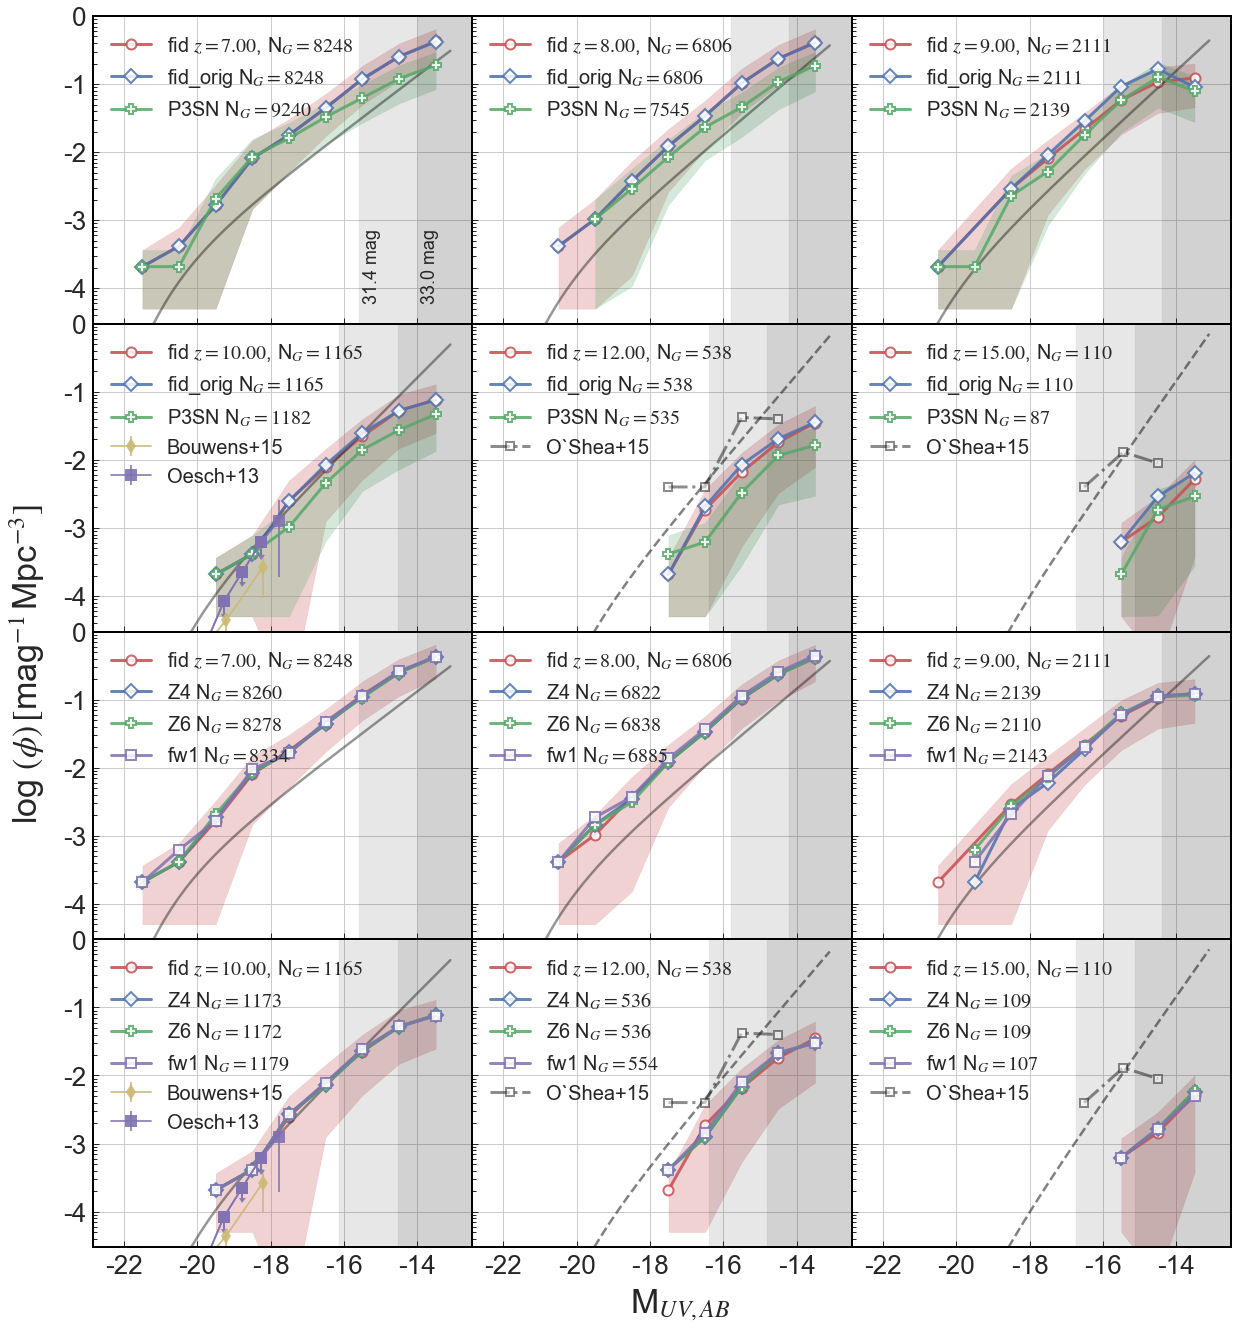

In [39]:
# Print LFs compare to Fiducial
# 18 plots ... 

sns.set(style="whitegrid", font_scale=2,color_codes=True)
sns.set_style({'axes.edgecolor': '0.0','axes.linewidth': 2.0})
colors = ['#1f77b4',
 '#ff7f0e',
 '#2ca02c',
 '#d62728',
 '#9467bd'
         ]
colors = [
    'C2',
    'C0',
    'C1',
    'C3',
    'C6'
     ]

plotSyms = ['o','D','P','s','^','*']
brightM = -22 # Plot range... 
limitM  = -13
magBins = np.linspace(brightM,limitM,(-brightM+limitM)*1+1) 
plotBins= np.linspace(-22,-14,9)

jwstUDC = 31.4
jwstUDC2 = 33.0

fig, axs = plt.subplots(nrows=4, ncols=3, sharex='col',sharey='row',figsize=(17,18))
done = False

pairs = [
    ['Fid_Sal','Fid_Orig','P3SN'],
    ['Fid_Sal','Z4','Z6','fw1']
        ]

the_axs = axs.reshape(-1)

for plotset in pairs:
    for ps,c,dir in zip(plotSyms,colors,plotset):
        for z,ax in zip(np.sort([15,12,10,9,8,7]), the_axs):

            if z not in thezs:
                continue;
            # Convert observed magnitude to Absolute ...
            absMag, pop3Mag, nmAbsMag       = compMags(dir,z)

            # Get the JWST ultra-deep campaign limit
            jwstUDCM= jwstUDC - 2.5*np.log10((1.0+z)**-1*(cosmo.luminosity_distance(z).to(u.pc)/(10.0 * u.pc))**2)
            jwstUDC2M= jwstUDC2 - 2.5*np.log10((1.0+z)**-1*(cosmo.luminosity_distance(z).to(u.pc)/(10.0 * u.pc))**2)
    #         print("JWST lim {:.1f}".format(jwstUDCM))
    #         print("JWST lim {:.1f}".format(jwstUDC2M))
            Ng = len(absMag) # Number of galaxies at this z

            rgForSFunc = np.arange(brightM,limitM, 0.1) # Smooth Schechter (Finkelstein data) curve... 

            dx = np.diff(magBins)
    #         print("Bin size is {}".format(dx[0]))

            # GENERATE THE HISTOGRAM and HISTOGRAM DATA in the array 'n' for
            # both the improved Pop III luminosity and the classical
            n, binsA = np.histogram(absMag,bins=magBins, density=False)
            nNM, binsANM = np.histogram(nmAbsMag,bins=magBins, density=False)
            print(z,n)

            n_orig = n
            n = n/dx/simVol
            nNM = nNM/dx/simVol


            ################################
            # Replace zero halos in a bin with
            # nan ... since we are undersampled
            ################################
            AllNonZero    = np.nonzero(n)  # Define a mask of non-zero values
            AllNonZeroNM  = np.nonzero(nNM)  # Define a mask of non-zero values

            # With Evans help
            print(dir,z,plotBins)
            if dir in ["Fid_Sal", "P3SN"]:
                sigma_nu_for_bins = sigma_nu(dir,z,absMag,plotBins)
    #             print("sigma_nu for bins",sigma_nu_for_bins)
                # Without cosmic variance we'd have sqrt(1/n_orig) * n_orig/dx/simVol = sqrt(n_orig)/dx/SimVol
                err_w_var = np.sqrt(sigma_nu_for_bins**2 + 1/n_orig) * n_orig/dx/simVol # Error: sqrt term, signal: n/dx/simVol
    #             print("Errors: ",err_w_var)
                err_w_var_dwn = err_w_var # In case err_w_var puts us less than 0
                err_w_var_dwn[n-err_w_var_dwn <= 0.0] = n[n-err_w_var_dwn <= 0] - 5e-5 # which extends error to the plot's lower limit
    #         print("Corrected lower Errors: ",err_w_var_dwn)

            # Find bin-centers
            binDeltaA = (binsA[0]-binsA[1])/2.0
            binCentersA = binsA[1::]+binDeltaA

            if dir == "Fid_Sal":
                label = "fid"+r' $z={:.2f}$, N$_G={}$'.format(z,Ng)
            elif dir == "Fid_Orig":
                label = 'fid_orig'+r' N$_G={}$'.format(Ng)
            else:
                label = dir+r' N$_G={}$'.format(Ng)
            mec = mpl.colors.colorConverter.to_rgba(c, alpha=0.9)
            # So here we are only plotting non-zero values -- and connecting them with a line.
            # So there are dropouts in this data that we are ignorning! I think this is ok since
            # we are sampling a small volume and are gonna miss halos in the intermediate mags
            ax.plot(binCentersA[AllNonZero],n[AllNonZero],markeredgewidth=2.0,
                    ls='-',marker=ps, c=c, alpha=0.85,markerfacecolor="w",
                    markersize=10,lw=3.0,mec=mec,label=label)

            if dir in ["Fid_Sal", "P3SN"]:
                ax.fill_between(binCentersA[AllNonZero],n[AllNonZero]+err_w_var[AllNonZero],
                            n[AllNonZero]-err_w_var_dwn[AllNonZero],
                            color=c, alpha=0.25)

            if not done:
                ax.axvspan( jwstUDCM, limitM+0.5, alpha=0.1, color='k')
                ax.axvspan( jwstUDC2M, limitM+0.5, alpha=0.1, color='k')
            if z in [7] and dir=='P3SN':
                ax.annotate('31.4 mag', xy = (0.5, 0.5), xytext = (jwstUDCM+0.1, 6e-5), xycoords='axes fraction',
                    textcoords = 'data', ha = 'left', va = 'bottom',fontsize=18, rotation=90)
                ax.annotate('33.0 mag', xy = (0.5, 0.5), xytext = (jwstUDC2M+0.1, 6e-5), xycoords='axes fraction',
                    textcoords = 'data', ha = 'left', va = 'bottom',fontsize=18, rotation=90)

            # Format plt
            ax.set_xscale('linear')
            ax.set_yscale('log')
            ax.yaxis.set_major_formatter(logfmt)
            ax.set_xlim([brightM-0.85,limitM+0.5])
            ax.set_xticks(np.arange(brightM,limitM+1,2))
            ax.set_xticklabels([str(i) for i in np.arange(brightM,limitM+1,2)])
            ax.set_ylim([3e-5,1])
            ax.set_yticks([1e-4,1e-3,1e-2,1e-1,1])
            ax.xaxis.set_tick_params(which='both',width=1,length=6,direction='in',labelsize=26)
            ax.yaxis.set_tick_params(which='major',width=1,length=6,direction='in',labelsize=26)
            ax.yaxis.set_tick_params(which='minor',width=1,length=4,direction='in')

            #     plt.gca().invert_xaxis()
            gc.collect()

            if z > 10 and (not done):
                ax.plot(rgForSFunc, schechterM_forFit(finkel[z], rgForSFunc),'k--',lw=2.5,alpha=0.55)
            elif not done:
                ax.plot(rgForSFunc, schechterM_forFit(finkel[z], rgForSFunc),'k-',lw=2.5,alpha=0.45)

            if z==10 and not done:
        #         print("To logErrFix:",(10**bouwens15[:,1],bouwens15[:,2]),(10**bouwens15[:,1],bouwens15[:,3]))

                ax.errorbar(bouwens15[:,0],10**bouwens15[:,1], yerr=[logErrFix(10**bouwens15[:,1],bouwens15[:,2]),
                                                                 logErrFix(10**bouwens15[:,1],bouwens15[:,3])],
                            marker='d',c='C4',alpha=0.9, markersize=12, mec='None',
                            label=r'Bouwens+15')
                ax.errorbar(oesch13[:,0],10**oesch13[:,1], yerr=[logErrFix(10**oesch13[:,1],oesch13[:,2]),
                                                                 logErrFix(10**oesch13[:,1],oesch13[:,3])],
                            marker='s',c='C9',alpha=0.9,markersize=12,mec='k',label=r'Oesch+13'.format(z,Ng))
                ax.errorbar(oesch13[2:7,0],10**oesch13[2:7,1], yerr=[logErrFix(10**oesch13[2:7,1],oesch13[2:7,2]),
                                                                 logErrFix(10**oesch13[2:7,1],oesch13[2:7,3])],
                            marker='s',c='C9',alpha=0.9,markersize=12,mec='k',uplims=True)
            # Add O'Shea data if available
            if z in OShea and dir in plotset[-1:]:
                ax.plot(OShea[z][:,0][OShea[z][:,0] < -14],OShea[z][:,1][OShea[z][:,0] < -14],ls='-.',marker='s',
                        markeredgewidth=2.0,markerfacecolor="w",c='k', ms=8, lw=3.0,alpha=0.5, label='O`Shea+15')
            ax.legend(loc=2, fontsize=20, numpoints=1 )

        done = True
    the_axs = the_axs[6:] # Move on to the next 6 plots
    done = False          # Need to ensure we include observations for next set of 6 plots

fig.text(0.55, 0.00,'M$_{UV,AB}$', ha='center',size=34, )
fig.text(0.00, 0.5, r'log $(\phi)\, [$mag$^{-1}\, $Mpc$^{-3}]$',size=34,
         va='center', rotation='vertical')
plt.subplots_adjust(left=0.07, bottom=0.05, right=1.0, top=1.0, wspace=.0, hspace=.0)
plt.savefig("haloUVMag_Summary_scatter12_new.pdf".format(z),dpi=fig.dpi,bbox_inches='tight')
gc.collect()

Convert to Abs Mag. DM = 46.99 @ z=7.0
7 [   1    2    8   39   86  215  576 1222 2020 1810 1062  513  320  198
   61   31]


/Users/earnric/.conda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:7: RuntimeWarning: divide by zero encountered in log10


Convert to Abs Mag. DM = 47.20 @ z=8.0
8 [   0    2    5   18   59  164  497 1140 1938 1649  731  245  132   73
   38   29]
Convert to Abs Mag. DM = 47.38 @ z=9.0
9 [  0   1   0  14  44 138 443 802 435 165  39  12   5   3   3   0]
Convert to Abs Mag. DM = 47.54 @ z=10.0
10 [  0   0   1   2  12  41 120 255 366 167  65  34  21  19  10  15]
Convert to Abs Mag. DM = 47.81 @ z=12.0
12 [  0   0   0   0   1  10  41  99 172 104  43  26   9  11   4   6]
Convert to Abs Mag. DM = 48.13 @ z=15.0
15 [ 0  0  0  0  0  0  3 14 31 25 12  9  4  4  2  3]
Convert to Abs Mag. DM = 46.99 @ z=7.0
7 [   1    2    8   39   86  215  566 1222 2041 1870 1119  564  316  143
   56    0]
Convert to Abs Mag. DM = 47.20 @ z=8.0
8 [   0    2    5   18   59  164  498 1139 1990 1712  771  240  156   51
    1    0]
Convert to Abs Mag. DM = 47.38 @ z=9.0
9 [  0   1   0  14  39 105 280 517 593 488  47  10   6  10   1   0]
Convert to Abs Mag. DM = 47.54 @ z=10.0
10 [  0   0   1   2  12  38 108 255 371 187  92  43  39  15   2

34307

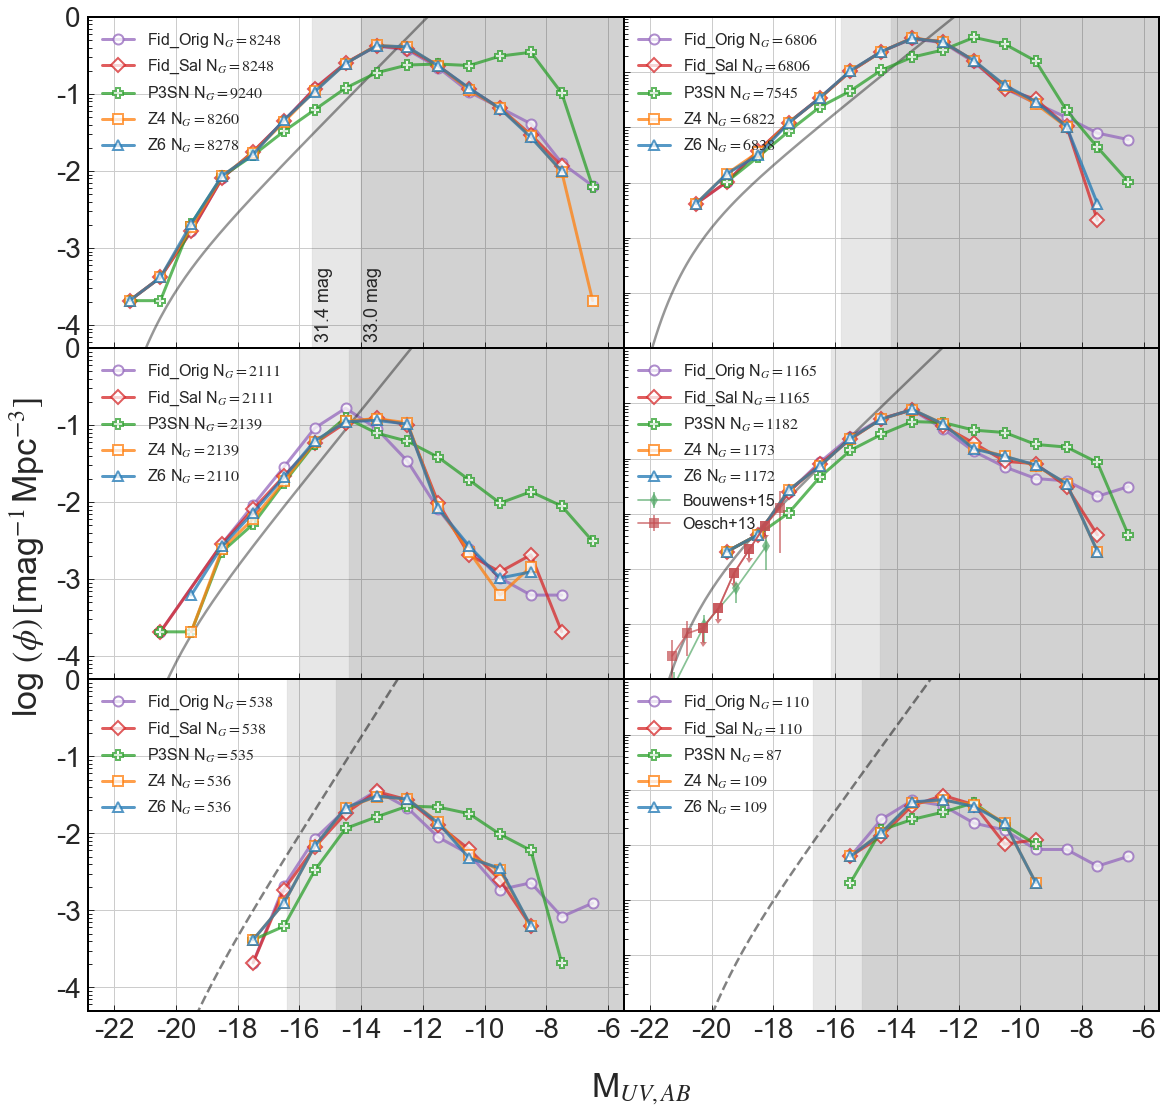

In [32]:
# Print LFs compared to Finkelstein projections... 
# Four plots in one figure

sns.set(style="whitegrid", font_scale=2,color_codes=True)
sns.set_style({'axes.edgecolor': '0.0','axes.linewidth': 2.0})
colors = ['#1f77b4',
 '#ff7f0e',
 '#2ca02c',
 '#d62728',
 '#9467bd'#,
         ]

plotSyms = ['o','D','P','s','^','*']
brightM = -22 # Plot range... 
limitM  = -6
magBins = np.linspace(brightM,limitM,(-brightM+limitM)*1+1) 
plotBins= np.linspace(-22,-7,16)

jwstUDC = 31.4
jwstUDC2 = 33.0

fig, axs = plt.subplots(nrows=3, ncols=2, sharex='col',sharey='row',figsize=(16,15))
done = False
for ps,c,dir in zip(plotSyms,reversed(colors),sorted(runs)):
    for z,ax in zip(np.sort([7,8,9,10,12,15]), axs.reshape(-1)):

        if z not in thezs:
            continue;
        # Convert observed magnitude to Absolute ...
        absMag, pop3Mag, nmAbsMag       = compMags(dir,z)

        # Get the JWST ultra-deep campaign limit
        jwstUDCM= jwstUDC - 2.5*np.log10((1.0+z)**-1*(cosmo.luminosity_distance(z).to(u.pc)/(10.0 * u.pc))**2)
        jwstUDC2M= jwstUDC2 - 2.5*np.log10((1.0+z)**-1*(cosmo.luminosity_distance(z).to(u.pc)/(10.0 * u.pc))**2)
#         print("JWST lim {:.1f}".format(jwstUDCM))
#         print("JWST lim {:.1f}".format(jwstUDC2M))
        Ng = len(absMag) # Number of galaxies at this z

        rgForSFunc = np.arange(brightM,limitM, 0.1) # Smooth Schechter (Finkelstein data) curve... 

        dx = np.diff(magBins)
#         print("Bin size is {}".format(dx[0]))

        # GENERATE THE HISTOGRAM and HISTOGRAM DATA in the array 'n' for
        # both the improved Pop III luminosity and the classical
        n, binsA = np.histogram(absMag,bins=magBins, density=False)
        nNM, binsANM = np.histogram(nmAbsMag,bins=magBins, density=False)
        print(z,n)

        n_orig = n
        n = n/dx/simVol
        nNM = nNM/dx/simVol


        ################################
        # Replace zero halos in a bin with
        # nan ... since we are undersampled
        ################################
        AllNonZero    = np.nonzero(n)  # Define a mask of non-zero values
        AllNonZeroNM  = np.nonzero(nNM)  # Define a mask of non-zero values

        # With Evans help
#         sigma_nu_for_bins = sigma_nu(dir,z,absMag,plotBins)
# #         print("sigma_nu for bins",sigma_nu_for_bins)
#         # Without cosmic variance we'd have sqrt(1/n_orig) * n_orig/dx/simVol = sqrt(n_orig)/dx/SimVol
#         err_w_var = np.sqrt(sigma_nu_for_bins**2 + 1/n_orig) * n_orig/dx/simVol # Error: sqrt term, signal: n/dx/simVol
# #         print("Errors: ",err_w_var)
#         err_w_var_dwn = err_w_var # In case err_w_var puts us less than 0
#         err_w_var_dwn[n-err_w_var_dwn <= 0.0] = n[n-err_w_var_dwn <= 0] - 5e-5 # which extends error to the plot's lower limit
# #         print("Corrected lower Errors: ",err_w_var_dwn)

        # Find bin-centers
        binDeltaA = (binsA[0]-binsA[1])/2.0
        binCentersA = binsA[1::]+binDeltaA

        if dir == "Fiducial":
            label = dir+r' $z={:.2f}$, N$_G={}$'.format(z,Ng)
        else:
            label = dir+r' N$_G={}$'.format(Ng)
        mec = mpl.colors.colorConverter.to_rgba(c, alpha=0.9)
        # So here we are only plotting non-zero values -- and connecting them with a line.
        # So there are dropouts in this data that we are ignorning! I think this is ok since
        # we are sampling a small volume and are gonna miss halos in the intermediate mags
        ax.plot(binCentersA[AllNonZero],n[AllNonZero],markeredgewidth=2.0,
                ls='-',marker=ps, c=c, alpha=0.75,markerfacecolor="w",
                markersize=10,lw=3.0,mec=mec,label=label)
        if z >= 16:
            ax.plot(binCentersA[AllNonZeroNM],nNM[AllNonZeroNM],markeredgewidth=2.0,
                ls='-',marker='^', c='C2', alpha=0.9,markerfacecolor="w",
                markersize=10,lw=3.0,mec='C2',label=r'Classical Pop III'.format(z,Ng))
            ax.fill_between(binCentersA[AllNonZeroNM],n[AllNonZeroNM]+err_w_var[AllNonZeroNM],
                            nNM[AllNonZeroNM]-err_w_var_dwn[AllNonZeroNM],
                            color='C2', alpha=0.2)
#         ax.fill_between(binCentersA[AllNonZero],n[AllNonZero]+err_w_var[AllNonZero],
#                         n[AllNonZero]-err_w_var_dwn[AllNonZero],
#                         color=c, alpha=0.15)

        if not done:
            ax.axvspan( jwstUDCM, limitM+0.5, alpha=0.1, color='k')
            ax.axvspan( jwstUDC2M, limitM+0.5, alpha=0.1, color='k')
        if z in [7] and not done:
            ax.annotate('31.4 mag', xy = (0.5, 0.5), xytext = (jwstUDCM+0.1, 6e-5), xycoords='axes fraction',
                textcoords = 'data', ha = 'left', va = 'bottom',fontsize=18, rotation=90)
            ax.annotate('33.0 mag', xy = (0.5, 0.5), xytext = (jwstUDC2M+0.1, 6e-5), xycoords='axes fraction',
                textcoords = 'data', ha = 'left', va = 'bottom',fontsize=18, rotation=90)

        # Format plt
        ax.set_xscale('linear')
        ax.set_yscale('log')
        ax.yaxis.set_major_formatter(logfmt)
        ax.set_xlim([brightM-0.85,limitM+0.5])
        ax.set_xticks(np.arange(brightM,limitM+1,2))
        ax.set_xticklabels([str(i) for i in np.arange(brightM,limitM+1,2)])
        ax.set_ylim([5e-5,1])
        ax.set_yticks([1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,1])
        ax.xaxis.set_tick_params(which='both',width=1,length=6,direction='in',labelsize=28)
        ax.yaxis.set_tick_params(which='major',width=1,length=6,direction='in',labelsize=28)
        ax.yaxis.set_tick_params(which='minor',width=1,length=4,direction='in')

        #     plt.gca().invert_xaxis()
        gc.collect()

        if z > 10 and (not done):
            ax.plot(rgForSFunc, schechterM_forFit(finkel[z], rgForSFunc),'k--',lw=2.5,alpha=0.55)
        elif not done:
            ax.plot(rgForSFunc, schechterM_forFit(finkel[z], rgForSFunc),'k-',lw=2.5,alpha=0.45)

        if z==10 and not done:
    #         print("To logErrFix:",(10**bouwens15[:,1],bouwens15[:,2]),(10**bouwens15[:,1],bouwens15[:,3]))

            ax.errorbar(bouwens15[:,0],10**bouwens15[:,1], yerr=[logErrFix(10**bouwens15[:,1],bouwens15[:,2]),
                                                             logErrFix(10**bouwens15[:,1],bouwens15[:,3])],
                        marker='d',c='C1',alpha=0.7, markersize=10, mec='None',
                        label=r'Bouwens+15')
            ax.errorbar(oesch13[:,0],10**oesch13[:,1], yerr=[logErrFix(10**oesch13[:,1],oesch13[:,2]),
                                                             logErrFix(10**oesch13[:,1],oesch13[:,3])],
                        marker='s',c='C2',alpha=0.7,markersize=10,mec='k',label=r'Oesch+13'.format(z,Ng))
            ax.errorbar(oesch13[2:7,0],10**oesch13[2:7,1], yerr=[logErrFix(10**oesch13[2:7,1],oesch13[2:7,2]),
                                                             logErrFix(10**oesch13[2:7,1],oesch13[2:7,3])],
                        marker='s',c='C2',alpha=0.7,markersize=10,mec='k',uplims=True)
        # Add O'Shea data if available
        if z in OShea and dir=='fw1':
            ax.plot(OShea[z][:,0][OShea[z][:,0] < -14],OShea[z][:,1][OShea[z][:,0] < -14],ls='-.',marker='s',
                    markeredgewidth=2.0,markerfacecolor="w",c='k', ms=8, lw=3.0,alpha=0.5, label='O`Shea+15')
        ax.legend(loc=2, fontsize=16, numpoints=1 )

    done = True

fig.text(0.55, 0.00,'M$_{UV,AB}$', ha='center',size=34, )
fig.text(0.00, 0.5, r'log $(\phi)\, [$mag$^{-1}\, $Mpc$^{-3}]$',size=34,
         va='center', rotation='vertical')
plt.subplots_adjust(left=0.07, bottom=0.08, right=1.0, top=1.0, wspace=.0, hspace=.0)
plt.savefig("haloUVMag_Summary_scatter-extended.pdf",dpi=fig.dpi,bbox_inches='tight')
gc.collect()

In [47]:
# Print LFs compared to Finkelstein projections... 
# Four plots in one figure

brightM = -22 # Plot range... 
limitM  = -13
magBins = np.linspace(brightM,limitM,(-brightM+limitM)*1+1) 
plotBins= np.linspace(-22,-14,9)
dx = np.diff(magBins)

absMag, pop3Mag, nmAbsMag       = compMags('Fiducial',7)
n, binsA = np.histogram(absMag,bins=magBins, density=False)
n_orig = n
n = n/dx/simVol
good    = np.nonzero(n)  # Define a mask of non-zero values
fiducial = n[good]

absMag, pop3Mag, nmAbsMag       = compMags('P3SN',7)
n, binsA = np.histogram(absMag,bins=magBins, density=False)
n_orig = n
n = n/dx/simVol
good    = np.nonzero(n)  # Define a mask of non-zero values
p3SN = n[good]

gc.collect()

Convert to Abs Mag. DM = 46.99 @ z=7.0
Convert to Abs Mag. DM = 46.99 @ z=7.0


/Users/earnric/.conda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:7: RuntimeWarning: divide by zero encountered in log10


23399

In [49]:
fiducial-p3SN

array([  0.000e+00,   2.071e-04,  -4.142e-04,  -4.142e-04,   1.864e-03,
         1.181e-02,   5.634e-02,   1.342e-01,   2.287e-01])

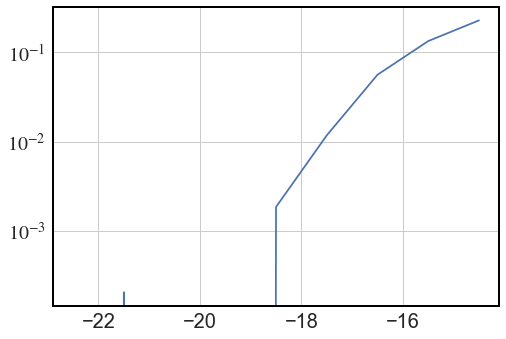

In [50]:
plt.plot(binCentersA[good],fiducial-p3SN[good])
plt.yscale('log')

# Plot histograms of stellar ages... 

In [22]:
haloData['Fid_Orig'][10].dtype.names

('halo',
 'r_v',
 'ZZsun',
 'ZPZsun',
 'MstarMsun',
 'M3StarMsun',
 'M3YngMsun',
 '1500A',
 '1500A_P3',
 '1500A_NM',
 '1500A_P3NM',
 '1500A_10pc',
 '1500A_P3_10pc')

In [23]:
# Load star particle data

fid_o_stars = {}
p3sn_stars = {}

for z in thezs:
    locs, mass, bt, Z, PZ, PPF = lsp.loadSP(z,prefix='./fid/',normedLocs=True,gz=True)
    fid_o_stars[z] = [locs, mass, bt, Z, PZ, PPF]

    locs, mass, bt, Z, PZ, PPF = lsp.loadSP(z,prefix='./p3SN/',normedLocs=True,gz=True)
    p3sn_stars[z] = [locs, mass, bt, Z, PZ, PPF]
    print('loaded {}'.format(z))


loaded 15
loaded 12
loaded 10
loaded 9
loaded 8
loaded 7


In [24]:
# Assumes bt array is in yr
# Return Myr
def age(z,bt):
    return (cosmo.age(z) - ((bt/1e9)*u.Gyr)).to(u.Myr)

In [25]:
fid_o_p3_stars = {}
p3sn_p3_stars = {}

for z in thezs:
    fid_o_stars[z][5][fid_o_stars[z][5] < 1e-5] = 0.0 
    fid_o_p3_stars[z] = [fid_o_stars[z][1] * fid_o_stars[z][5], age(z,fid_o_stars[z][2])] # [mass,age]
    
    p3sn_stars[z][5][p3sn_stars[z][5] < 1e-5] = 0.0 
    p3sn_p3_stars[z] = [p3sn_stars[z][1] * p3sn_stars[z][5], age(z,p3sn_stars[z][2])]

In [26]:
fid_o_stars[10][5].min()

0.0

Text(0.5,1,'Fid Pristine Fraction')

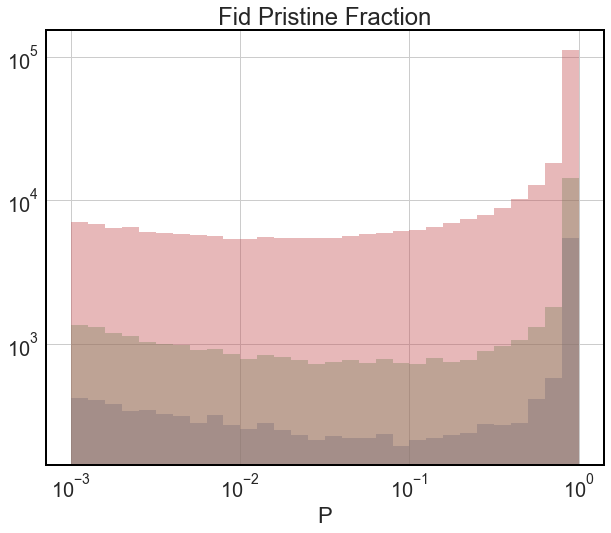

In [153]:
plt.hist(fid_o_stars[12][5],bins=np.logspace(-3,0,31),alpha=0.4)
plt.hist(fid_o_stars[10][5],bins=np.logspace(-3,0,31),alpha=0.4)
plt.hist(fid_o_stars[8][5],bins=np.logspace(-3,0,31),alpha=0.4)
plt.xscale('log')
plt.xlabel('P')
plt.yscale('log')
plt.title("Fid Pristine Fraction")

Text(0.5,1,'Fid Pop III Star Ages')

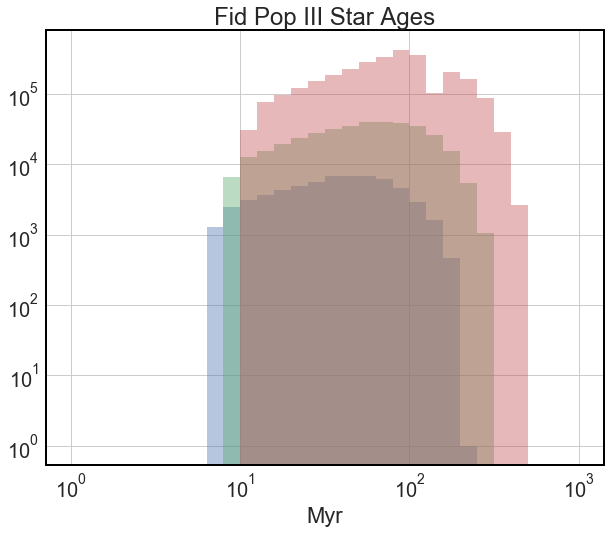

In [152]:
plt.hist(fid_o_p3_stars[12][1],bins=np.logspace(0,3,31),alpha=0.4)
plt.hist(fid_o_p3_stars[10][1],bins=np.logspace(0,3,31),alpha=0.4)
plt.hist(fid_o_p3_stars[8][1],bins=np.logspace(0,3,31),alpha=0.4)
plt.xscale('log')
plt.xlabel('Myr')
plt.yscale('log')
plt.title("Fid Pop III Star Ages")

Text(0.5,1,'Fid Pop III Star Ages')

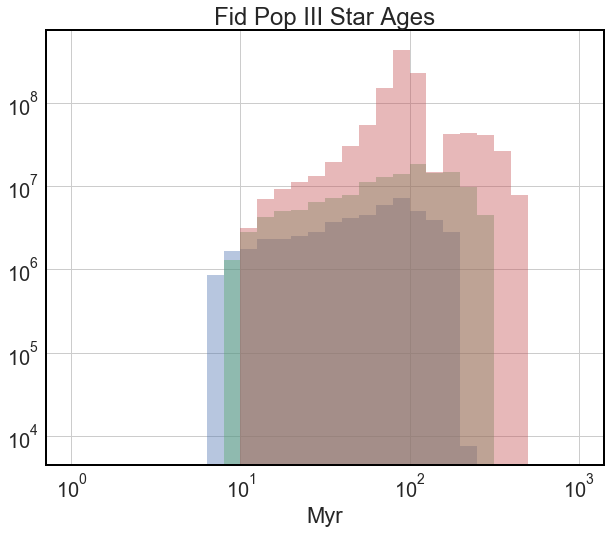

In [154]:
plt.hist(fid_o_p3_stars[12][1],bins=np.logspace(0,3,31),alpha=0.4,weights=fid_o_p3_stars[12][0])
plt.hist(fid_o_p3_stars[10][1],bins=np.logspace(0,3,31),alpha=0.4,weights=fid_o_p3_stars[10][0])
plt.hist(fid_o_p3_stars[8][1],bins=np.logspace(0,3,31),alpha=0.4,weights=fid_o_p3_stars[8][0])
plt.xscale('log')
plt.xlabel('Myr')
plt.yscale('log')
plt.title("Fid Pop III Star Ages")

In [28]:
# Check ages
for z in thezs:
    print(z,(cosmo.age(z) - (fid_o_stars[z][2]/1e9)*u.Gyr).min().to(u.Myr))
    print(z,age(z,fid_o_stars[z][2]).min())

15 5.26932566943672 Myr
15 5.26932566943672 Myr
12 6.884224112006065 Myr
12 6.884224112006065 Myr
10 8.618425501149328 Myr
10 8.618425501149328 Myr
9 9.85968479611099 Myr
9 9.85968479611099 Myr
8 11.299047098314086 Myr
8 11.299047098314086 Myr
7 13.363311815757339 Myr
7 13.363311815757339 Myr


In [29]:
fid_o_halos = {}
p3sn_halos = {}

for z in thezs:
    pos, mass, radius = lsp.loadAllHalos(z,prefix='./fid/')
    fid_o_halos[z] = [pos, mass, radius]

    pos, mass, radius = lsp.loadAllHalos(z,prefix='./p3SN/')
    p3sn_halos[z] = [pos, mass, radius]
    print('loaded {}'.format(z))


loaded 15
loaded 12
loaded 10
loaded 9
loaded 8
loaded 7


In [30]:
p3sn_stars[10][0].min(),p3sn_halos[10][0].min() # Make sure we're on the same interval... 

(-0.499980584626938, -0.4998)

In [31]:
def halo_stars(haloLoc, radius, stars, masses, ages):
    vec_diff  = stars - haloLoc                 # Vector difference in location
    dists     = np.linalg.norm(vec_diff,axis=1) # Linear distance between stars and halo center
    # Keep stars (and assoc'd info) for stars NOT in this halo
    stars     = stars[dists < radius]
    masses    = masses[dists < radius]
    ages      = ages[dists < radius]
    return stars, masses, ages


In [32]:
#
# Create a data structure:
# {z: {halo_num: [stars, masses, ages],
#      halo_num: [stars, masses, ages], ... } }
#
fid_halo_stars = {}
p3sn_halo_stars = {}

for z in [15,12,10,9,8,7]:
    fid_all_stars = fid_o_stars[z]  # [locs, mass, bt, Z, PZ, PPF]
    p3sn_all_stars= p3sn_stars[z]
    fid_halo_stars[z]  = {}    # Setup dict of dicts... first index is z, next is halo number
    p3sn_halo_stars[z] = {}
    for i, (halo_pos, halo_rad) in enumerate(zip(fid_o_halos[z][0], fid_o_halos[z][2])): # [pos, mass, radius]
        stars, masses, ages = halo_stars(halo_pos, halo_rad, fid_all_stars[0], fid_all_stars[1], 
                                     age(z,fid_all_stars[2]).value)
        # Compute mass-weighted averaged age
        mean_age = (ages * masses).sum()/masses.sum()
        fid_halo_stars[z][i]= mean_age
        
        stars, masses, ages = halo_stars(halo_pos, halo_rad, p3sn_all_stars[0], p3sn_all_stars[1], 
                                     age(z,p3sn_all_stars[2]).value)
        mean_age = (ages * masses).sum()/masses.sum()
        p3sn_halo_stars[z][i]= mean_age
        
# p3sn_halo_stars[15]

/Users/earnric/.conda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:23: RuntimeWarning: invalid value encountered in double_scalars


KeyboardInterrupt: 

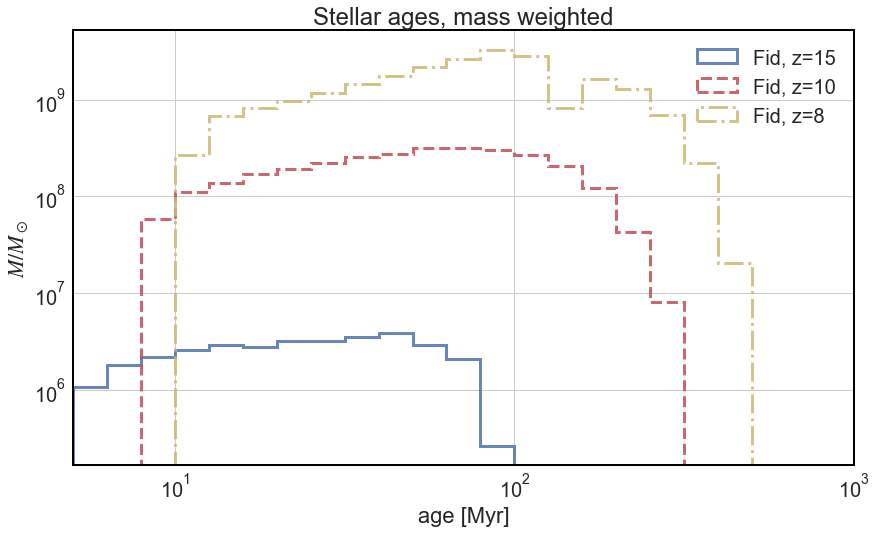

In [198]:
ageBins = np.logspace(0,3,31)

fig, ax4 = plt.subplots(nrows=1, ncols=1,figsize=(14,8))

# Age histograms, weighted by SP mass

n, bins, patches = ax4.hist(age(15,fid_o_stars[15][2]), bins=ageBins, weights=fid_o_stars[15][1],
                                histtype='step', lw=3,edgecolor='C0',alpha=0.85, label='Fid, z=15')
n, bins, patches = ax4.hist(age(10,fid_o_stars[10][2]), bins=ageBins, weights=fid_o_stars[10][1],
                                histtype='step', lw=3, ls="--",edgecolor='C2',alpha=0.85, label='Fid, z=10')
n, bins, patches = ax4.hist(age(8,fid_o_stars[8][2]), bins=ageBins, weights=fid_o_stars[8][1], 
                                histtype='step', lw=3,  ls="-.", edgecolor='C4',alpha=0.85, label='Fid, z=8')

ax4.set_xscale('log')
ax4.set_yscale('log')
# ax4.xaxis.set_major_formatter(logfmt)
# ax4.yaxis.set_major_formatter(logfmt)
# ax4.grid(b=True, which='major', color='b', linestyle='--')
# ax4.tick_params('both', length=5, width=1, which='minor')
# ax4.tick_params('both', length=8, width=1.5, which='major')
ax4.set_xlabel('age [Myr]')
ax4.set_ylabel(r'$M/M_\odot$')
ax4.set_xlim([5,1000])
# ax4.set_ylim([1e2,1e9])
plt.title("Stellar ages, mass weighted")
plt.legend()
# print("Mass weighted mean sp age {:.1f}".format((bins[1:] * n).sum()/n.sum()))

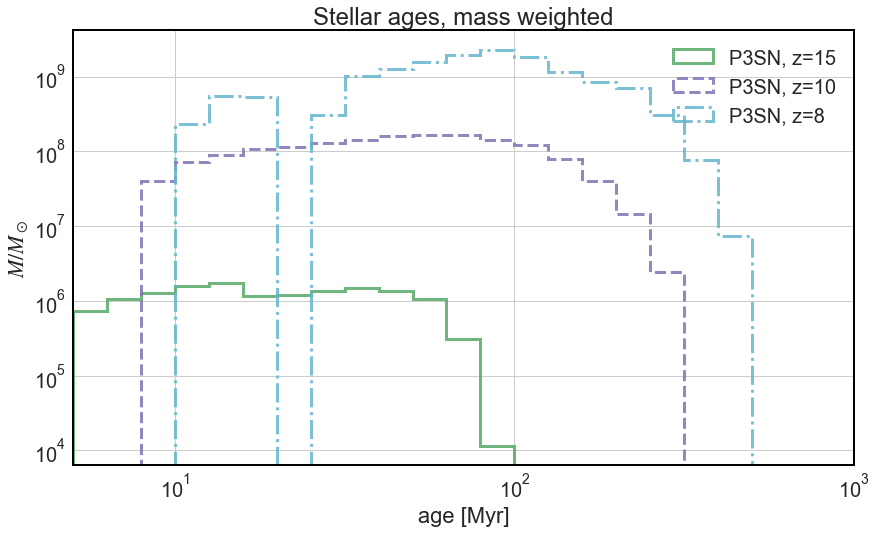

In [199]:
ageBins = np.logspace(0,3,31)

fig, ax4 = plt.subplots(nrows=1, ncols=1,figsize=(14,8))

# Age histograms, weighted by SP mass

n, bins, patches = ax4.hist(age(15,p3sn_stars[15][2]), bins=ageBins, weights=p3sn_stars[15][1], 
                                histtype='step', lw=3,edgecolor='C1',alpha=0.85, label='P3SN, z=15')
n, bins, patches = ax4.hist(age(10,p3sn_stars[10][2]), bins=ageBins, weights=p3sn_stars[10][1],
                                histtype='step', lw=3, ls="--",edgecolor='C3',alpha=0.85, label='P3SN, z=10')
n, bins, patches = ax4.hist(age(8,p3sn_stars[8][2]), bins=ageBins, weights=p3sn_stars[8][1], 
                                histtype='step', lw=3,  ls="-.", edgecolor='C5',alpha=0.85, label='P3SN, z=8')

ax4.set_xscale('log')
ax4.set_yscale('log')
# ax4.xaxis.set_major_formatter(logfmt)
# ax4.yaxis.set_major_formatter(logfmt)
# ax4.grid(b=True, which='major', color='b', linestyle='--')
# ax4.tick_params('both', length=5, width=1, which='minor')
# ax4.tick_params('both', length=8, width=1.5, which='major')
ax4.set_xlabel('age [Myr]')
ax4.set_ylabel(r'$M/M_\odot$')
ax4.set_xlim([5,1000])
plt.title("Stellar ages, mass weighted")
plt.legend()
# print("Mass weighted mean sp age {:.1f}".format((bins[1:] * n).sum()/n.sum()))

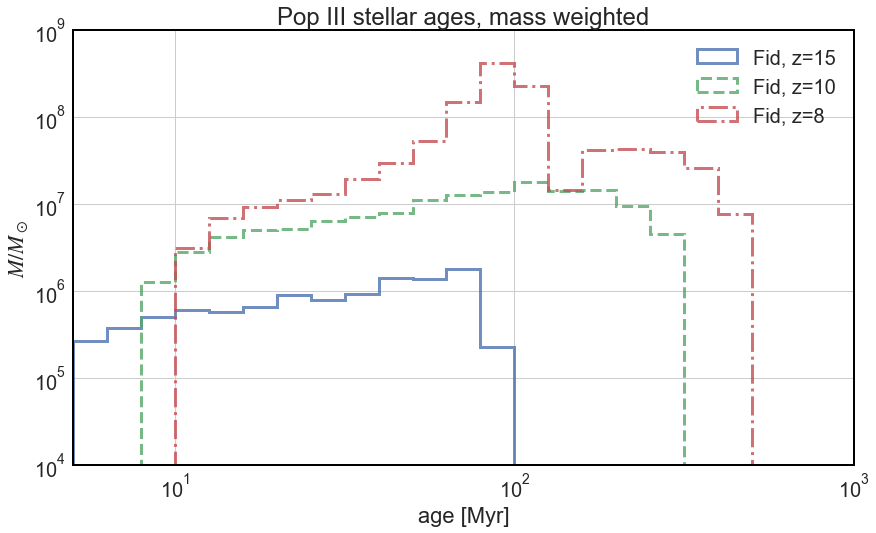

In [225]:
ageBins = np.logspace(0,3,31)

fig, ax4 = plt.subplots(nrows=1, ncols=1,figsize=(14,8))

# Pop III Stars only -- Age histograms, weighted by SP mass

n, bins, patches = ax4.hist(fid_o_p3_stars[15][1], bins=ageBins, weights=fid_o_p3_stars[15][0], 
                                histtype='step',lw=3,edgecolor='C0',alpha=0.8, label='Fid, z=15')
n, bins, patches = ax4.hist(fid_o_p3_stars[10][1], bins=ageBins, weights=fid_o_p3_stars[10][0], 
                                histtype='step',lw=3,ls="--",edgecolor='C1',alpha=0.8, label='Fid, z=10')
n, bins, patches = ax4.hist(fid_o_p3_stars[8][1], bins=ageBins, weights=fid_o_p3_stars[8][0], 
                                histtype='step',lw=3,ls="-.", edgecolor='C2',alpha=0.8, label='Fid, z=8')
ax4.set_xscale('log')
ax4.set_yscale('log')
# ax4.xaxis.set_major_formatter(logfmt)
# ax4.yaxis.set_major_formatter(logfmt)
# ax4.grid(b=True, which='major', color='b', linestyle='--')
# ax4.tick_params('both', length=5, width=1, which='minor')
# ax4.tick_params('both', length=8, width=1.5, which='major')
ax4.set_xlabel('age [Myr]')
ax4.set_ylabel(r'$M/M_\odot$')
ax4.set_xlim([5,1000])
plt.title("Pop III stellar ages, mass weighted")
ax4.set_ylim([1e4,1e9])
plt.legend()
# print("Mass weighted mean sp age {:.1f}".format((bins[1:] * n).sum()/n.sum()))

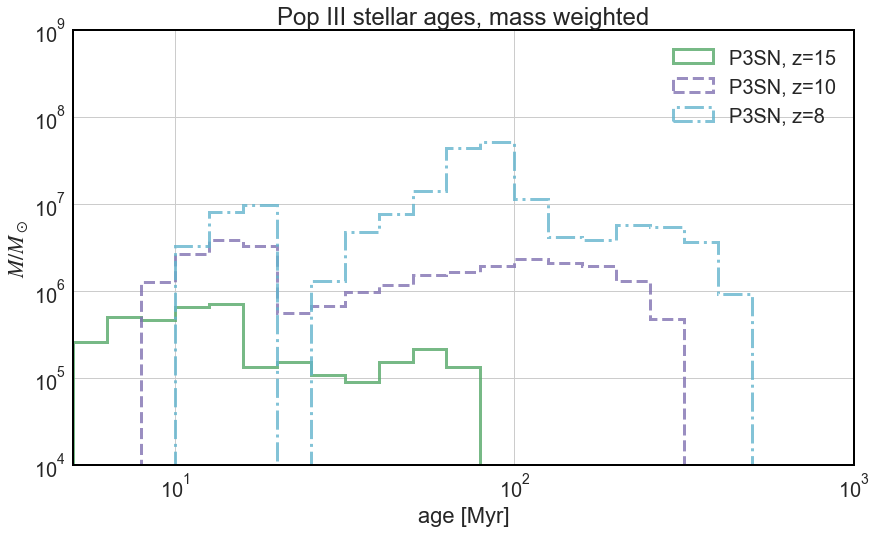

In [236]:
ageBins = np.logspace(0,3,31)

fig, ax4 = plt.subplots(nrows=1, ncols=1,figsize=(14,8))

# Pop III Stars only -- Age histograms, weighted by SP mass

n, bins, patches = ax4.hist(p3sn_p3_stars[15][1], bins=ageBins, weights=p3sn_p3_stars[15][0], 
                                histtype='step',lw=3,edgecolor='C1',alpha=0.8, label='P3SN, z=15')
n, bins, patches = ax4.hist(p3sn_p3_stars[10][1], bins=ageBins, weights=p3sn_p3_stars[10][0], 
                                histtype='step',lw=3,ls="--",edgecolor='C3',alpha=0.8, label='P3SN, z=10')
n, bins, patches = ax4.hist(p3sn_p3_stars[8][1], bins=ageBins, weights=p3sn_p3_stars[8][0], 
                                histtype='step', lw=3,ls="-.", edgecolor='C5',alpha=0.8, label='P3SN, z=8')
ax4.set_xscale('log')
ax4.set_yscale('log')
# ax4.xaxis.set_major_formatter(logfmt)
# ax4.yaxis.set_major_formatter(logfmt)
# ax4.grid(b=True, which='major', color='b', linestyle='--')
# ax4.tick_params('both', length=5, width=1, which='minor')
# ax4.tick_params('both', length=8, width=1.5, which='major')
ax4.set_xlabel('age [Myr]')
ax4.set_ylabel(r'$M/M_\odot$')
ax4.set_xlim([5,1000])
plt.title("Pop III stellar ages, mass weighted")
ax4.set_ylim([1e4,1e9])
plt.legend()
# print("Mass weighted mean sp age {:.1f}".format((bins[1:] * n).sum()/n.sum()))

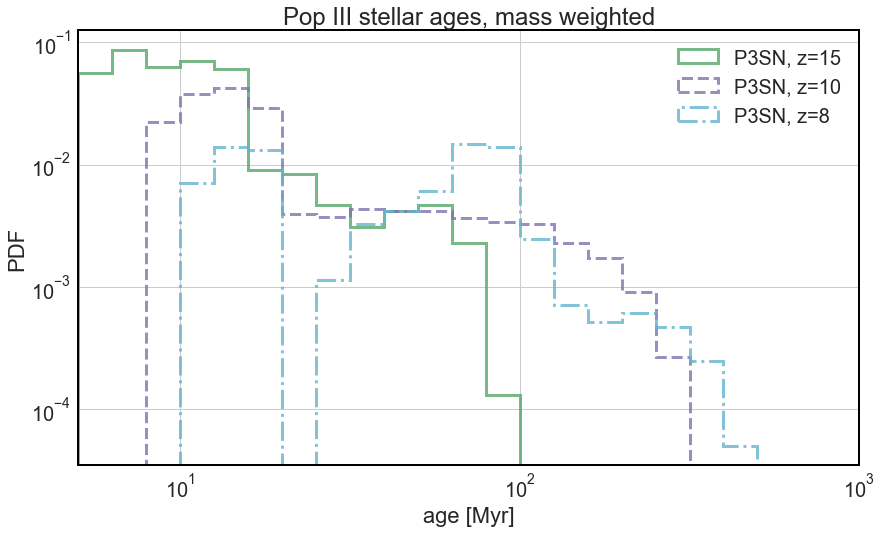

In [235]:
ageBins = np.logspace(0,3,31)

fig, ax4 = plt.subplots(nrows=1, ncols=1,figsize=(14,8))

# Pop III Stars only -- Age histograms, weighted by SP mass

# If True, the first element of the return tuple will be the counts normalized to form a probability density, 
#i.e., the area (or integral) under the histogram will sum to 1. This is achieved by dividing the count by the 
# number of observations times the bin width and not dividing by the total number of observations. If stacked 
# is also True, the sum of the histograms is normalized to 1.


n, bins, patches = ax4.hist(p3sn_p3_stars[15][1], bins=ageBins, weights=p3sn_p3_stars[15][0], density=True,
                                histtype='step',lw=3,edgecolor='C1',alpha=0.8, label='P3SN, z=15')
n, bins, patches = ax4.hist(p3sn_p3_stars[10][1], bins=ageBins, weights=p3sn_p3_stars[10][0], density=True,
                                histtype='step',lw=3,ls="--",edgecolor='C3',alpha=0.8, label='P3SN, z=10')
n, bins, patches = ax4.hist(p3sn_p3_stars[8][1], bins=ageBins, weights=p3sn_p3_stars[8][0], density=True,
                                histtype='step', lw=3,ls="-.", edgecolor='C5',alpha=0.8, label='P3SN, z=8')
ax4.set_xscale('log')
ax4.set_yscale('log')
# ax4.xaxis.set_major_formatter(logfmt)
# ax4.yaxis.set_major_formatter(logfmt)
# ax4.grid(b=True, which='major', color='b', linestyle='--')
# ax4.tick_params('both', length=5, width=1, which='minor')
# ax4.tick_params('both', length=8, width=1.5, which='major')
ax4.set_xlabel('age [Myr]')
ax4.set_ylabel(r'PDF')
ax4.set_xlim([5,1000])
plt.title("Pop III stellar ages, mass weighted")
# ax4.set_ylim([1e4,1e9])
plt.legend()
# print("Mass weighted mean sp age {:.1f}".format((bins[1:] * n).sum()/n.sum()))

In [ ]:
ageBins = np.logspace(0,3,31)

fig, ax4 = plt.subplots(nrows=1, ncols=1,figsize=(14,8))

# Pop III Stars only -- Age histograms, weighted by SP mass

n, bins, patches = ax4.hist(fid_o_p3_stars[15][1], bins=ageBins, weights=fid_o_p3_stars[15][0], density=True,
                                histtype='step',lw=3,edgecolor='C0',alpha=0.8, label='Fid, z=15')
n, bins, patches = ax4.hist(fid_o_p3_stars[10][1], bins=ageBins, weights=fid_o_p3_stars[10][0], density=True,
                                histtype='step',lw=3,ls="--",edgecolor='C1',alpha=0.8, label='Fid, z=10')
n, bins, patches = ax4.hist(fid_o_p3_stars[8][1], bins=ageBins, weights=fid_o_p3_stars[8][0], density=True,
                                histtype='step',lw=3,ls=":", edgecolor='C2',alpha=0.8, label='Fid, z=8')


ax4.set_xscale('log')
ax4.set_yscale('log')
# ax4.xaxis.set_major_formatter(logfmt)
# ax4.yaxis.set_major_formatter(logfmt)
# ax4.grid(b=True, which='major', color='b', linestyle='--')
# ax4.tick_params('both', length=5, width=1, which='minor')
# ax4.tick_params('both', length=8, width=1.5, which='major')
ax4.set_xlabel('age [Myr]')
ax4.set_ylabel(r'PDF')
ax4.set_xlim([5,1000])
plt.title("Pop III stellar ages, mass weighted")
plt.legend()
# print("Mass weighted mean sp age {:.1f}".format((bins[1:] * n).sum()/n.sum()))

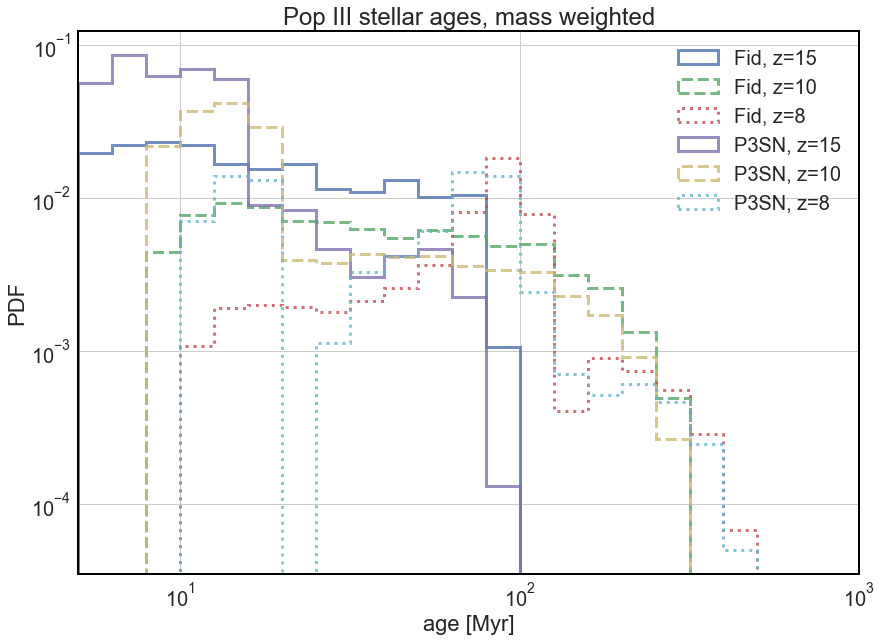

In [232]:
ageBins = np.logspace(0,3,31)

fig, ax4 = plt.subplots(nrows=1, ncols=1,figsize=(14,10))

# Pop III Stars only -- Age histograms, weighted by SP mass

n, bins, patches = ax4.hist(fid_o_p3_stars[15][1], bins=ageBins, weights=fid_o_p3_stars[15][0], density=True,
                                histtype='step',lw=3,edgecolor='C0',alpha=0.8, label='Fid, z=15')
n, bins, patches = ax4.hist(fid_o_p3_stars[10][1], bins=ageBins, weights=fid_o_p3_stars[10][0], density=True,
                                histtype='step',lw=3,ls="--",edgecolor='C1',alpha=0.8, label='Fid, z=10')
n, bins, patches = ax4.hist(fid_o_p3_stars[8][1], bins=ageBins, weights=fid_o_p3_stars[8][0], density=True,
                                histtype='step',lw=3,ls=":", edgecolor='C2',alpha=0.8, label='Fid, z=8')


n, bins, patches = ax4.hist(p3sn_p3_stars[15][1], bins=ageBins, weights=p3sn_p3_stars[15][0], density=True,
                                histtype='step',lw=3,edgecolor='C3',alpha=0.8, label='P3SN, z=15')
n, bins, patches = ax4.hist(p3sn_p3_stars[10][1], bins=ageBins, weights=p3sn_p3_stars[10][0], density=True,
                                histtype='step',lw=3,ls="--",edgecolor='C4',alpha=0.8, label='P3SN, z=10')
n, bins, patches = ax4.hist(p3sn_p3_stars[8][1], bins=ageBins, weights=p3sn_p3_stars[8][0], density=True,
                                histtype='step', lw=3,ls=":", edgecolor='C5',alpha=0.8, label='P3SN, z=8')

ax4.set_xscale('log')
ax4.set_yscale('log')
# ax4.xaxis.set_major_formatter(logfmt)
# ax4.yaxis.set_major_formatter(logfmt)
# ax4.grid(b=True, which='major', color='b', linestyle='--')
# ax4.tick_params('both', length=5, width=1, which='minor')
# ax4.tick_params('both', length=8, width=1.5, which='major')
ax4.set_xlabel('age [Myr]')
ax4.set_ylabel(r'PDF')
ax4.set_xlim([5,1000])
plt.title("Pop III stellar ages, mass weighted")
plt.legend()
# print("Mass weighted mean sp age {:.1f}".format((bins[1:] * n).sum()/n.sum()))

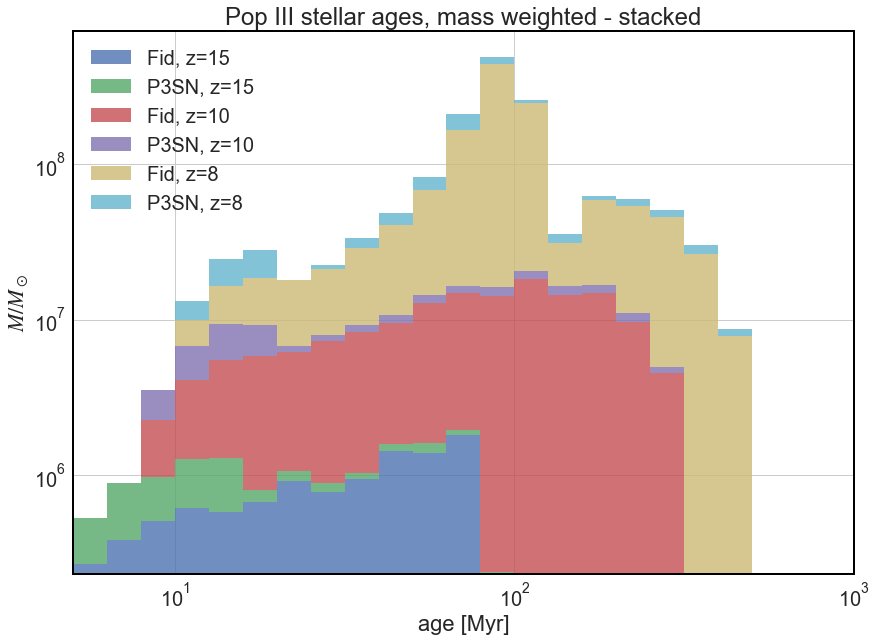

In [229]:
ageBins = np.logspace(0,3,31)

fig, ax4 = plt.subplots(nrows=1, ncols=1,figsize=(14,10))

# Pop III Stars only -- Age histograms, weighted by SP mass

n, bins, patches = ax4.hist([fid_o_p3_stars[15][1],p3sn_p3_stars[15][1],
                             fid_o_p3_stars[10][1],p3sn_p3_stars[10][1],
                             fid_o_p3_stars[8][1], p3sn_p3_stars[8][1]], #rwidth=0.9,
                             bins=ageBins, weights=[fid_o_p3_stars[15][0],p3sn_p3_stars[15][0],
                                                   fid_o_p3_stars[10][0],p3sn_p3_stars[10][0],
                                                   fid_o_p3_stars[8][0],p3sn_p3_stars[8][0]], 
                            lw=3,stacked=True,# density=True,
                            histtype='bar',alpha=0.8, label=['Fid, z=15','P3SN, z=15',
                                                                 'Fid, z=10','P3SN, z=10',
                                                                 'Fid, z=8','P3SN, z=8'])

ax4.set_xscale('log')
ax4.set_yscale('log')
# ax4.xaxis.set_major_formatter(logfmt)
# ax4.yaxis.set_major_formatter(logfmt)
# ax4.grid(b=True, which='major', color='b', linestyle='--')
# ax4.tick_params('both', length=5, width=1, which='minor')
# ax4.tick_params('both', length=8, width=1.5, which='major')
ax4.set_xlabel('age [Myr]')
ax4.set_ylabel(r'$M/M_\odot$')
ax4.set_xlim([5,1000])
plt.title("Pop III stellar ages, mass weighted - stacked")
plt.legend(loc=2)
# print("Mass weighted mean sp age {:.1f}".format((bins[1:] * n).sum()/n.sum()))

In [ ]:
ageBins = np.logspace(0,3,31)

fig, ax4 = plt.subplots(nrows=1, ncols=1,figsize=(14,10))

# Pop III Stars only -- Age histograms, weighted by SP mass

n, bins, patches = ax4.hist([fid_o_p3_stars[15][1],p3sn_p3_stars[15][1],
                             fid_o_p3_stars[10][1],p3sn_p3_stars[10][1],
                             fid_o_p3_stars[8][1], p3sn_p3_stars[8][1]], #rwidth=0.9,
                             bins=ageBins, weights=[fid_o_p3_stars[15][0],p3sn_p3_stars[15][0],
                                                   fid_o_p3_stars[10][0],p3sn_p3_stars[10][0],
                                                   fid_o_p3_stars[8][0],p3sn_p3_stars[8][0]], 
                            lw=3,stacked=True,
                            histtype='bar',alpha=0.8, label=['Fid, z=15','P3SN, z=15',
                                                                 'Fid, z=10','P3SN, z=10',
                                                                 'Fid, z=8','P3SN, z=8'])

ax4.set_xscale('log')
ax4.set_yscale('log')
# ax4.xaxis.set_major_formatter(logfmt)
# ax4.yaxis.set_major_formatter(logfmt)
# ax4.grid(b=True, which='major', color='b', linestyle='--')
# ax4.tick_params('both', length=5, width=1, which='minor')
# ax4.tick_params('both', length=8, width=1.5, which='major')
ax4.set_xlabel('age [Myr]')
ax4.set_ylabel(r'$M/M_\odot$')
ax4.set_xlim([5,1000])
plt.title("Pop III stellar ages, mass weighted - stacked")
plt.legend(loc=2)
# print("Mass weighted mean sp age {:.1f}".format((bins[1:] * n).sum()/n.sum()))

Mass weighted mean sp age 103.9


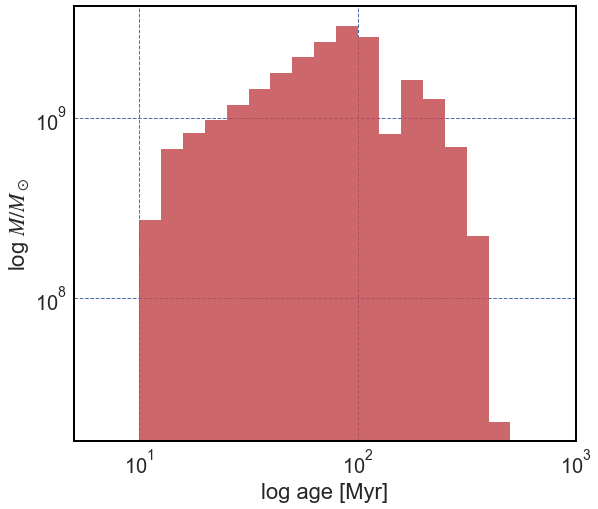

In [103]:
ageBins = np.logspace(0,3,31)

fig, ax4 = plt.subplots(nrows=1, ncols=1,figsize=(9,8))

n, bins, patches = ax4.hist(age(8,fid_o_stars[8][2]), bins=ageBins, weights=fid_o_stars[8][1], 
                                color='C2',alpha=0.85)
ax4.set_xscale('log')
ax4.set_yscale('log')
# ax4.xaxis.set_major_formatter(logfmt)
# ax4.yaxis.set_major_formatter(logfmt)
ax4.grid(b=True, which='major', color='b', linestyle='--')
# ax4.tick_params('both', length=5, width=1, which='minor')
# ax4.tick_params('both', length=8, width=1.5, which='major')
ax4.set_xlabel('log age [Myr]')
ax4.set_ylabel(r'log $M/M_\odot$')
ax4.set_xlim([5,1000])
print("Mass weighted mean sp age {:.1f}".format((bins[1:] * n).sum()/n.sum()))

Mass weighted mean sp age 158.1


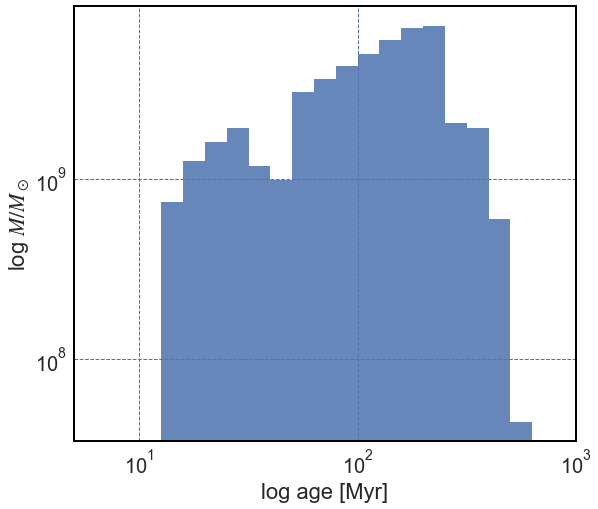

In [101]:
ageBins = np.logspace(0,3,31)

fig, ax4 = plt.subplots(nrows=1, ncols=1,figsize=(9,8))

n, bins, patches = ax4.hist(age(7,fid_o_stars[7][2]), bins=ageBins, weights=fid_o_stars[7][1], 
                                color='C0',alpha=0.85)
ax4.set_xscale('log')
ax4.set_yscale('log')
# ax4.xaxis.set_major_formatter(logfmt)
# ax4.yaxis.set_major_formatter(logfmt)
ax4.grid(b=True, which='major', color='b', linestyle='--')
# ax4.tick_params('both', length=5, width=1, which='minor')
# ax4.tick_params('both', length=8, width=1.5, which='major')
ax4.set_xlabel('log age [Myr]')
ax4.set_ylabel(r'log $M/M_\odot$')
ax4.set_xlim([5,1000])
print("Mass weighted mean sp age {:.1f}".format((bins[1:] * n).sum()/n.sum()))

In [36]:
# ##########################################################
# Normalizes the histogram's bar height by the bin width
# and co-moving volume of the simulation
# ##########################################################
def normBarHeight(bins, patches, cmvol, rotated=False):
    widths = np.diff(bins)
    for item,dx in zip(patches,widths):
#         print ("Starting height: %.5f bin width: %.2e"%(item.get_height(),dx))
        if not rotated:
            item.set_height(item.get_height()/dx/cmvol)
        else:
            item.set_width(item.get_width()/dx/cmvol)
#         print ("Ending width: %.5f"%item.get_width())
    return


In [37]:
np.logspace(-3,0.0,16),np.linspace(1e-3,1,18)

(array([ 0.001     ,  0.00158489,  0.00251189,  0.00398107,  0.00630957,
         0.01      ,  0.01584893,  0.02511886,  0.03981072,  0.06309573,
         0.1       ,  0.15848932,  0.25118864,  0.39810717,  0.63095734,  1.        ]),
 array([ 0.001     ,  0.05976471,  0.11852941,  0.17729412,  0.23605882,
         0.29482353,  0.35358824,  0.41235294,  0.47111765,  0.52988235,
         0.58864706,  0.64741176,  0.70617647,  0.76494118,  0.82370588,
         0.88247059,  0.94123529,  1.        ]))

In [24]:
runs

['P3SN', 'Fid_Sal', 'Fid_Orig', 'fw1', 'Z4', 'Z6']

Limiting absolute magnitude: -13
Convert to Abs Mag. DM = 46.99 @ z=7.0
Pop III flux fraction is 0.01257 at z=7
Working on z=7
Number of galaxies 9240
Largest bin value: 0.000, smallest -2.9595183769729982


/Users/earnric/.conda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:7: RuntimeWarning: divide by zero encountered in log10
/Users/earnric/.conda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:76: RuntimeWarning: divide by zero encountered in log10


Convert to Abs Mag. DM = 47.20 @ z=8.0
Pop III flux fraction is 0.03879 at z=8
Working on z=8
Number of galaxies 7545
Largest bin value: 0.000, smallest -2.9556877503135057
Convert to Abs Mag. DM = 47.38 @ z=9.0
Pop III flux fraction is 0.27213 at z=9
Working on z=9
Number of galaxies 2139
Largest bin value: 0.000, smallest -2.782472624166286
Convert to Abs Mag. DM = 47.54 @ z=10.0
Pop III flux fraction is 0.08795 at z=10
Working on z=10
Number of galaxies 1182
Largest bin value: 0.000, smallest -2.3541084391474008
Convert to Abs Mag. DM = 47.81 @ z=12.0
Pop III flux fraction is 0.31085 at z=12
Working on z=12
Number of galaxies 535
Largest bin value: 0.000, smallest -1.8976270912904414
Convert to Abs Mag. DM = 48.13 @ z=15.0
Pop III flux fraction is 0.59389 at z=15
Working on z=15
Number of galaxies 87
Largest bin value: 0.000, smallest -1.146128035678238
FINISHED with z=7-15
Convert to Abs Mag. DM = 46.99 @ z=7.0
Pop III flux fraction is 0.01257 at z=7
Working on z=7
****************

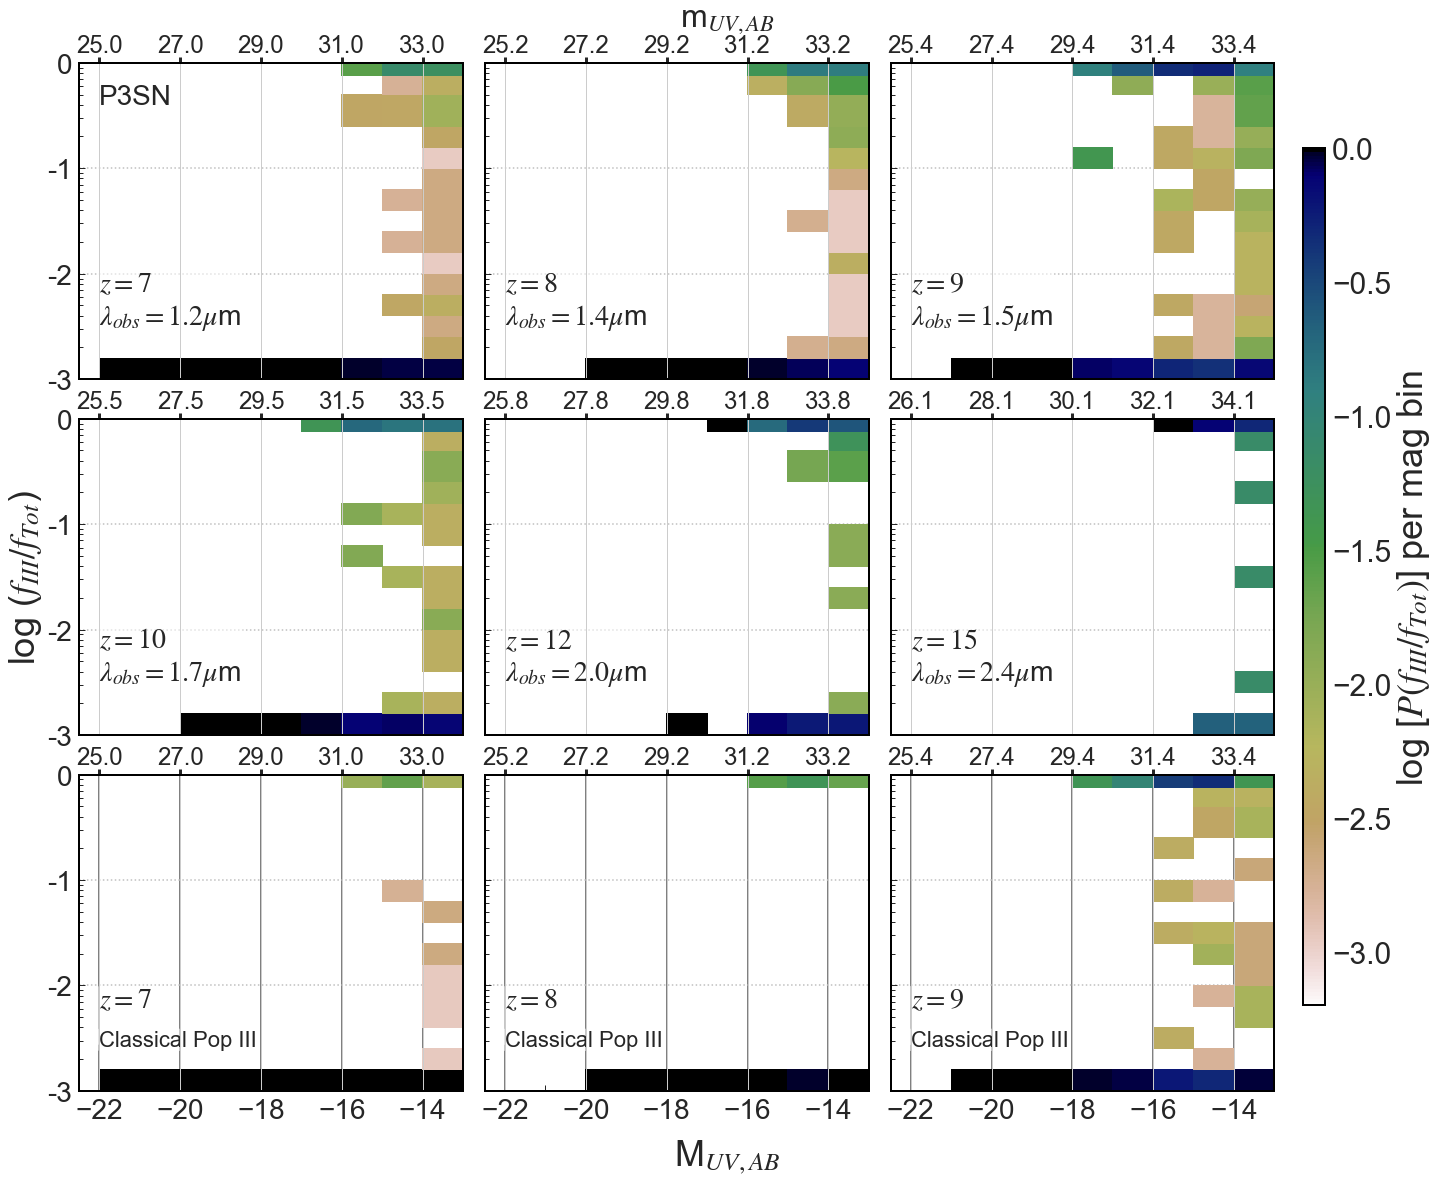

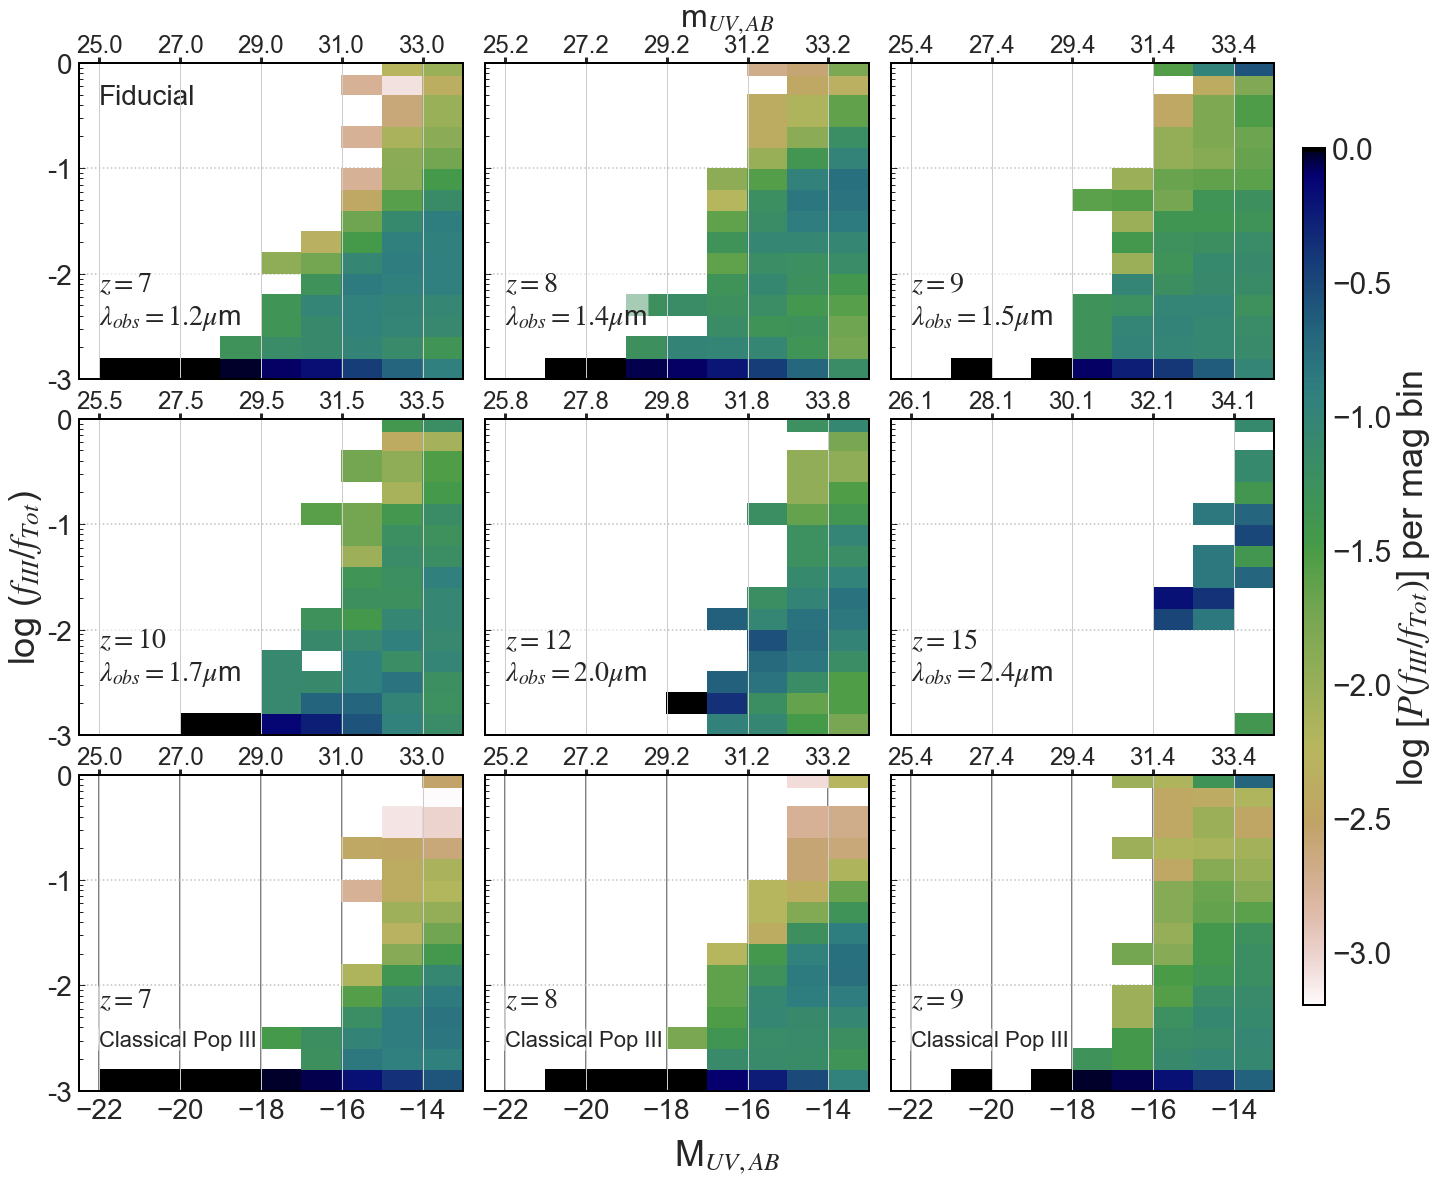

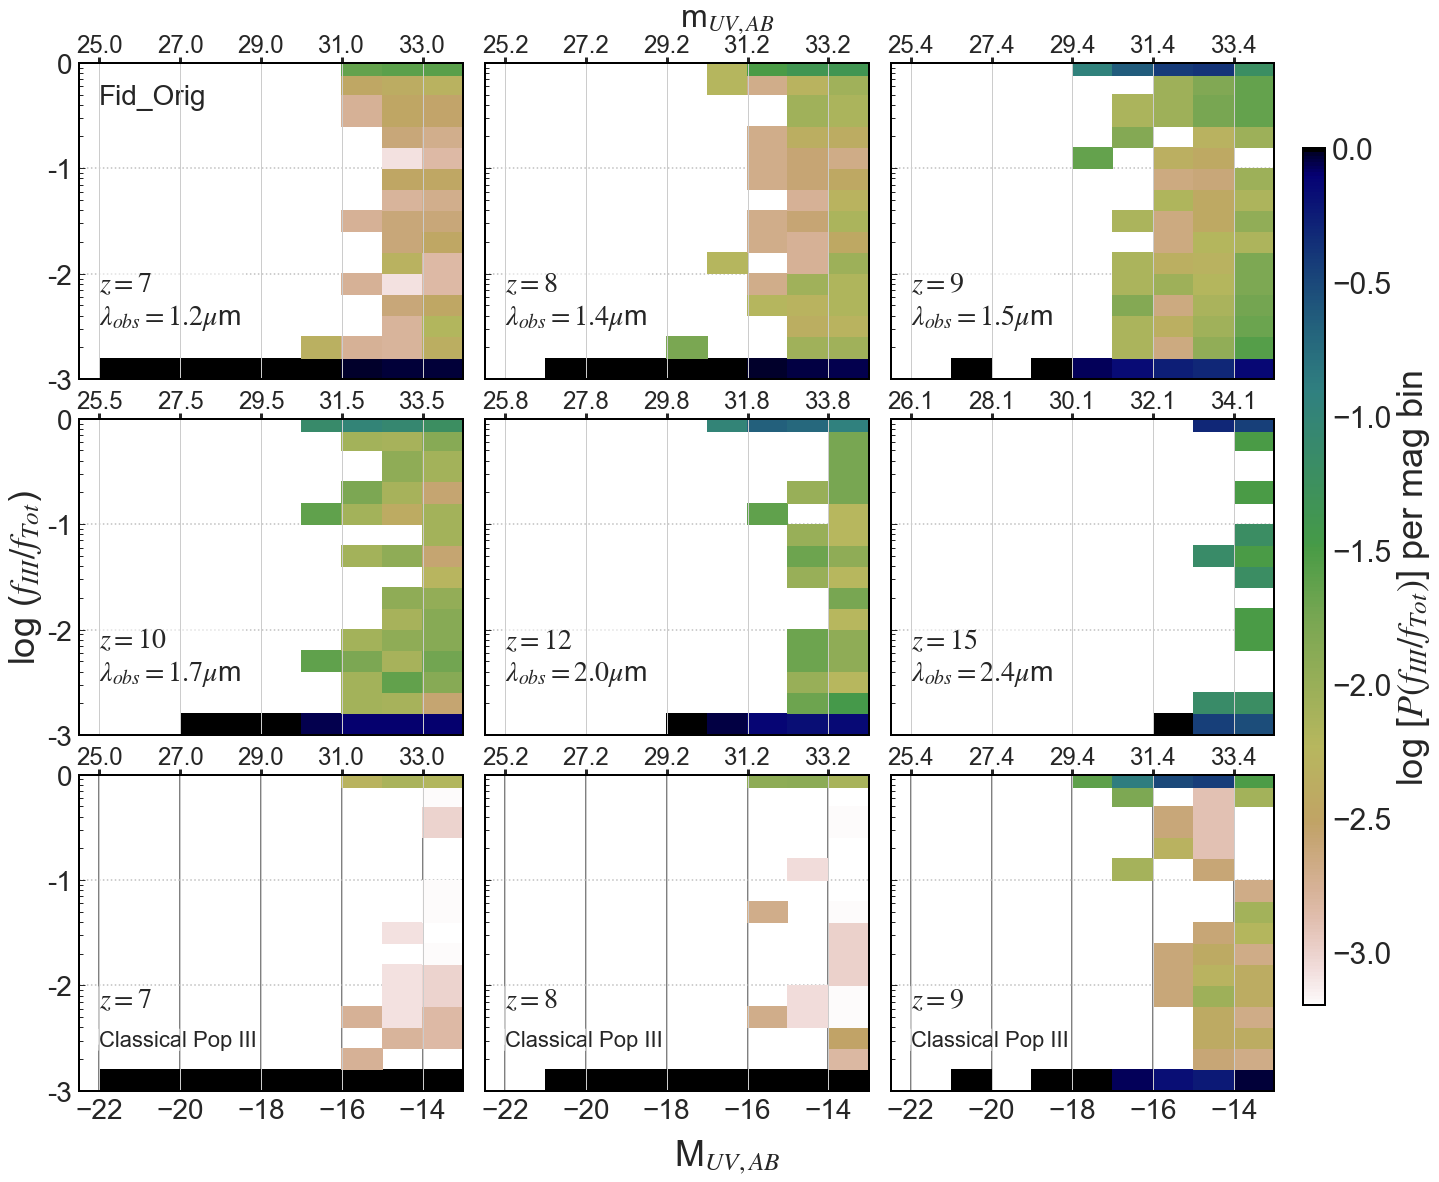

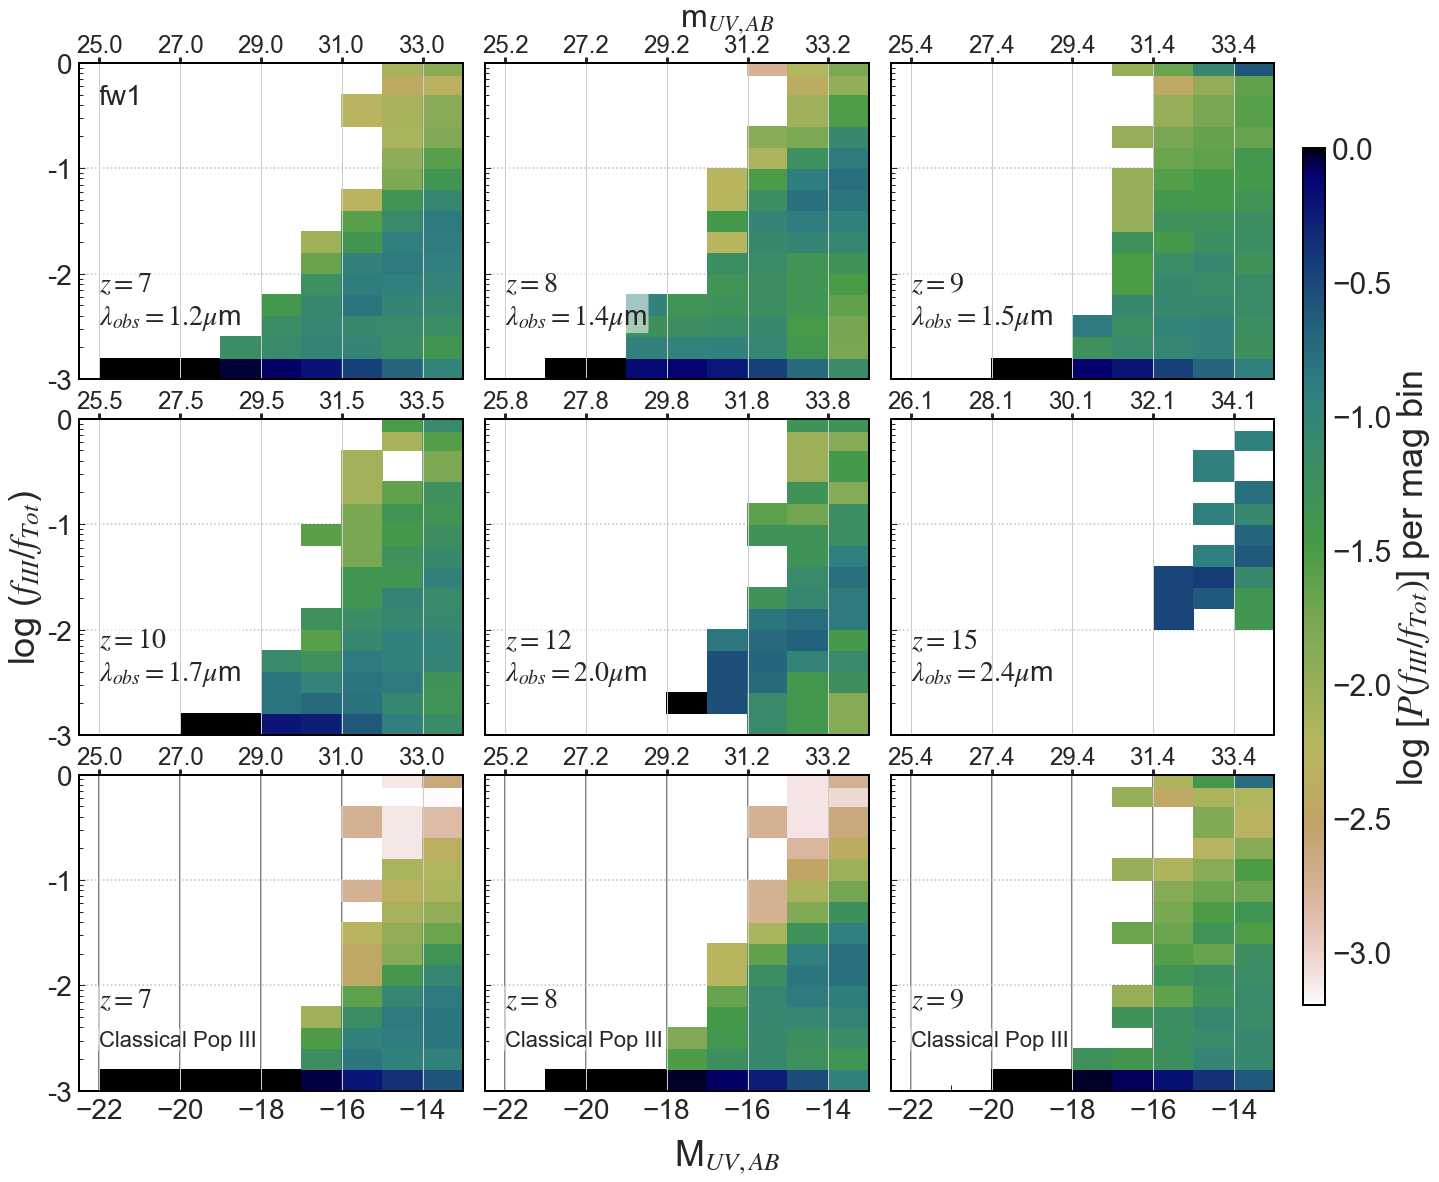

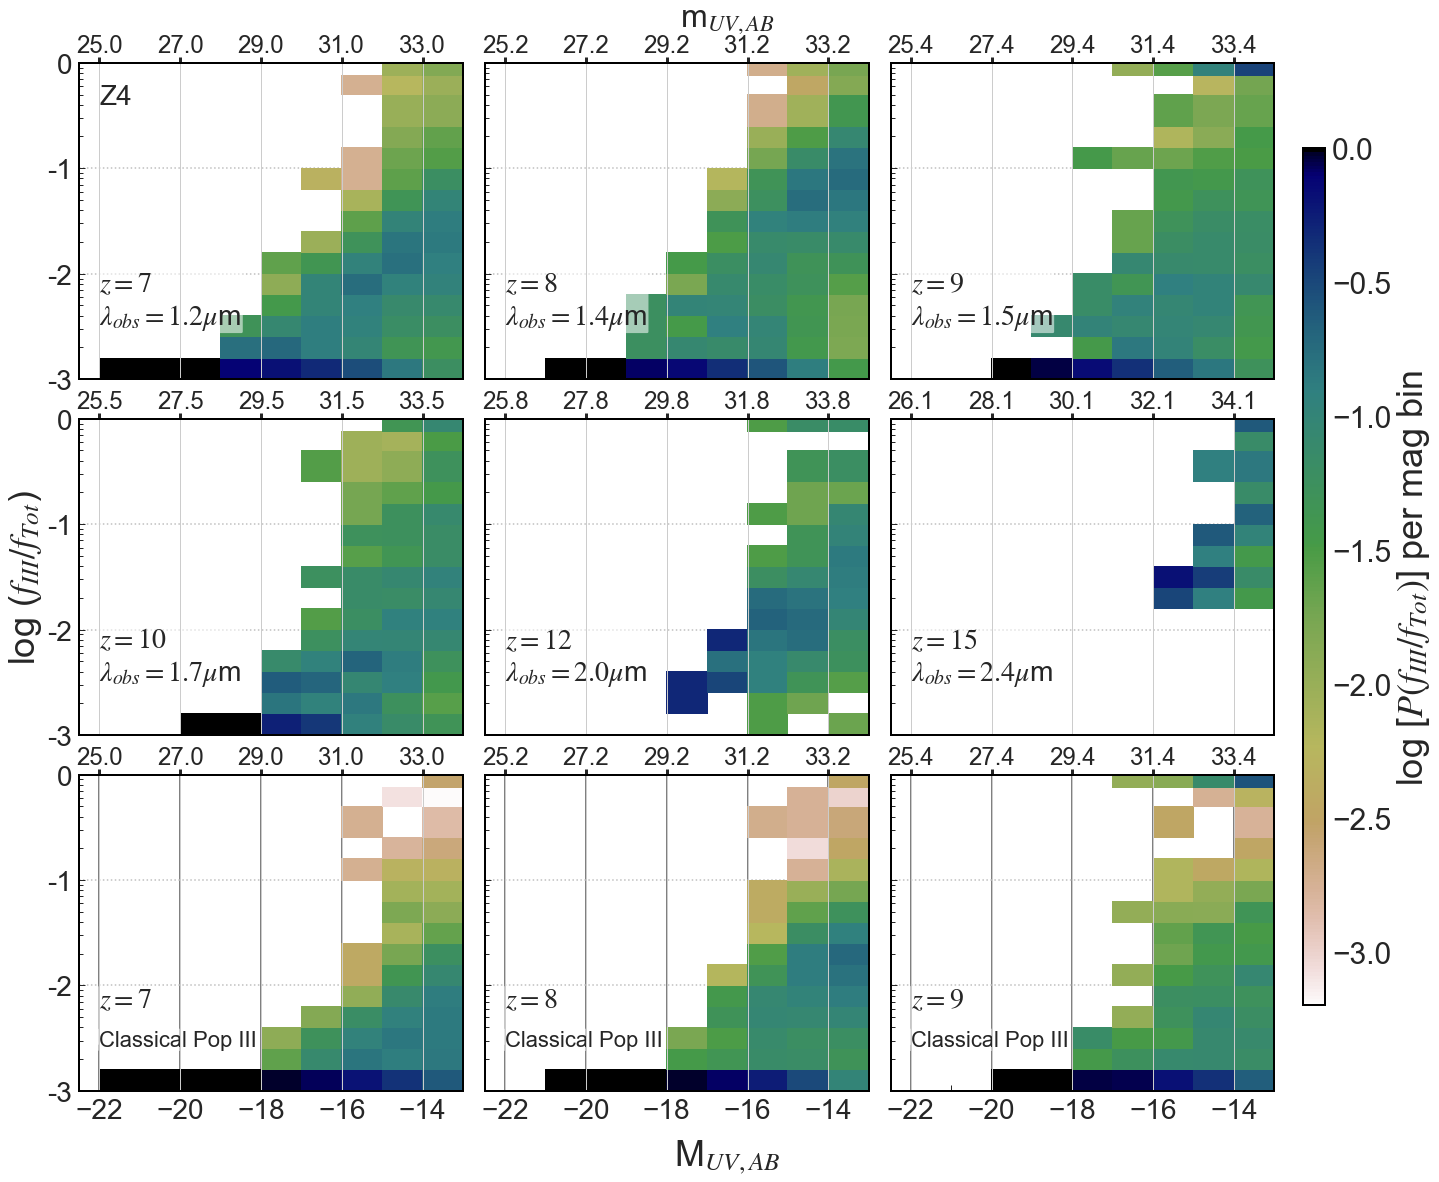

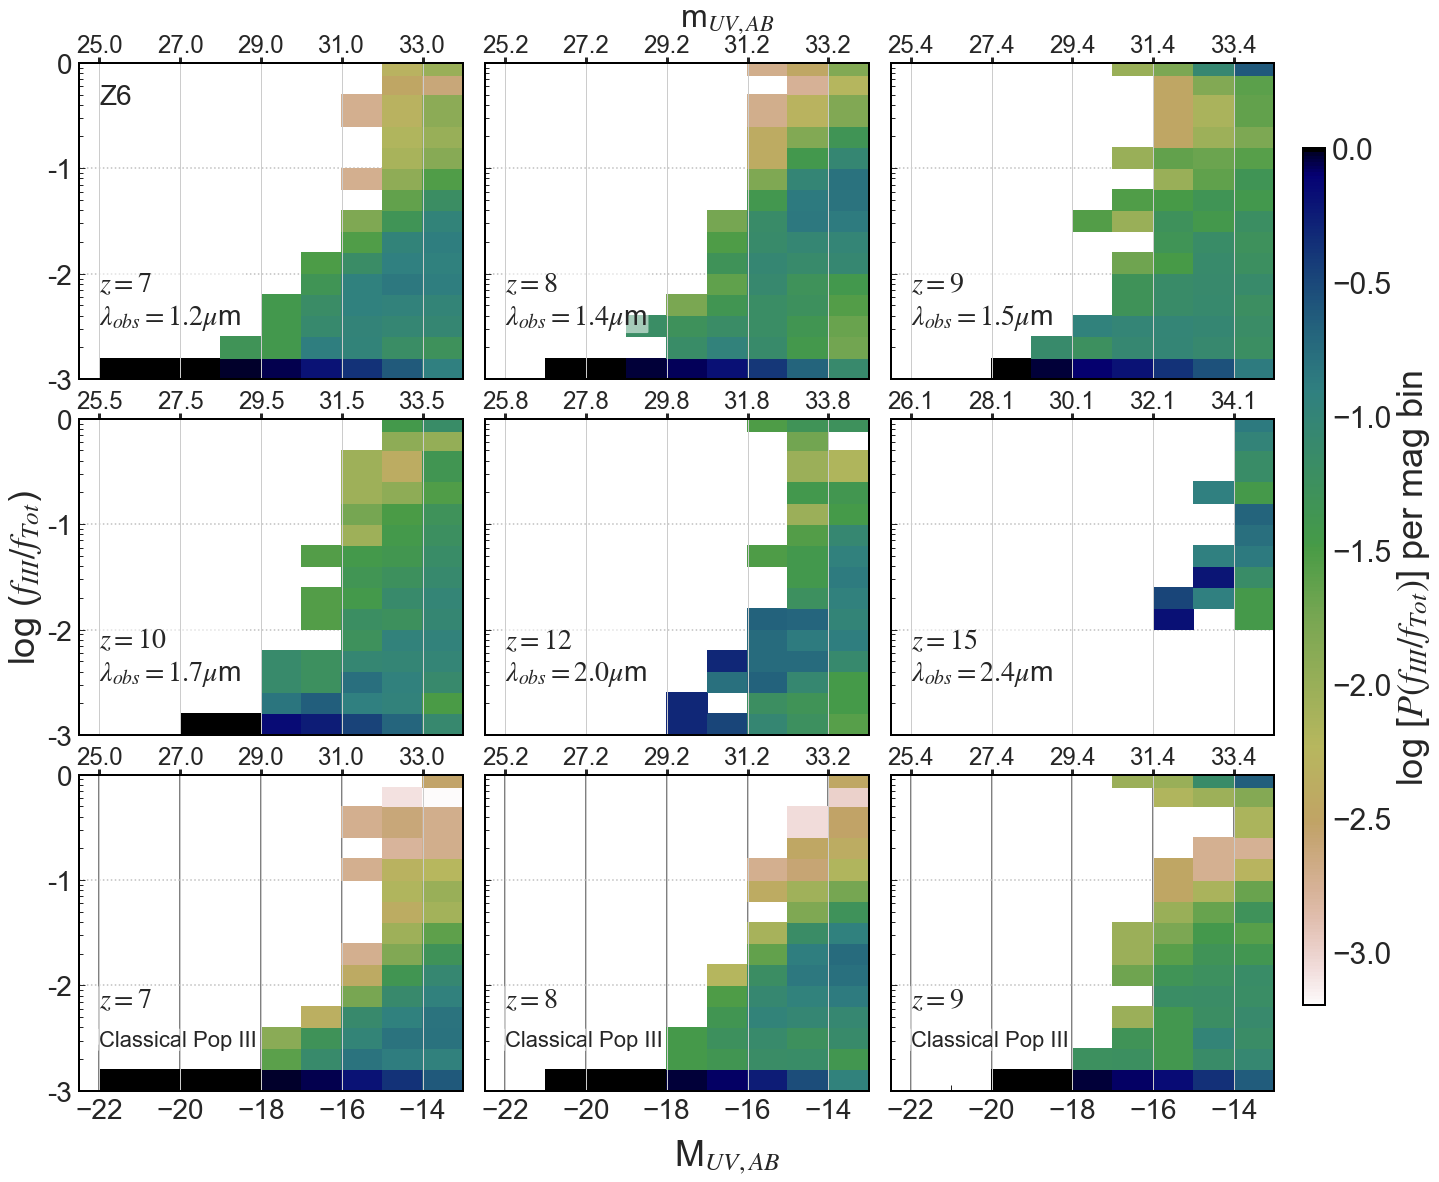

In [25]:
# Normalize the probability in each row such that it totals to 1.0

sns.set(style="whitegrid", font_scale=2, color_codes=True)
sns.set_style({'axes.edgecolor': '0.0','axes.linewidth': 2.0})

# Plot the fraction of Pop III magnitude vs M_AB NORMALIZED...

brightM = -22
limitM  = brightM+9
rgForSFunc = np.arange(brightM,limitM, 0.1)

magBins = np.linspace(brightM,limitM,(-brightM+limitM)*1 + 1) 
fracBins = np.logspace(-3,0,23)
# Contrived bin spacing such that the top bin represents .75-1.0 Pop III fraction
# and the next bin down represents .5-0.75 ...
fracBins = [0.001,  0.00158489,  0.00251189,  0.00398107,  0.00630957,
             0.01,  0.01584893,  0.02511886,  0.03981072,  0.06309573,
             0.1,  0.15848932,  0.25118864,
             0.5,   0.75,   1.0]
# fracBins = np.linspace(1e-3,9e-3,9).tolist() +np.linspace(1e-2,9e-2,9).tolist() +np.linspace(1e-1,1e-0,9).tolist()
print("Limiting absolute magnitude: {}".format(limitM))

p3ff ={}
p3ffMix = {}
doNMnow = False
for dir in runs:
    fig, axs = plt.subplots(nrows=3, ncols=3, sharex='col',sharey='row',figsize=(20,17))
    for z,ax in zip([7,8,9,10,12,15,7,8,9], axs.flat):

        if z not in thezs:
            continue

        # Convert observed magnitude to Absolute ...
        absMag, pop3Mag, nmAbsMag   = compMags(dir,z)
        # Map 0 Pop 3 flux to 1e-3... 
        pop3Fraction = haloData[dir][z]['1500A_P3']/haloData[dir][z]['1500A']
        p3ff[z] = haloData[dir][z]['1500A_P3'].sum()/haloData[dir][z]['1500A'].sum()
        print("Pop III flux fraction is {:.5f} at z={}".format(p3ff[z],z))
        pop3Fraction[pop3Fraction < 1e-3] = 1e-3  # Map Pop 3 flux < 1e-3 to 1e-3
        p3ffMix[z] = p3ff[z] # Make a copy so we can print both mixing and no-mix

        print("Working on z={}".format(z))
        # If we are back to z = 8,9,10 then generate plots for NO Mixing
        if doNMnow:
            print("************************************************************")
            print("Working on the NON MIXING flux fractions for or galaxies ...")
            print("************************************************************")
            pop3Fraction = haloData[dir][z]['1500A_P3NM']/haloData[dir][z]['1500A_NM']
            p3ff[z] = haloData[dir][z]['1500A_P3NM'].sum()/haloData[dir][z]['1500A_NM'].sum()
    #         print("Pop III flux fraction is {:.5f} at z={}".format(p3ffNM[z],z))
            pop3Fraction[pop3Fraction < 1e-3] = 1e-3  # Map Pop 3 flux < 1e-3 to 1e-3
            absMag = nmAbsMag ## Do plots for NO MIXING version of data... 
            print("z={} overall mixing p3ff={:.3f}, no mixing p3ff={:.3f}".format(z,p3ffMix[z],p3ff[z]))
            print("z={} PopIII mixing/no mixing={:.3f}".format(z,haloData[dir][z]['1500A_P3'].sum()/haloData[dir][z]['1500A_P3NM'].sum()))

        Ng = len(absMag) # Number of galaxies at this z
        print("Number of galaxies {}".format(Ng))
        # GENERATE THE HISTOGRAM and HISTOGRAM DATA in the array 'n' for
        # both the improved Pop III luminosity and the classical

        # Note that we are reversing x,y here since pcolormesh interprets them backwards!
        nTempA, binsx, binsy = np.histogram2d(pop3Fraction,absMag,bins=[fracBins,magBins],normed=False)
        # could use weights=[1/simVol for i in absMag] to normalize by vol here... 
        # normed : bool, optional
        #        If False, returns the number of samples in each bin. If True, returns the bin density 
        #        bin_count / sample_count / bin_area.

        X, Y = np.meshgrid(magBins, fracBins)  # Create a grid over the range of bins for the plot

        # Mask out 0 values before taking log10... 
        H = np.ma.masked_where(nTempA==0.0, nTempA)
        for i in range(len(H[0,:])):     # Column index i, over len of row 0
            colTot = np.sum(H[:,i])
            for j in range(len(H[:,0])): # Row index j, over len of column 0
                H[:,i][j] = H[:,i][j]/colTot
        H = np.log10(H)        # Take log of counts, we've already normalized by volume and area
        print("Largest bin value: {:.3f}, smallest {}".format(H.max(),H.min()))
        # Create the plot
        im = (ax.pcolormesh(X, Y, H, cmap=mpl.cm.gist_earth_r, vmin=-3.2, vmax=0) )

        ax.set_xscale('linear')
        ax.set_yscale('log')
        ax.yaxis.set_tick_params(which='major',width=1,length=6)
        ax.yaxis.set_tick_params(which='minor',width=1,length=4)
        ax.xaxis.set_tick_params(which='both',width=1,length=6)
        ax.xaxis.set_ticks(np.arange(brightM,limitM+1, 2))
        minorLocator = ticker.MultipleLocator(1)
        ax.xaxis.set_minor_locator(minorLocator)
        ax.get_yaxis().set_tick_params(which='both', direction='in',labelsize=28)
        ax.get_xaxis().set_tick_params(which='both', direction='in',labelsize=28)
        ax.yaxis.set_major_formatter(logfmt)
        ax.set_xlim([brightM-0.5,limitM])
        ax.set_ylim([1e-3,1.0])
        ax.grid(which='major', axis='y', color='0.75', linestyle=':', linewidth=1.5)
        ax.grid(which='major', axis='x', color='0.5', linestyle='-', linewidth=2.0)


        if doNMnow:
            ax.annotate('$z={}$\n'.format(z,0.15*(1+z)+0.0001), xy = (0.5, 0.5), 
                    xytext = (0.052, 0.15), xycoords='axes fraction',
                    bbox = {'boxstyle': 'round,pad=0.05', 'fc': 'w', 'ec': 'None', 'alpha': 0.55},
                    textcoords = 'axes fraction', ha = 'left', va = 'bottom',fontsize=28)
            ax.annotate('Classical Pop III'.format(z,0.15*(1+z)+0.0001), xy = (0.5, 0.5), 
                    xytext = (0.052, 0.13), xycoords='axes fraction',
                    bbox = {'boxstyle': 'round,pad=0.05', 'fc': 'w', 'ec': 'None', 'alpha': 0.55},
                    textcoords = 'axes fraction', ha = 'left', va = 'bottom',fontsize=22)
            ax.xaxis.set_visible(True)
        else:
            if z == 7:
                name = dir
                if dir == 'Fid_Sal':
                    name = 'Fiducial'
                ax.annotate('{}'.format(name), xy = (0.5, 0.5), 
                    xytext = (0.052, 0.85), xycoords='axes fraction',
                    bbox = {'boxstyle': 'round,pad=0.05', 'fc': 'w', 'ec': 'None', 'alpha': 0.55},
                    textcoords = 'axes fraction', ha = 'left', va = 'bottom',fontsize=28)
                
            ax.annotate('$z={}$\n$\lambda_{{obs}}={:.1f} \mu$m'.format(z,0.15*(1+z)+0.0001), xy = (0.5, 0.5), 
                    xytext = (0.052, 0.15), xycoords='axes fraction',
                    bbox = {'boxstyle': 'round,pad=0.05', 'fc': 'w', 'ec': 'None', 'alpha': 0.55},
                    textcoords = 'axes fraction', ha = 'left', va = 'bottom',fontsize=28)
            ax.xaxis.set_visible(False)
    #         ax.xaxis.set_ticks(np.arange(brightM,limitM+1, 1))
    #         minorLocator = ticker.MultipleLocator(1)
    #         ax.xaxis.set_minor_locator(minorLocator)
    #         ax.grid(which='both', axis='x', color='0.5', linestyle='-', linewidth=2.0)

        # Top x-axis labels ... m_ab
        ax2 = ax.twiny()
        ax2.set_xlim([brightM-0.5,limitM]) # required...
        axXtics = ax.get_xticks()
        ax2.set_xticks(axXtics)   # Set the location of the tics same as for ax
        ax2Xs = getMag(axXtics,z) # Convert M_ab -> m_ab
        ax2.set_xticklabels(["{:.1f}".format(i) for i in ax2Xs])
        ax2.xaxis.set_tick_params(which='major',width=3,length=6,direction='out',pad=0)
        ax2.get_xaxis().set_tick_params(labelsize=24)

        # plt.gca().invert_xaxis()
        gc.collect()
        ####
        #### If we just finished z=16, do z=8,9,10 for 
        #### no mixing case
        ####
        if z == 15:
            print("FINISHED with z=7-15")
            doNMnow = True

    plt.subplots_adjust(left=0.05, bottom=0.08, right=.88, top=0.92, wspace=.057, hspace=.125)

    fig.text(0.5, 0.95,'m$_{UV,AB}$', ha='center',size=32 )
    fig.text(0.5, 0.02,'M$_{UV,AB}$', ha='center',size=36 )
    fig.text(0.00, 0.5, r'log ($f_{III}/f_{Tot}$)',size=36,va='center', rotation='vertical')

    # Create the colorbar
    cbar_ax = fig.add_axes([0.9, 0.15, 0.015, 0.7])
    cbar = fig.colorbar(im, cax=cbar_ax)

    cbar.ax.tick_params(labelsize=30) 
    #cbar.ax.set_yticklabels(['1', '2', '4', '6', '10', maxCV], size=24)
    cbar.set_label("log [$P(f_{III}/f_{Tot})$] per mag bin",fontsize=36)
    plt.savefig("PopIII_fraction-Histograms-all9-{}.pdf".format(dir),dpi=fig.dpi,bbox_inches='tight')
    doNMnow = False
    gc.collect()

Limiting absolute magnitude: -13
Convert to Abs Mag. DM = 46.99 @ z=7.0
Working on z=7
Largest bin value: 0.000, smallest -2.9595183769729982
Convert to Abs Mag. DM = 47.20 @ z=8.0
Working on z=8
Largest bin value: 0.000, smallest -2.9556877503135057


ERROR: Line magic function `%for` not found.
/Users/earnric/.conda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:7: RuntimeWarning: divide by zero encountered in log10
/Users/earnric/.conda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:74: RuntimeWarning: divide by zero encountered in log10


Convert to Abs Mag. DM = 47.38 @ z=9.0
Working on z=9
Largest bin value: 0.000, smallest -2.782472624166286
Convert to Abs Mag. DM = 47.54 @ z=10.0
Working on z=10
Largest bin value: 0.000, smallest -2.3541084391474008
Convert to Abs Mag. DM = 47.81 @ z=12.0
Working on z=12
Largest bin value: 0.000, smallest -1.8976270912904414
Convert to Abs Mag. DM = 48.13 @ z=15.0
Working on z=15
Largest bin value: 0.000, smallest -1.146128035678238
Convert to Abs Mag. DM = 46.99 @ z=7.0
Working on z=7
Largest bin value: 0.000, smallest -3.0870712059065353
Convert to Abs Mag. DM = 47.20 @ z=8.0
Working on z=8
Largest bin value: 0.000, smallest -2.6972293427597176
Convert to Abs Mag. DM = 47.38 @ z=9.0
Working on z=9
Largest bin value: 0.000, smallest -2.4471580313422194
Convert to Abs Mag. DM = 47.54 @ z=10.0
Working on z=10
Largest bin value: 0.000, smallest -2.406540180433955
Convert to Abs Mag. DM = 47.81 @ z=12.0
Working on z=12
Largest bin value: 0.000, smallest -1.9444826721501687
Convert to A

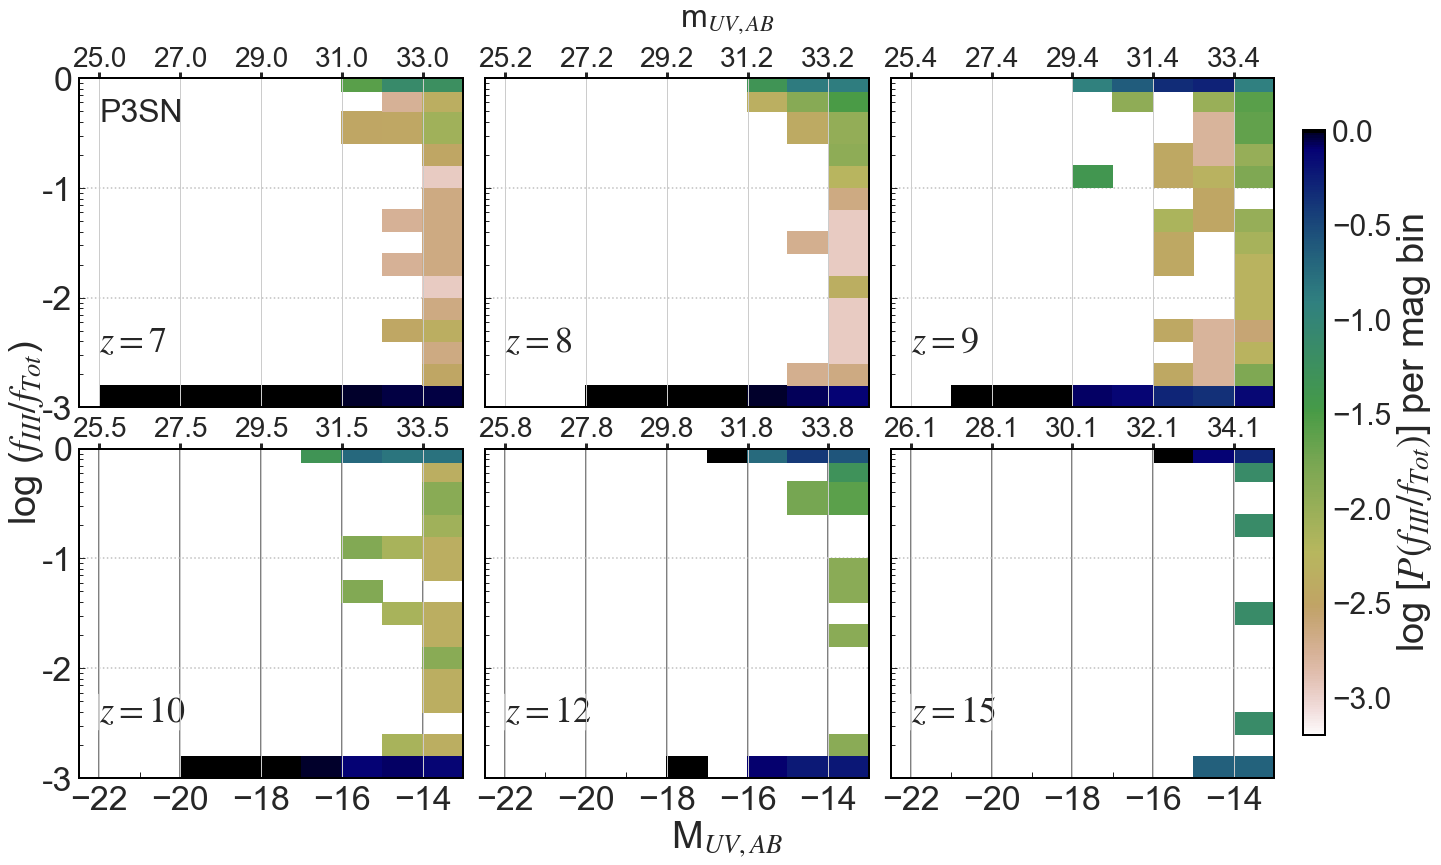

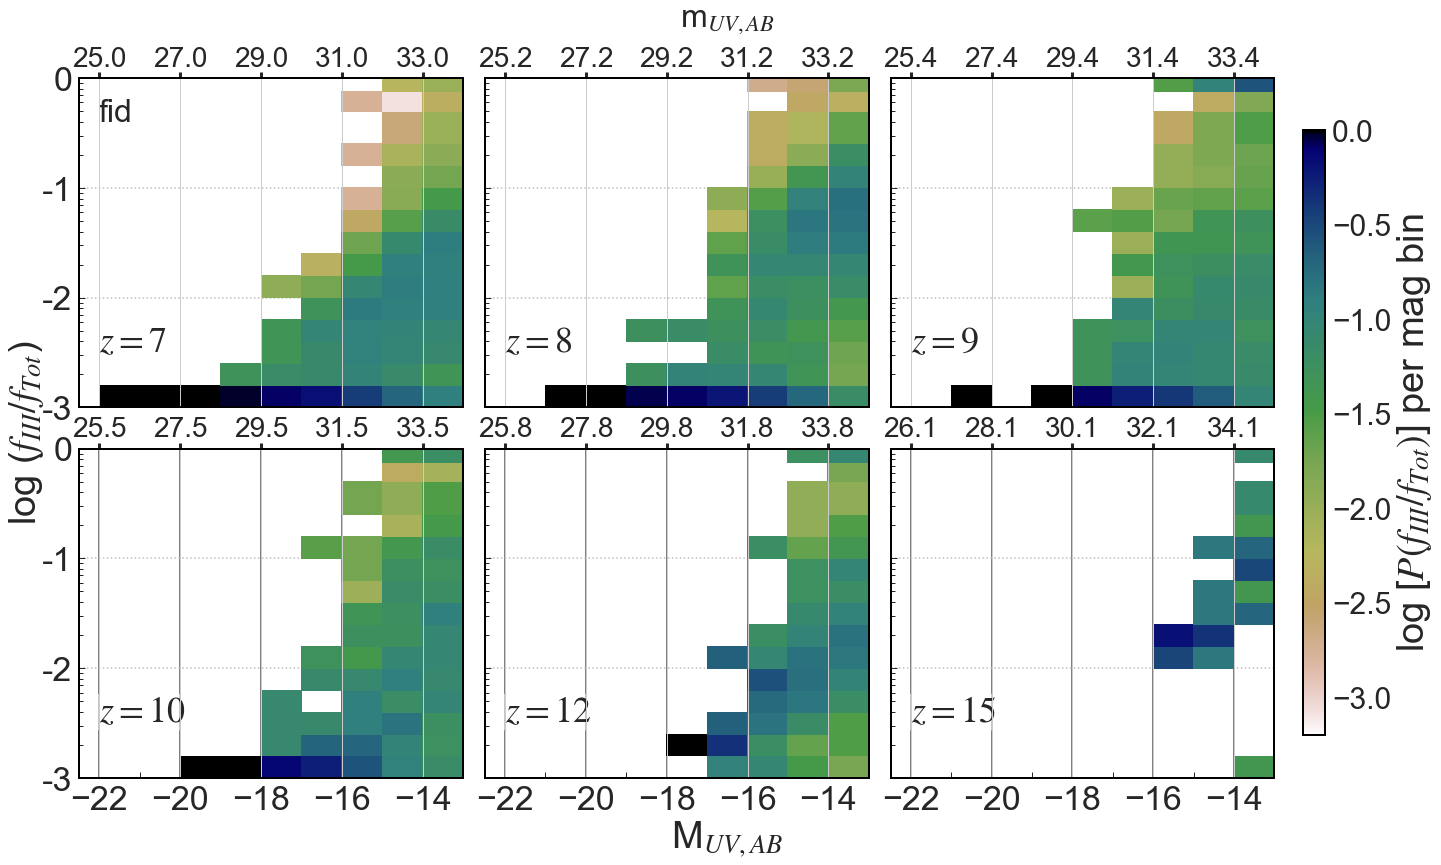

In [56]:
# Normalize the probability in each row such that it totals to 1.0


#
# No classical Pop III
#

sns.set(style="whitegrid", font_scale=2, color_codes=True)
sns.set_style({'axes.edgecolor': '0.0','axes.linewidth': 2.0})

# Plot the fraction of Pop III magnitude vs M_AB NORMALIZED...

brightM = -22
limitM  = brightM+9
rgForSFunc = np.arange(brightM,limitM, 0.1)

magBins = np.linspace(brightM,limitM,(-brightM+limitM)*1 + 1) 
fracBins = np.logspace(-3,0,23)
# Contrived bin spacing such that the top bin represents .75-1.0 Pop III fraction
# and the next bin down represents .5-0.75 ...
fracBins = [0.001,  0.00158489,  0.00251189,  0.00398107,  0.00630957,
             0.01,  0.01584893,  0.02511886,  0.03981072,  0.06309573,
             0.1,  0.15848932,  0.25118864,
             0.5,   0.75,   1.0]
# fracBins = np.linspace(1e-3,9e-3,9).tolist() +np.linspace(1e-2,9e-2,9).tolist() +np.linspace(1e-1,1e-0,9).tolist()
print("Limiting absolute magnitude: {}".format(limitM))


baseline = 'Fiducial'


p3ff ={}
p3ffMix = {}
doNMnow = False
%for dir in ['fw1', 'Z4', 'Z6', 'P3SN','Fid_Sal','Fid_Orig']:
for dir in ['P3SN','Fid_Sal']:
    fig, axs = plt.subplots(nrows=2, ncols=3, sharex='col',sharey='row',figsize=(20,12))
    for z,ax in zip([7,8,9,10,12,15], axs.flat):

        if z not in thezs:
            continue

        # Convert observed magnitude to Absolute ...
        absMag, pop3Mag, nmAbsMag   = compMags(dir,z)
        # Map 0 Pop 3 flux to 1e-3... 
        pop3Fraction = haloData[dir][z]['1500A_P3']/haloData[dir][z]['1500A']
        p3ff[z] = haloData[dir][z]['1500A_P3'].sum()/haloData[dir][z]['1500A'].sum()
#         print("Pop III flux fraction is {:.5f} at z={}".format(p3ff[z],z))
        pop3Fraction[pop3Fraction < 1e-3] = 1e-3  # Map Pop 3 flux < 1e-3 to 1e-3
        p3ffMix[z] = p3ff[z] # Make a copy so we can print both mixing and no-mix

        print("Working on z={}".format(z))
        # If we are back to z = 8,9,10 then generate plots for NO Mixing
        Ng = len(absMag) # Number of galaxies at this z
#         print("Number of galaxies {}".format(Ng))
        # GENERATE THE HISTOGRAM and HISTOGRAM DATA in the array 'n' for
        # both the improved Pop III luminosity and the classical

        # Note that we are reversing x,y here since pcolormesh interprets them backwards!
        nTempA, binsx, binsy = np.histogram2d(pop3Fraction,absMag,bins=[fracBins,magBins],normed=False)
        # could use weights=[1/simVol for i in absMag] to normalize by vol here... 
        # normed : bool, optional
        #        If False, returns the number of samples in each bin. If True, returns the bin density 
        #        bin_count / sample_count / bin_area.

        X, Y = np.meshgrid(magBins, fracBins)  # Create a grid over the range of bins for the plot

        # Mask out 0 values before taking log10... 
        H = np.ma.masked_where(nTempA==0.0, nTempA)
        for i in range(len(H[0,:])):     # Column index i, over len of row 0
            colTot = np.sum(H[:,i])
            for j in range(len(H[:,0])): # Row index j, over len of column 0
                H[:,i][j] = H[:,i][j]/colTot
        H = np.log10(H)        # Take log of counts, we've already normalized by volume and area
        print("Largest bin value: {:.3f}, smallest {}".format(H.max(),H.min()))
        # Create the plot
        im = (ax.pcolormesh(X, Y, H, cmap=mpl.cm.gist_earth_r, vmin=-3.2, vmax=0) )

        ax.set_xscale('linear')
        ax.set_yscale('log')
        ax.yaxis.set_tick_params(which='major',width=1,length=6)
        ax.yaxis.set_tick_params(which='minor',width=1,length=4)
        ax.xaxis.set_tick_params(which='both',width=1,length=6)
        ax.xaxis.set_ticks(np.arange(brightM,limitM+1, 2))
        minorLocator = ticker.MultipleLocator(1)
        ax.xaxis.set_minor_locator(minorLocator)
        ax.get_yaxis().set_tick_params(which='both', direction='in',labelsize=34)
        ax.get_xaxis().set_tick_params(which='both', direction='in',labelsize=34)
        ax.yaxis.set_major_formatter(logfmt)
        ax.set_xlim([brightM-0.5,limitM])
        ax.set_ylim([1e-3,1.0])
        ax.grid(which='major', axis='y', color='0.75', linestyle=':', linewidth=1.5)
        ax.grid(which='major', axis='x', color='0.5', linestyle='-', linewidth=2.0)

        if dir == 'Fid_Orig':
            ax.annotate('$z={}$\n$\lambda_{{obs}}={:.1f} \mu$m'.format(z,0.15*(1+z)+0.0001), xy = (0.5, 0.5), 
                xytext = (0.052, 0.15), xycoords='axes fraction',
                bbox = {'boxstyle': 'round,pad=0.05', 'fc': 'w', 'ec': 'None', 'alpha': 0.55},
                textcoords = 'axes fraction', ha = 'left', va = 'bottom',fontsize=36)
        else:
            ax.annotate('$z={}$'.format(z), xy = (0.5, 0.5), 
                xytext = (0.052, 0.15), xycoords='axes fraction',
                bbox = {'boxstyle': 'round,pad=0.05', 'fc': 'w', 'ec': 'None', 'alpha': 0.55},
                textcoords = 'axes fraction', ha = 'left', va = 'bottom',fontsize=36)
        if z >= 10:
            ax.xaxis.set_visible(True)
        else:
            ax.xaxis.set_visible(False)
        if z == 7:
            name = dir
            if dir == 'Fid_Sal':
                name = 'fid'
            elif dir == 'Fid_Orig':
                name = 'fid_orig'
            ax.annotate('{}'.format(name), xy = (0.5, 0.5), 
                xytext = (0.052, 0.85), xycoords='axes fraction',
                bbox = {'boxstyle': 'round,pad=0.05', 'fc': 'w', 'ec': 'None', 'alpha': 0.55},
                textcoords = 'axes fraction', ha = 'left', va = 'bottom',fontsize=32)

        
        # Top x-axis labels ... m_ab
        ax2 = ax.twiny()
        ax2.set_xlim([brightM-0.5,limitM]) # required...
        axXtics = ax.get_xticks()
        ax2.set_xticks(axXtics)   # Set the location of the tics same as for ax
        ax2Xs = getMag(axXtics,z) # Convert M_ab -> m_ab
        ax2.set_xticklabels(["{:.1f}".format(i) for i in ax2Xs])
        ax2.xaxis.set_tick_params(which='major',width=3,length=6,direction='out',pad=0)
        ax2.get_xaxis().set_tick_params(labelsize=28)

        # plt.gca().invert_xaxis()


    plt.subplots_adjust(left=0.05, bottom=0.1, right=.88, top=0.91, wspace=.057, hspace=.125)

    fig.text(0.5, 0.97,'m$_{UV,AB}$', ha='center',size=32 )
    fig.text(0.5, 0.02,'M$_{UV,AB}$', ha='center',size=38 )
    fig.text(0.00, 0.5, r'log ($f_{III}/f_{Tot}$)',size=38,va='center', rotation='vertical')

    # Create the colorbar
    cbar_ax = fig.add_axes([0.9, 0.15, 0.015, 0.7])
    cbar = fig.colorbar(im, cax=cbar_ax)

    cbar.ax.tick_params(labelsize=30) 
    #cbar.ax.set_yticklabels(['1', '2', '4', '6', '10', maxCV], size=24)
    cbar.set_label("log [$P(f_{III}/f_{Tot})$] per mag bin",fontsize=38)
    plt.savefig("PopIII_fraction-Hist{}_new.pdf".format(dir),dpi=fig.dpi,bbox_inches='tight')
    doNMnow = False
    gc.collect()

Limiting absolute magnitude: -13
Convert to Abs Mag. DM = 46.99 @ z=7.0
Working on z=7
Largest bin value: 0.000, smallest -2.9595183769729982


/Users/earnric/.conda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:7: RuntimeWarning: divide by zero encountered in log10
/Users/earnric/.conda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:77: RuntimeWarning: divide by zero encountered in log10


Convert to Abs Mag. DM = 47.20 @ z=8.0
Working on z=8
Largest bin value: 0.000, smallest -2.9556877503135057
Convert to Abs Mag. DM = 47.38 @ z=9.0
Working on z=9
Largest bin value: 0.000, smallest -2.782472624166286
Convert to Abs Mag. DM = 47.54 @ z=10.0
Working on z=10
Largest bin value: 0.000, smallest -2.3541084391474008
Convert to Abs Mag. DM = 47.81 @ z=12.0
Working on z=12
Largest bin value: 0.000, smallest -1.8976270912904414
Convert to Abs Mag. DM = 48.13 @ z=15.0
Working on z=15
Largest bin value: 0.000, smallest -1.146128035678238


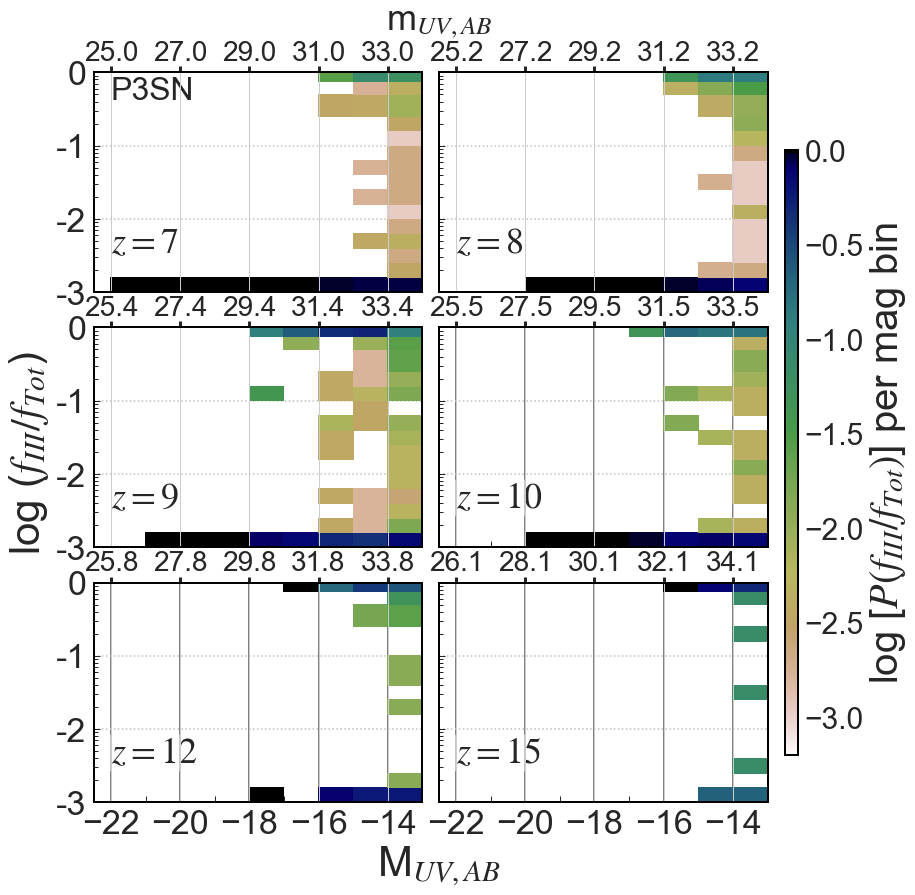

In [57]:
# Normalize the probability in each row such that it totals to 1.0

## BIGGER FONTS 
## Use for smaller plots on the page

#
# No classical Pop III
#

sns.set(style="whitegrid", font_scale=2, color_codes=True)
sns.set_style({'axes.edgecolor': '0.0','axes.linewidth': 2.0})

# Plot the fraction of Pop III magnitude vs M_AB NORMALIZED...

brightM = -22
limitM  = brightM+9
rgForSFunc = np.arange(brightM,limitM, 0.1)

magBins = np.linspace(brightM,limitM,(-brightM+limitM)*1 + 1) 
fracBins = np.logspace(-3,0,23)
# Contrived bin spacing such that the top bin represents .75-1.0 Pop III fraction
# and the next bin down represents .5-0.75 ...
fracBins = [0.001,  0.00158489,  0.00251189,  0.00398107,  0.00630957,
             0.01,  0.01584893,  0.02511886,  0.03981072,  0.06309573,
             0.1,  0.15848932,  0.25118864,
             0.5,   0.75,   1.0]
# fracBins = np.linspace(1e-3,9e-3,9).tolist() +np.linspace(1e-2,9e-2,9).tolist() +np.linspace(1e-1,1e-0,9).tolist()
print("Limiting absolute magnitude: {}".format(limitM))


baseline = 'Fiducial'


p3ff ={}
p3ffMix = {}
doNMnow = False
#for dir in ['fw1', 'Z4', 'Z6', 'P3SN','Fid_Sal','Fid_Orig']:
# for dir in ['Fid_Sal','Fid_Orig']:
for dir in ['P3SN']:
    fig, axs = plt.subplots(nrows=3, ncols=2, sharex='col',sharey='row',figsize=(12,12))
    for z,ax in zip([7,8,9,10,12,15], axs.flat):

        if z not in thezs:
            continue

        # Convert observed magnitude to Absolute ...
        absMag, pop3Mag, nmAbsMag   = compMags(dir,z)
        # Map 0 Pop 3 flux to 1e-3... 
        pop3Fraction = haloData[dir][z]['1500A_P3']/haloData[dir][z]['1500A']
        p3ff[z] = haloData[dir][z]['1500A_P3'].sum()/haloData[dir][z]['1500A'].sum()
#         print("Pop III flux fraction is {:.5f} at z={}".format(p3ff[z],z))
        pop3Fraction[pop3Fraction < 1e-3] = 1e-3  # Map Pop 3 flux < 1e-3 to 1e-3
        p3ffMix[z] = p3ff[z] # Make a copy so we can print both mixing and no-mix

        print("Working on z={}".format(z))
        # If we are back to z = 8,9,10 then generate plots for NO Mixing
        Ng = len(absMag) # Number of galaxies at this z
#         print("Number of galaxies {}".format(Ng))
        # GENERATE THE HISTOGRAM and HISTOGRAM DATA in the array 'n' for
        # both the improved Pop III luminosity and the classical

        # Note that we are reversing x,y here since pcolormesh interprets them backwards!
        nTempA, binsx, binsy = np.histogram2d(pop3Fraction,absMag,bins=[fracBins,magBins],normed=False)
        # could use weights=[1/simVol for i in absMag] to normalize by vol here... 
        # normed : bool, optional
        #        If False, returns the number of samples in each bin. If True, returns the bin density 
        #        bin_count / sample_count / bin_area.

        X, Y = np.meshgrid(magBins, fracBins)  # Create a grid over the range of bins for the plot

        # Mask out 0 values before taking log10... 
        H = np.ma.masked_where(nTempA==0.0, nTempA)
        for i in range(len(H[0,:])):     # Column index i, over len of row 0
            colTot = np.sum(H[:,i])
            for j in range(len(H[:,0])): # Row index j, over len of column 0
                H[:,i][j] = H[:,i][j]/colTot
        H = np.log10(H)        # Take log of counts, we've already normalized by volume and area
        print("Largest bin value: {:.3f}, smallest {}".format(H.max(),H.min()))
        # Create the plot
        im = (ax.pcolormesh(X, Y, H, cmap=mpl.cm.gist_earth_r, vmin=-3.2, vmax=0) )

        ax.set_xscale('linear')
        ax.set_yscale('log')
        ax.yaxis.set_tick_params(which='major',width=1,length=6)
        ax.yaxis.set_tick_params(which='minor',width=1,length=4)
        ax.xaxis.set_tick_params(which='both',width=1,length=6)
        ax.xaxis.set_ticks(np.arange(brightM,limitM+1, 2))
        minorLocator = ticker.MultipleLocator(1)
        ax.xaxis.set_minor_locator(minorLocator)
        ax.get_yaxis().set_tick_params(which='both', direction='in',labelsize=34)
        ax.get_xaxis().set_tick_params(which='both', direction='in',labelsize=34)
        ax.yaxis.set_major_formatter(logfmt)
        ax.set_xlim([brightM-0.5,limitM])
        ax.set_ylim([1e-3,1.0])
        ax.grid(which='major', axis='y', color='0.75', linestyle=':', linewidth=1.5)
        ax.grid(which='major', axis='x', color='0.5', linestyle='-', linewidth=2.0)

        if dir == 'Fid_Orig':
            ax.annotate('$z={}$\n$\lambda_{{obs}}={:.1f} \mu$m'.format(z,0.15*(1+z)+0.0001), xy = (0.5, 0.5), 
                xytext = (0.052, 0.15), xycoords='axes fraction',
                bbox = {'boxstyle': 'round,pad=0.05', 'fc': 'w', 'ec': 'None', 'alpha': 0.55},
                textcoords = 'axes fraction', ha = 'left', va = 'bottom',fontsize=36)
        else:
            ax.annotate('$z={}$'.format(z), xy = (0.5, 0.5), 
                xytext = (0.052, 0.15), xycoords='axes fraction',
                bbox = {'boxstyle': 'round,pad=0.05', 'fc': 'w', 'ec': 'None', 'alpha': 0.55},
                textcoords = 'axes fraction', ha = 'left', va = 'bottom',fontsize=36)
        if z >= 10:
            ax.xaxis.set_visible(True)
        else:
            ax.xaxis.set_visible(False)
        if z == 7:
            name = dir
            if dir == 'Fid_Sal':
                name = 'fid'
            elif dir == 'Fid_Orig':
                name = 'fid_orig'
            ax.annotate('{}'.format(name), xy = (0.5, 0.5), 
                xytext = (0.052, 0.85), xycoords='axes fraction',
                bbox = {'boxstyle': 'round,pad=0.05', 'fc': 'w', 'ec': 'None', 'alpha': 0.55},
                textcoords = 'axes fraction', ha = 'left', va = 'bottom',fontsize=32)

        
        # Top x-axis labels ... m_ab
        ax2 = ax.twiny()
        ax2.set_xlim([brightM-0.5,limitM]) # required...
        axXtics = ax.get_xticks()
        ax2.set_xticks(axXtics)   # Set the location of the tics same as for ax
        ax2Xs = getMag(axXtics,z) # Convert M_ab -> m_ab
        ax2.set_xticklabels(["{:.1f}".format(i) for i in ax2Xs])
        ax2.xaxis.set_tick_params(which='major',width=3,length=6,direction='out',pad=0)
        ax2.get_xaxis().set_tick_params(labelsize=28)

        # plt.gca().invert_xaxis()
        gc.collect()

    plt.subplots_adjust(left=0.1, bottom=0.095, right=.88, top=0.94, wspace=.05 , hspace=.16)

    fig.text(0.5, 0.99,'m$_{UV,AB}$', ha='center',size=36 )
    fig.text(0.5, 0.01,'M$_{UV,AB}$', ha='center',size=42 )
    fig.text(0.00, 0.5, r'log ($f_{III}/f_{Tot}$)',size=42,va='center', rotation='vertical')

    # Create the colorbar
    cbar_ax = fig.add_axes([0.9, 0.15, 0.015, 0.7])
    cbar = fig.colorbar(im, cax=cbar_ax)

    cbar.ax.tick_params(labelsize=30) 
    #cbar.ax.set_yticklabels(['1', '2', '4', '6', '10', maxCV], size=24)
    cbar.set_label("log [$P(f_{III}/f_{Tot})$] per mag bin",fontsize=40)
    plt.savefig("PopIII_fraction-Hist{}.pdf".format(dir),dpi=fig.dpi,bbox_inches='tight')
    doNMnow = False
    gc.collect()

# Plot delta's


In [57]:
thezs=[7,8,9,10,12,15]

Limiting absolute magnitude: -13
Convert to Abs Mag. DM = 47.80 @ z=12.0
Convert to Abs Mag. DM = 47.80 @ z=12.0
Pop III flux fraction is 0.14437 at z=12
Working on z=12
Number of galaxies 554
fw1
[[   0.    0.    0.    0.    2.    7.   35.   82.  103.]
 [   0.    0.    0.    0.    0.    0.    0.    2.    5.]
 [   0.    0.    0.    0.    0.    0.    0.    3.    5.]
 [   0.    0.    0.    0.    0.    0.    0.    0.    0.]
 [   0.    0.    0.    0.    0.    0.    0.    1.    1.]
 [   0.    0.    0.    0.    0.    0.    1.    2.    3.]
 [   0.    0.    0.    0.    0.    0.    0.    2.    1.]
 [   0.    0.    0.    0.    0.    0.    1.    1.    1.]
 [   0.    0.    0.    0.    0.    0.    0.    3.    2.]
 [   0.    0.    0.    0.    0.    0.    0.    0.    3.]
 [   0.    0.    0.    0.    0.    0.    0.    1.    2.]
 [   0.    0.    0.    0.    0.    0.    0.    1.    3.]
 [   0.    0.    0.    0.    0.    0.    1.    2.    0.]
 [   0.    0.    0.    0.    0.    0.    0.    3.    2.]
 [   

/Users/earnric/.conda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:7: RuntimeWarning: divide by zero encountered in log10
/Users/earnric/.conda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:49: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 538 but corresponding boolean dimension is 87
/Users/earnric/.conda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:49: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 110 but corresponding boolean dimension is 554


Convert to Abs Mag. DM = 47.80 @ z=12.0
Convert to Abs Mag. DM = 47.80 @ z=12.0
Pop III flux fraction is 0.18043 at z=12
Working on z=12
Number of galaxies 536
Z4
[[  0.   0.   0.   0.   2.   5.  26.  69.  81.]
 [  0.   0.   0.   0.   0.   0.   0.   5.   7.]
 [  0.   0.   0.   0.   0.   0.   2.   3.   7.]
 [  0.   0.   0.   0.   0.   0.   3.   2.   4.]
 [  0.   0.   0.   0.   0.   0.   0.   1.   4.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   2.]
 [  0.   0.   0.   0.   0.   0.   1.   1.   6.]
 [  0.   0.   0.   0.   0.   0.   0.   4.   4.]
 [  0.   0.   0.   0.   0.   0.   0.   1.   1.]
 [  0.   0.   0.   0.   0.   0.   1.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   1.   2.]
 [  0.   0.   0.   0.   0.   0.   0.   1.   2.]
 [  0.   0.   0.   0.   0.   0.   1.   3.   2.]
 [  0.   0.   0.   0.   0.   0.   0.   3.   7.]
 [  0.   0.   0.   0.   0.   2.   5.  20.  24.]]
Convert to Abs Mag. DM = 48.12 @ z=15.0
Convert to Abs Mag. DM = 48.12 @ z=15.0
Pop III flux fraction is 0.46939 at 

/Users/earnric/.conda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:49: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 538 but corresponding boolean dimension is 107
/Users/earnric/.conda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:49: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 110 but corresponding boolean dimension is 536


Convert to Abs Mag. DM = 47.80 @ z=12.0
Convert to Abs Mag. DM = 47.80 @ z=12.0
Pop III flux fraction is 0.14070 at z=12
Working on z=12
Number of galaxies 536
Z6
[[   0.    0.    0.    0.    2.    6.   32.   84.  115.]
 [   0.    0.    0.    0.    0.    0.    0.    2.    1.]
 [   0.    0.    0.    0.    0.    0.    0.    0.    1.]
 [   0.    0.    0.    0.    0.    0.    0.    2.    0.]
 [   0.    0.    0.    0.    0.    0.    0.    0.    1.]
 [   0.    0.    0.    0.    0.    0.    0.    0.    3.]
 [   0.    0.    0.    0.    0.    0.    0.    1.    2.]
 [   0.    0.    0.    0.    0.    0.    0.    1.    2.]
 [   0.    0.    0.    0.    0.    0.    0.    2.    1.]
 [   0.    0.    0.    0.    0.    0.    0.    0.    0.]
 [   0.    0.    0.    0.    0.    0.    0.    1.    2.]
 [   0.    0.    0.    0.    0.    0.    0.    1.    3.]
 [   0.    0.    0.    0.    0.    0.    0.    1.    2.]
 [   0.    0.    0.    0.    0.    0.    0.    0.    2.]
 [   0.    0.    0.    0.    0.    2.  

/Users/earnric/.conda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:49: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 538 but corresponding boolean dimension is 109


Convert to Abs Mag. DM = 47.80 @ z=12.0
Convert to Abs Mag. DM = 47.80 @ z=12.0
Pop III flux fraction is 0.31085 at z=12
Working on z=12
Number of galaxies 535
P3SN
[[  0.   0.   0.   0.   2.   0.  13.  33.  48.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   1.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   1.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   1.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   1.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   1.   2.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   4.]
 [  0.   0.   0.   0.   0.   3.   3.  22.  21.]]
Convert to Abs Mag. DM = 48.12 @ z=15.0
Convert to Abs Mag. DM = 48.12 @ z=15.0
Pop III flux fraction is 0.59389 a

/Users/earnric/.conda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:49: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 110 but corresponding boolean dimension is 535


Convert to Abs Mag. DM = 47.80 @ z=12.0
Convert to Abs Mag. DM = 47.80 @ z=12.0
Pop III flux fraction is 0.16505 at z=12
Working on z=12
Number of galaxies 538
Fiducial
[[   0.    0.    0.    0.    1.    9.   31.   68.  122.]
 [   0.    0.    0.    0.    0.    0.    0.    2.    6.]
 [   0.    0.    0.    0.    0.    0.    0.    1.    1.]
 [   0.    0.    0.    0.    0.    0.    0.    2.    2.]
 [   0.    0.    0.    0.    0.    0.    0.    2.    2.]
 [   0.    0.    0.    0.    0.    0.    0.    0.    1.]
 [   0.    0.    0.    0.    0.    0.    0.    0.    3.]
 [   0.    0.    0.    0.    0.    0.    0.    1.    1.]
 [   0.    0.    0.    0.    0.    0.    0.    2.    2.]
 [   0.    0.    0.    0.    0.    0.    0.    1.    1.]
 [   0.    0.    0.    0.    0.    0.    1.    0.    1.]
 [   0.    0.    0.    0.    0.    0.    0.    1.    3.]
 [   0.    0.    0.    0.    0.    0.    0.    0.    3.]
 [   0.    0.    0.    0.    0.    0.    0.    0.    3.]
 [   0.    0.    0.    0.    0.  

/Users/earnric/.conda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:49: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 110 but corresponding boolean dimension is 538


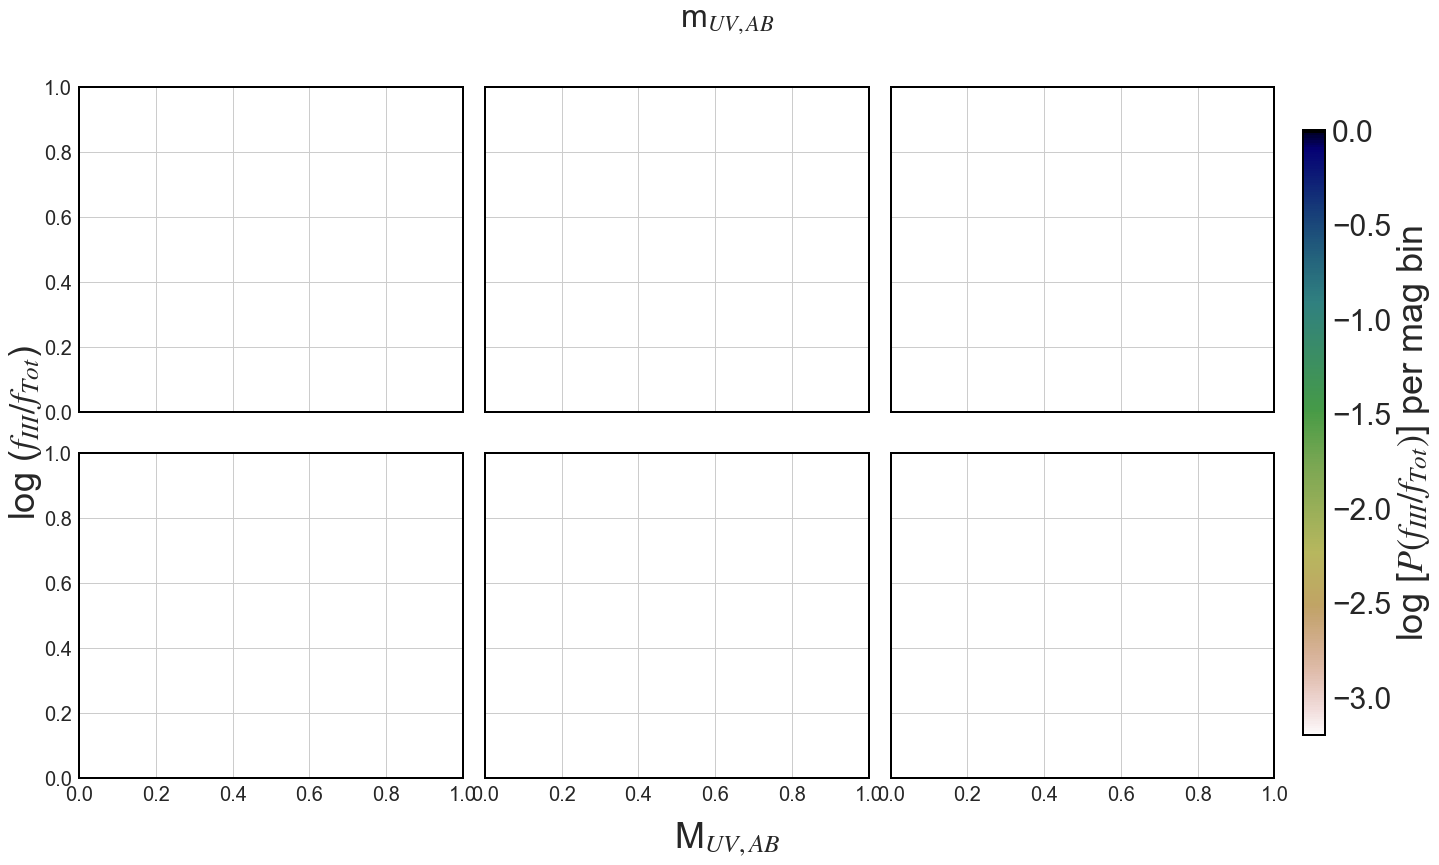

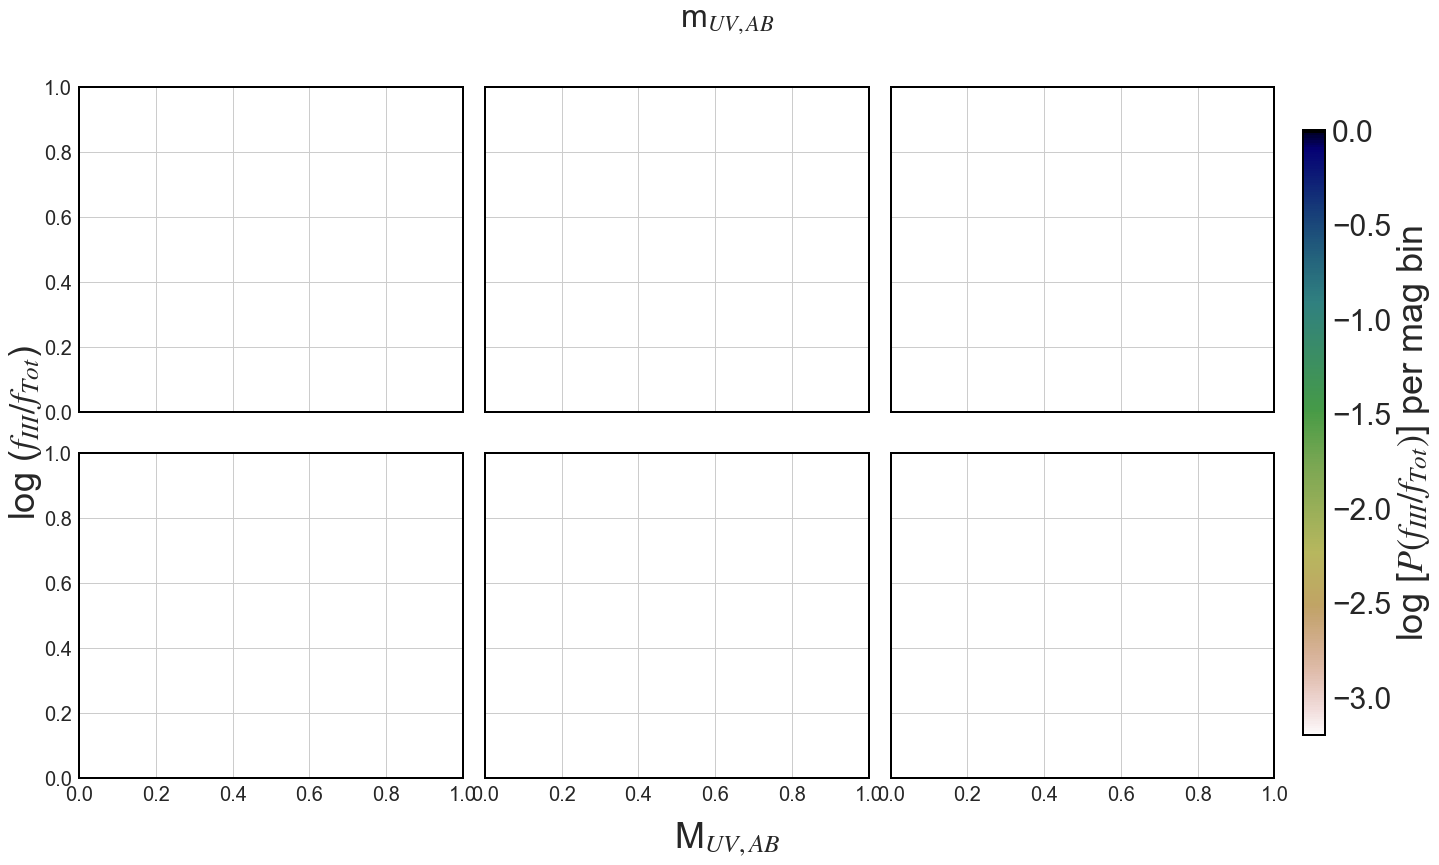

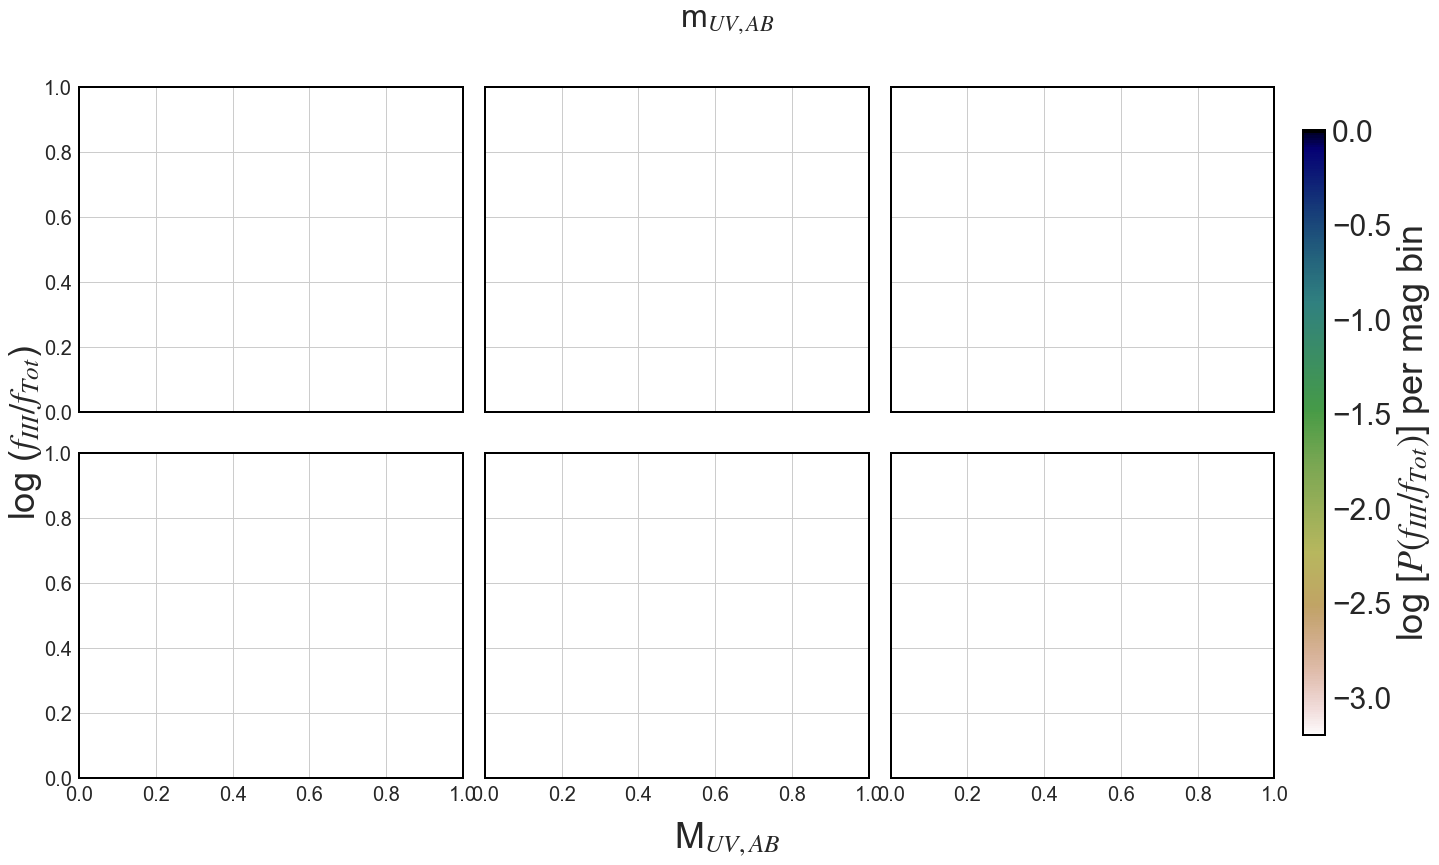

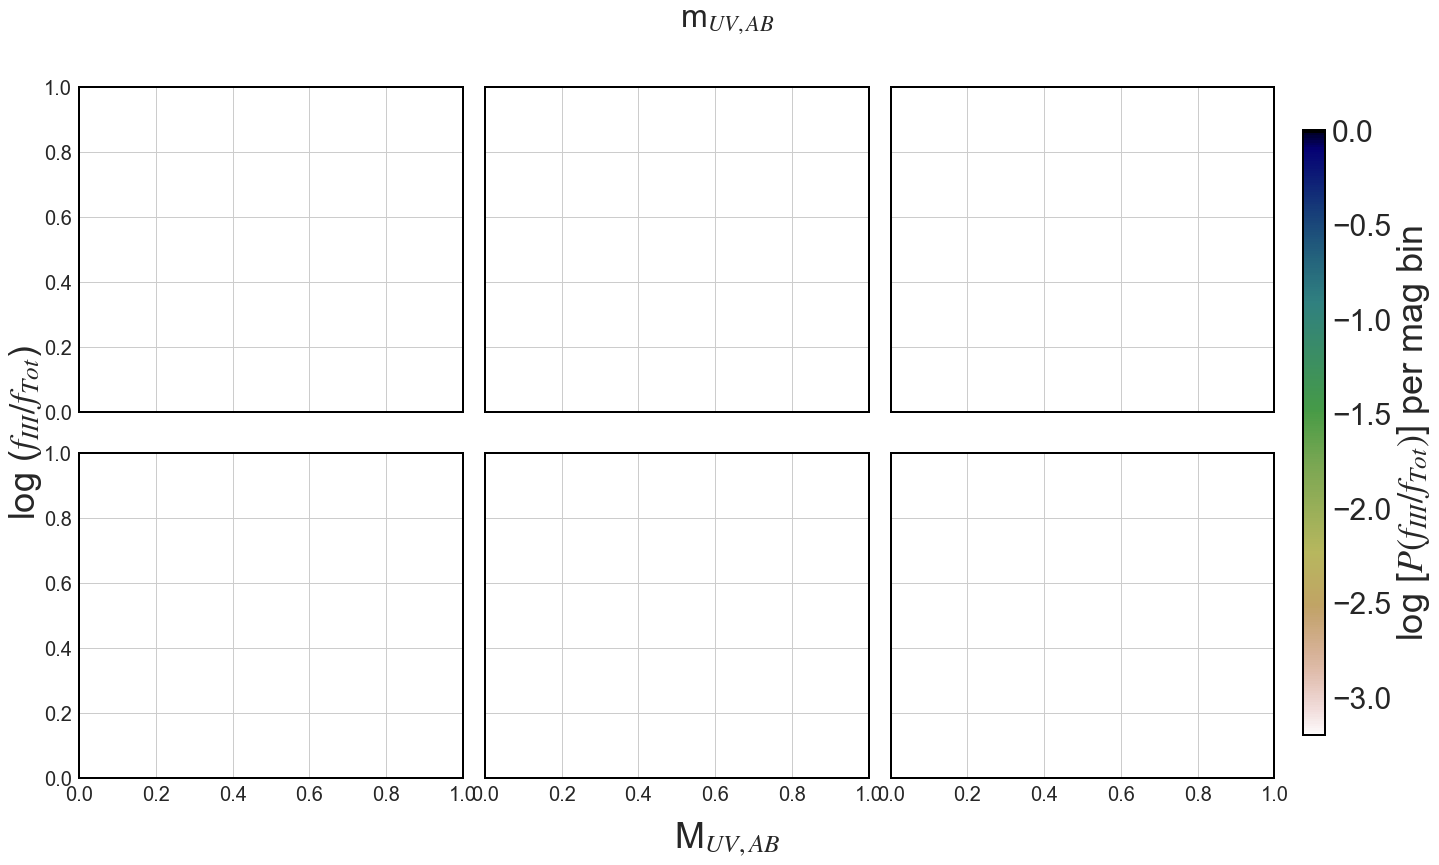

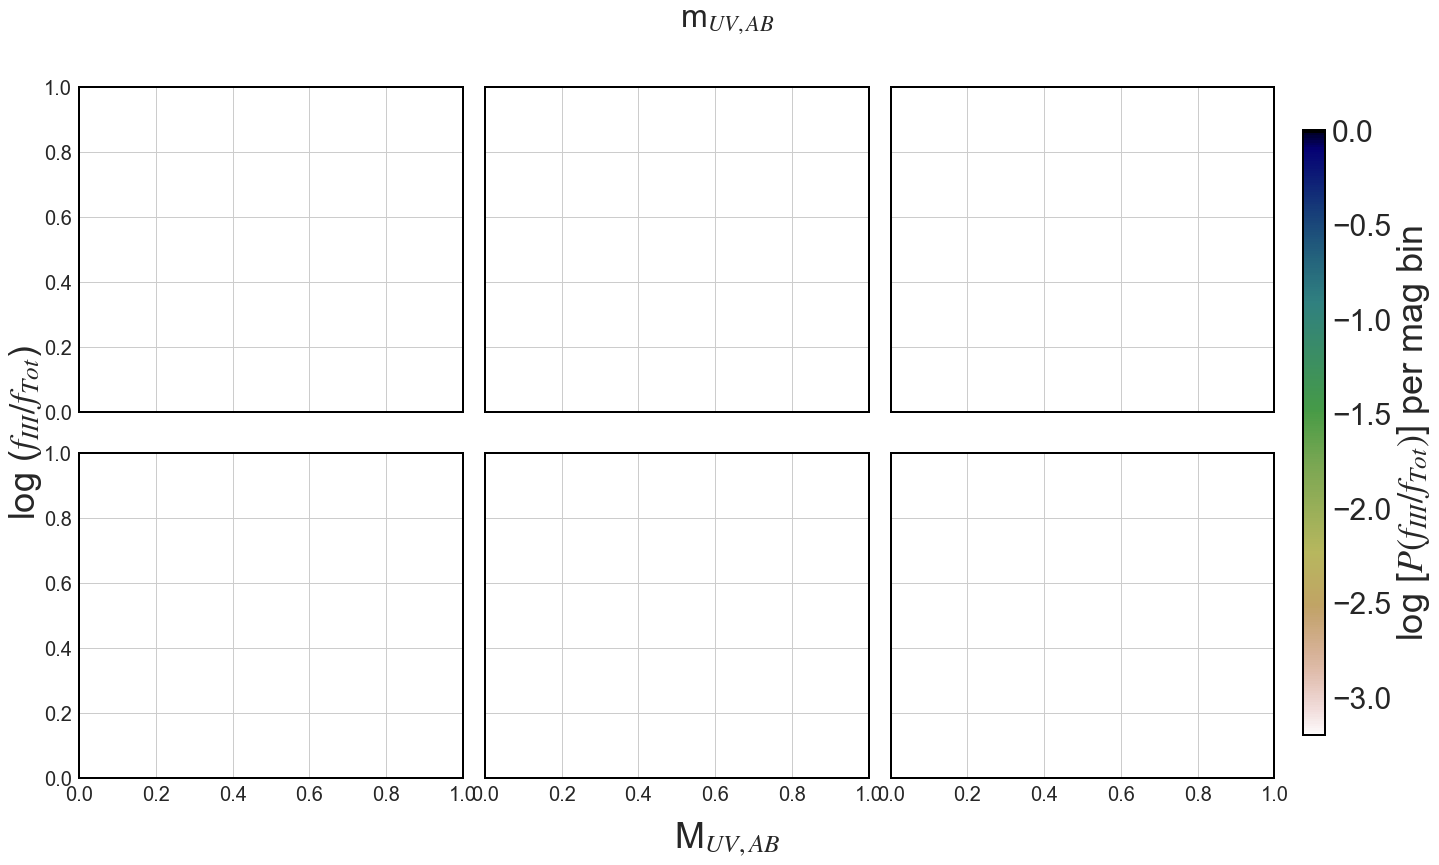

In [73]:
# Normalize the probability in each row such that it totals to 1.0


#
# Plot DIFFERENCES in Pop III flux ... How to display???? 
#

sns.set(style="whitegrid", font_scale=2, color_codes=True)
sns.set_style({'axes.edgecolor': '0.0','axes.linewidth': 2.0})

# Plot the fraction of Pop III magnitude vs M_AB NORMALIZED...

brightM = -22
limitM  = brightM+9
rgForSFunc = np.arange(brightM,limitM, 0.1)

magBins = np.linspace(brightM,limitM,(-brightM+limitM)*1 + 1) 
fracBins = np.logspace(-3,0,23)
# Contrived bin spacing such that the top bin represents .75-1.0 Pop III fraction
# and the next bin down represents .5-0.75 ...
fracBins = [0.001,  0.00158489,  0.00251189,  0.00398107,  0.00630957,
             0.01,  0.01584893,  0.02511886,  0.03981072,  0.06309573,
             0.1,  0.15848932,  0.25118864,
             0.5,   0.75,   1.0]
# fracBins = np.linspace(1e-3,9e-3,9).tolist() +np.linspace(1e-2,9e-2,9).tolist() +np.linspace(1e-1,1e-0,9).tolist()
print("Limiting absolute magnitude: {}".format(limitM))


baseline = 'Fiducial'


p3ff ={}
p3ffFid = {}
doNMnow = False
# for dir in ['fw1', 'Z4', 'Z6', 'P3SN']:
for dir in ['fw1', 'Z4', 'Z6', 'P3SN','Fiducial']:
    fig, axs = plt.subplots(nrows=2, ncols=3, sharex='col',sharey='row',figsize=(20,12))
#     for z,ax in zip([7,8,9,10,12,15], axs.flat):
    for z,ax in zip([12,15], axs.flat):

        if z not in thezs:
            continue
            
        # Compute baseline
        absMagFid, pop3MagFid, nmAbsMagFid   = compMags(baseline,z)
        # Map 0 Pop 3 flux to 1e-3... 
        pop3FractionFid = haloData[baseline][z]['1500A_P3']/haloData[baseline][z]['1500A']
        p3ffFid[z] = haloData[baseline][z]['1500A_P3'].sum()/haloData[baseline][z]['1500A'].sum()
        pop3FractionFid[pop3Fraction < 1e-3] = 1e-3  # Map Pop 3 flux < 1e-3 to 1e-3
        ################

        # Convert observed magnitude to Absolute ...
        absMag, pop3Mag, nmAbsMag   = compMags(dir,z)
        # Map 0 Pop 3 flux to 1e-3... 
        pop3Fraction = haloData[dir][z]['1500A_P3']/haloData[dir][z]['1500A']
        p3ff[z] = haloData[dir][z]['1500A_P3'].sum()/haloData[dir][z]['1500A'].sum()
        print("Pop III flux fraction is {:.5f} at z={}".format(p3ff[z],z))
        pop3Fraction[pop3Fraction < 1e-3] = 1e-3  # Map Pop 3 flux < 1e-3 to 1e-3
        p3ffMix[z] = p3ff[z] # Make a copy so we can print both mixing and no-mix

        print("Working on z={}".format(z))
        # If we are back to z = 8,9,10 then generate plots for NO Mixing
        Ng = len(absMag) # Number of galaxies at this z
        print("Number of galaxies {}".format(Ng))
        # GENERATE THE HISTOGRAM and HISTOGRAM DATA in the array 'n' for
        # both the improved Pop III luminosity and the classical

        # Note that we are reversing x,y here since pcolormesh interprets them backwards!
        nTempA, binsx, binsy = np.histogram2d(pop3Fraction,absMag,bins=[fracBins,magBins],normed=False)
#         nTempAFid, binsxFid, binsyFid = np.histogram2d(pop3FractionFid,absMagFid,bins=[fracBins,magBins],normed=False)
    
#         nTempA = nTempA-nTempAFid
        print(dir)
        print(nTempA)
        continue
        
        X, Y = np.meshgrid(magBins, fracBins)  # Create a grid over the range of bins for the plot

        # Mask out 0 values before taking log10... 
        H = np.ma.masked_where(nTempA==0.0, nTempA)
        for i in range(len(H[0,:])):     # Column index i, over len of row 0
            colTot = np.sum(H[:,i])
            for j in range(len(H[:,0])): # Row index j, over len of column 0
                H[:,i][j] = H[:,i][j]/colTot
        H = np.log10(H)        # Take log of counts, we've already normalized by volume and area
        print("Largest bin value: {:.3f}, smallest {}".format(H.max(),H.min()))
        # Create the plot
        im = (ax.pcolormesh(X, Y, H, cmap=mpl.cm.gist_earth_r, vmin=-3.2, vmax=0) )

        ax.set_xscale('linear')
        ax.set_yscale('log')
        ax.yaxis.set_tick_params(which='major',width=1,length=6)
        ax.yaxis.set_tick_params(which='minor',width=1,length=4)
        ax.xaxis.set_tick_params(which='both',width=1,length=6)
        ax.xaxis.set_ticks(np.arange(brightM,limitM+1, 2))
        minorLocator = ticker.MultipleLocator(1)
        ax.xaxis.set_minor_locator(minorLocator)
        ax.get_yaxis().set_tick_params(which='both', direction='in',labelsize=28)
        ax.get_xaxis().set_tick_params(which='both', direction='in',labelsize=28)
        ax.yaxis.set_major_formatter(logfmt)
        ax.set_xlim([brightM-0.5,limitM])
        ax.set_ylim([1e-3,1.0])
        ax.grid(which='major', axis='y', color='0.75', linestyle=':', linewidth=1.5)
        ax.grid(which='major', axis='x', color='0.5', linestyle='-', linewidth=2.0)


        ax.annotate('$z={}$\n$\lambda_{{obs}}={:.1f} \mu$m'.format(z,0.15*(1+z)+0.0001), xy = (0.5, 0.5), 
                xytext = (0.052, 0.15), xycoords='axes fraction',
                bbox = {'boxstyle': 'round,pad=0.05', 'fc': 'w', 'ec': 'None', 'alpha': 0.55},
                textcoords = 'axes fraction', ha = 'left', va = 'bottom',fontsize=28)
        if z >= 10:
            ax.xaxis.set_visible(True)
        else:
            ax.xaxis.set_visible(False)
        if z == 7:
            ax.annotate('{}'.format(dir), xy = (0.5, 0.5), 
                xytext = (0.052, 0.85), xycoords='axes fraction',
                bbox = {'boxstyle': 'round,pad=0.05', 'fc': 'w', 'ec': 'None', 'alpha': 0.55},
                textcoords = 'axes fraction', ha = 'left', va = 'bottom',fontsize=28)

        
        # Top x-axis labels ... m_ab
        ax2 = ax.twiny()
        ax2.set_xlim([brightM-0.5,limitM]) # required...
        axXtics = ax.get_xticks()
        ax2.set_xticks(axXtics)   # Set the location of the tics same as for ax
        ax2Xs = getMag(axXtics,z) # Convert M_ab -> m_ab
        ax2.set_xticklabels(["{:.1f}".format(i) for i in ax2Xs])
        ax2.xaxis.set_tick_params(which='major',width=3,length=6,direction='out',pad=0)
        ax2.get_xaxis().set_tick_params(labelsize=24)

        # plt.gca().invert_xaxis()
        gc.collect()

    plt.subplots_adjust(left=0.05, bottom=0.1, right=.88, top=0.9, wspace=.057, hspace=.125)

    fig.text(0.5, 0.97,'m$_{UV,AB}$', ha='center',size=32 )
    fig.text(0.5, 0.02,'M$_{UV,AB}$', ha='center',size=36 )
    fig.text(0.00, 0.5, r'log ($f_{III}/f_{Tot}$)',size=36,va='center', rotation='vertical')
    
    # Create the colorbar
    cbar_ax = fig.add_axes([0.9, 0.15, 0.015, 0.7])
    cbar = fig.colorbar(im, cax=cbar_ax)

    cbar.ax.tick_params(labelsize=30) 
    #cbar.ax.set_yticklabels(['1', '2', '4', '6', '10', maxCV], size=24)
    cbar.set_label("log [$P(f_{III}/f_{Tot})$] per mag bin",fontsize=36)
#     plt.savefig("PopIII_fraction-Hist-diff-{}.pdf".format(dir),dpi=fig.dpi,bbox_inches='tight')
    doNMnow = False
    gc.collect()

In [76]:
np.array([0.11363636363636363, 0.19083969465648856, 0.17682926829268292, 0.05319148936170213/2]).sum()

0.50790107126638617

In [29]:
magBins

array([-22., -21., -20., -19., -18., -17., -16., -15., -14., -13.])

Limiting absolute magnitude: -13
Convert to Abs Mag. DM = 47.38 @ z=9.0
Pop III flux fraction is 0.11445 at z=9
Working on z=9
Number of galaxies 1468
Largest bin value: 0.000, smallest -2.6720978579357175


/Users/earnric/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:71: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.


Convert to Abs Mag. DM = 47.54 @ z=10.0
Pop III flux fraction is 0.05494 at z=10
Working on z=10
Number of galaxies 1021
Largest bin value: 0.000, smallest -2.54282542695918
Convert to Abs Mag. DM = 47.68 @ z=11.0
Pop III flux fraction is 0.07623 at z=11
Working on z=11
Number of galaxies 687
Largest bin value: 0.000, smallest -2.367355921026019
FINISHED with z=8-12
Convert to Abs Mag. DM = 47.38 @ z=9.0
Pop III flux fraction is 0.11445 at z=9
Working on z=9
************************************************************
Working on the NON MIXING flux fractions for or galaxies ...
************************************************************
z=9 overall mixing p3ff=0.114, no mixing p3ff=0.042
z=9 PopIII mixing/no mixing=2.860
Number of galaxies 1468
Largest bin value: 0.000, smallest -2.678518379040114
Convert to Abs Mag. DM = 47.54 @ z=10.0
Pop III flux fraction is 0.05494 at z=10
Working on z=10
************************************************************
Working on the NON MIXING flux f

18976

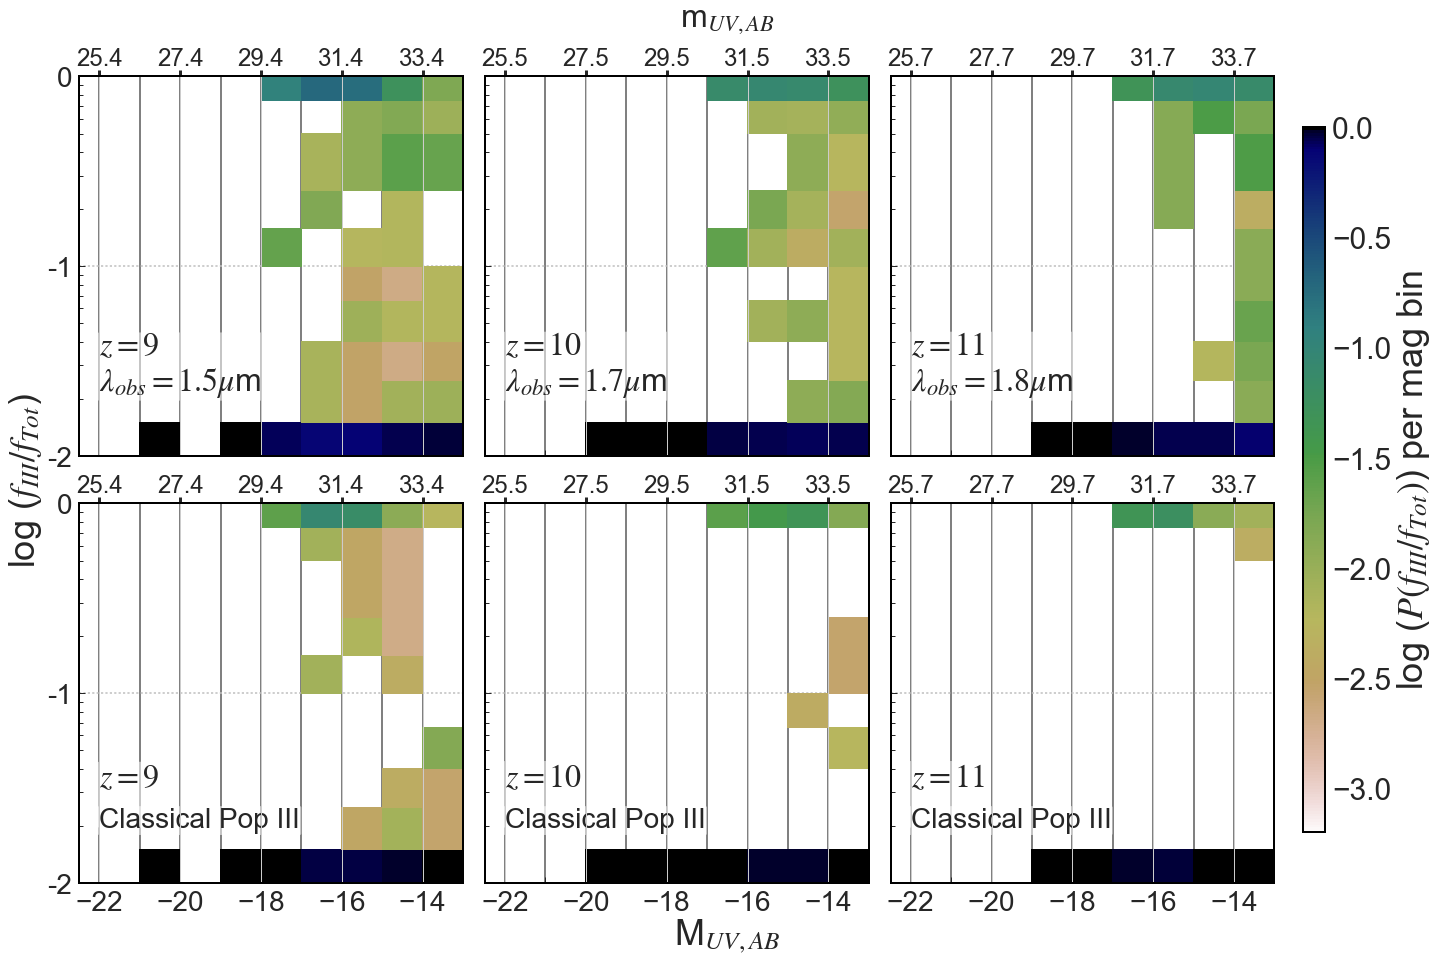

In [33]:
# Normalize the probability in each row such that it totals to 1.0

sns.set(style="whitegrid", font_scale=2, color_codes=True)
sns.set_style({'axes.edgecolor': '0.0','axes.linewidth': 2.0})

# Plot the fraction of Pop III magnitude vs M_AB NORMALIZED...

brightM = -22
limitM  = brightM+9
rgForSFunc = np.arange(brightM,limitM, 0.1)

magBins = np.linspace(brightM,limitM,(-brightM+limitM)*1 + 1) 
fracBins = np.logspace(-3,0,23)
# Contrived bin spacing such that the top bin represents .75-1.0 Pop III fraction
# and the next bin down represents .5-0.75 ...
fracBins = [ 0.01,  0.015,  0.025,  0.040,  0.066,
             0.1,  0.15848932,  0.25118864,
             0.5,   0.75,   1.0]
# fracBins = np.linspace(1e-3,9e-3,9).tolist() +np.linspace(1e-2,9e-2,9).tolist() +np.linspace(1e-1,1e-0,9).tolist()
print("Limiting absolute magnitude: {}".format(limitM))

p3ff ={}
p3ffMix = {}
doNMnow = False
fig, axs = plt.subplots(nrows=2, ncols=3, sharex='col',sharey='row',figsize=(20,14))
z_range = np.array([9,10,11,9,10,11])
for z,ax in zip(z_range, axs.flat):

    # Convert observed magnitude to Absolute ...
    absMag, pop3Mag, nmAbsMag   = compMags(z)
    # Map 0 Pop 3 flux to 1e-3... 
    pop3Fraction = haloData[dir][z]['1500A_P3']/haloData[dir][z]['1500A']
    p3ff[z] = haloData[dir][z]['1500A_P3'].sum()/haloData[dir][z]['1500A'].sum()
    print("Pop III flux fraction is {:.5f} at z={}".format(p3ff[z],z))
    pop3Fraction[pop3Fraction < 1e-2] = 1e-2  # Map Pop 3 flux < 1e-3 to 1e-3
    p3ffMix[z] = p3ff[z] # Make a copy so we can print both mixing and no-mix

    print("Working on z={}".format(z))
    # If we are back to z = 8,9,10 then generate plots for NO Mixing
    if doNMnow:
        print("************************************************************")
        print("Working on the NON MIXING flux fractions for or galaxies ...")
        print("************************************************************")
        pop3Fraction = haloData[dir][z]['1500A_P3NM']/haloData[dir][z]['1500A_NM']
        p3ff[z] = haloData[dir][z]['1500A_P3NM'].sum()/haloData[dir][z]['1500A_NM'].sum()
#         print("Pop III flux fraction is {:.5f} at z={}".format(p3ffNM[z],z))
        pop3Fraction[pop3Fraction < 1e-2] = 1e-2  # Map Pop 3 flux < 1e-3 to 1e-3
        absMag = nmAbsMag ## Do plots for NO MIXING version of data... 
        print("z={} overall mixing p3ff={:.3f}, no mixing p3ff={:.3f}".format(z,p3ffMix[z],p3ff[z]))
        print("z={} PopIII mixing/no mixing={:.3f}".format(z,haloData[dir][z]['1500A_P3'].sum()/haloData[dir][z]['1500A_P3NM'].sum()))
        
    Ng = len(absMag) # Number of galaxies at this z
    print("Number of galaxies {}".format(Ng))
    # GENERATE THE HISTOGRAM and HISTOGRAM DATA in the array 'n' for
    # both the improved Pop III luminosity and the classical

    # Note that we are reversing x,y here since pcolormesh interprets them backwards!
    nTempA, binsx, binsy = np.histogram2d(pop3Fraction,absMag,bins=[fracBins,magBins],normed=False)
    # could use weights=[1/simVol for i in absMag] to normalize by vol here... 
    # normed : bool, optional
    #        If False, returns the number of samples in each bin. If True, returns the bin density 
    #        bin_count / sample_count / bin_area.

    X, Y = np.meshgrid(magBins, fracBins)  # Create a grid over the range of bins for the plot

    # Mask out 0 values before taking log10... 
    H = np.ma.masked_where(nTempA==0.0, nTempA)
    for i in range(len(H[0,:])):     # Column index i, over len of row 0
        colTot = np.sum(H[:,i])
        for j in range(len(H[:,0])): # Row index j, over len of column 0
            H[:,i][j] = H[:,i][j]/colTot
    H = np.log10(H)        # Take log of counts, we've already normalized by volume and area
    print("Largest bin value: {:.3f}, smallest {}".format(H.max(),H.min()))
    # Create the plot
    im = (ax.pcolormesh(X, Y, H, cmap=mpl.cm.gist_earth_r, vmin=-3.2, vmax=0) )
    
    ax.set_xscale('linear')
    ax.set_yscale('log')
    ax.yaxis.set_tick_params(which='major',width=1,length=6)
    ax.yaxis.set_tick_params(which='minor',width=1,length=4)
    ax.xaxis.set_tick_params(which='both',width=1,length=6)
    ax.xaxis.set_ticks(np.arange(brightM,limitM+1, 2))
    minorLocator = ticker.MultipleLocator(1)
    ax.xaxis.set_minor_locator(minorLocator)
    ax.get_yaxis().set_tick_params(which='both', direction='in',labelsize=28)
    ax.get_xaxis().set_tick_params(which='both', direction='in',labelsize=28)
    ax.yaxis.set_major_formatter(logfmt)
    ax.set_xlim([brightM-0.5,limitM])
    ax.set_ylim([1e-2,1.0])
    ax.grid(which='major', axis='y', color='0.75', linestyle=':', linewidth=1.5)
    ax.grid(which='both', axis='x', color='0.5', linestyle='-', linewidth=2.0)

    # Top x-axis labels ... m_ab
    ax2 = ax.twiny()
    ax2.set_xlim([brightM-0.5,limitM]) # required...
    axXtics = ax.get_xticks()
    ax2.set_xticks(axXtics)   # Set the location of the tics same as for ax
    ax2Xs = getMag(axXtics,z) # Convert M_ab -> m_ab
    ax2.set_xticklabels(["{:.1f}".format(i) for i in ax2Xs])
    ax2.xaxis.set_tick_params(which='major',width=3,length=6,direction='out',pad=0)
    ax2.get_xaxis().set_tick_params(labelsize=24)

    # plt.gca().invert_xaxis()
    gc.collect()
    
    if doNMnow:
        ax.annotate('$z={}$\n'.format(z,0.15*(1+z)+0.0001), xy = (0.5, 0.5), 
                xytext = (0.052, 0.15), xycoords='axes fraction',
                bbox = {'boxstyle': 'round,pad=0.05', 'fc': 'w', 'ec': 'None', 'alpha': 0.55},
                textcoords = 'axes fraction', ha = 'left', va = 'bottom',fontsize=32)
        ax.annotate('Classical Pop III'.format(z,0.15*(1+z)+0.0001), xy = (0.5, 0.5), 
                xytext = (0.052, 0.13), xycoords='axes fraction',
                bbox = {'boxstyle': 'round,pad=0.05', 'fc': 'w', 'ec': 'None', 'alpha': 0.55},
                textcoords = 'axes fraction', ha = 'left', va = 'bottom',fontsize=28)
    else:
        ax.annotate('$z={}$\n$\lambda_{{obs}}={:.1f} \mu$m'.format(z,0.15*(1+z)+0.0001), xy = (0.5, 0.5), 
                xytext = (0.052, 0.15), xycoords='axes fraction',
                bbox = {'boxstyle': 'round,pad=0.05', 'fc': 'w', 'ec': 'None', 'alpha': 0.55},
                textcoords = 'axes fraction', ha = 'left', va = 'bottom',fontsize=32)

    
    ####
    #### If we just finished z=16, do z=8,9,10 for 
    #### no mixing case
    ####
    if z == z_range.max():
        print("FINISHED with z=8-12")
        doNMnow = True

plt.subplots_adjust(left=0.05, bottom=0.1, right=.88, top=0.90, wspace=.057, hspace=.125)

fig.text(0.5, 0.95,'m$_{UV,AB}$', ha='center',size=32 )
fig.text(0.5, 0.04,'M$_{UV,AB}$', ha='center',size=36 )
fig.text(0.00, 0.5, r'log ($f_{III}/f_{Tot}$)',size=36,va='center', rotation='vertical')

# Create the colorbar
cbar_ax = fig.add_axes([0.9, 0.15, 0.015, 0.7])
cbar = fig.colorbar(im, cax=cbar_ax)

cbar.ax.tick_params(labelsize=30) 
#cbar.ax.set_yticklabels(['1', '2', '4', '6', '10', maxCV], size=24)
cbar.set_label("log ($P(f_{III}/f_{Tot})$) per mag bin",fontsize=36)
plt.savefig("PopIII_fraction-Histograms-3.pdf",dpi=fig.dpi,bbox_inches='tight')

gc.collect()

Limiting absolute magnitude: -13
Convert to Abs Mag. DM = 47.20 @ z=8.0
Pop III flux fraction is 0.01515 at z=8
Working on z=8
Number of galaxies 4563
Largest bin value: 0.000, smallest -2.741151598851785


/Users/earnric/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:60: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.


Convert to Abs Mag. DM = 47.54 @ z=10.0
Pop III flux fraction is 0.05494 at z=10
Working on z=10
Number of galaxies 1021
Largest bin value: 0.000, smallest -2.54282542695918
Convert to Abs Mag. DM = 47.80 @ z=12.0
Pop III flux fraction is 0.14715 at z=12
Working on z=12
Number of galaxies 451
Largest bin value: 0.000, smallest -2.1986570869544226
Convert to Abs Mag. DM = 48.03 @ z=14.0
Pop III flux fraction is 0.26543 at z=14
Working on z=14
Number of galaxies 174
Largest bin value: -0.176, smallest -1.662757831681574
Convert to Abs Mag. DM = 48.12 @ z=15.0
Pop III flux fraction is 0.31926 at z=15
Working on z=15
Number of galaxies 94
Largest bin value: 0.000, smallest -1.4471580313422192
Convert to Abs Mag. DM = 48.21 @ z=16.0
Pop III flux fraction is 0.30913 at z=16
Working on z=16
Number of galaxies 52
Largest bin value: 0.000, smallest -1.146128035678238


13617

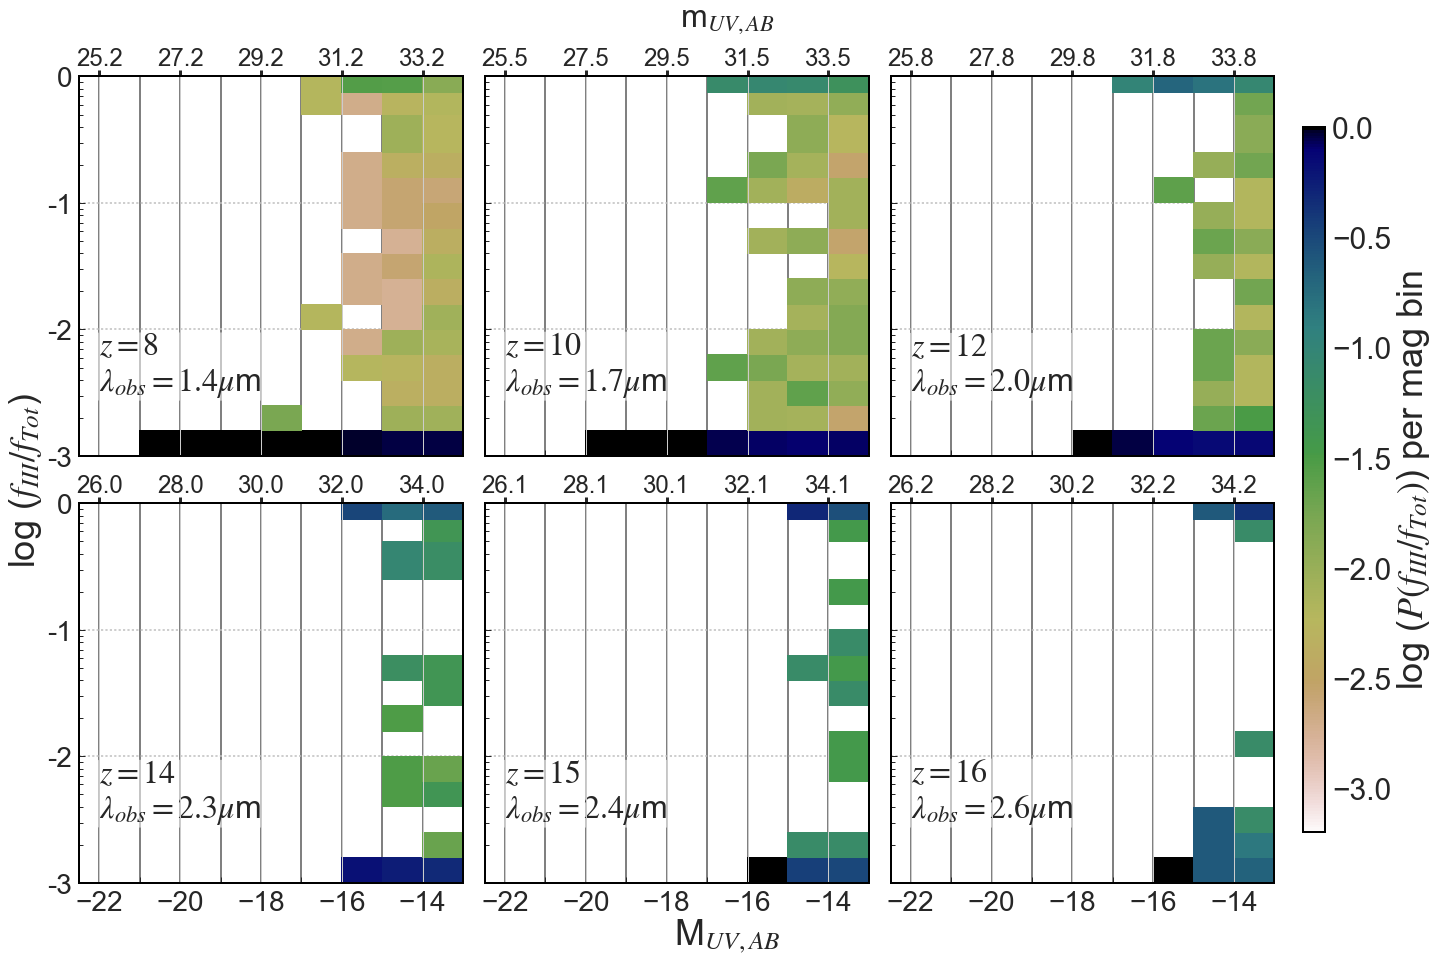

In [34]:
# Normalize the probability in each row such that it totals to 1.0

sns.set(style="whitegrid", font_scale=2, color_codes=True)
sns.set_style({'axes.edgecolor': '0.0','axes.linewidth': 2.0})

# Plot the fraction of Pop III magnitude vs M_AB NORMALIZED...

brightM = -22
limitM  = brightM+9
rgForSFunc = np.arange(brightM,limitM, 0.1)

magBins = np.linspace(brightM,limitM,(-brightM+limitM)*1 + 1) 
fracBins = np.logspace(-3,0,23)
# Contrived bin spacing such that the top bin represents .75-1.0 Pop III fraction
# and the next bin down represents .5-0.75 ...
fracBins = [0.001,  0.00158489,  0.00251189,  0.00398107,  0.00630957,
             0.01,  0.01584893,  0.02511886,  0.03981072,  0.06309573,
             0.1,  0.15848932,  0.25118864,
             0.5,   0.75,   1.0]
# fracBins = np.linspace(1e-3,9e-3,9).tolist() +np.linspace(1e-2,9e-2,9).tolist() +np.linspace(1e-1,1e-0,9).tolist()
print("Limiting absolute magnitude: {}".format(limitM))

p3ff ={}
p3ffMix = {}
doNMnow = False
fig, axs = plt.subplots(nrows=2, ncols=3, sharex='col',sharey='row',figsize=(20,14))
for z,ax in zip([8,10,12,14,15,16], axs.flat):

    # Convert observed magnitude to Absolute ...
    absMag, pop3Mag, nmAbsMag   = compMags(z)
    # Map 0 Pop 3 flux to 1e-3... 
    pop3Fraction = haloData[dir][z]['1500A_P3']/haloData[dir][z]['1500A']
    p3ff[z] = haloData[dir][z]['1500A_P3'].sum()/haloData[dir][z]['1500A'].sum()
    print("Pop III flux fraction is {:.5f} at z={}".format(p3ff[z],z))
    pop3Fraction[pop3Fraction < 1e-3] = 1e-3  # Map Pop 3 flux < 1e-3 to 1e-3
    p3ffMix[z] = p3ff[z] # Make a copy so we can print both mixing and no-mix

    print("Working on z={}".format(z))
    # If we are back to z = 8,9,10 then generate plots for NO Mixing

    Ng = len(absMag) # Number of galaxies at this z
    print("Number of galaxies {}".format(Ng))
    # GENERATE THE HISTOGRAM and HISTOGRAM DATA in the array 'n' for
    # both the improved Pop III luminosity and the classical

    # Note that we are reversing x,y here since pcolormesh interprets them backwards!
    nTempA, binsx, binsy = np.histogram2d(pop3Fraction,absMag,bins=[fracBins,magBins],normed=False)
    # could use weights=[1/simVol for i in absMag] to normalize by vol here... 
    # normed : bool, optional
    #        If False, returns the number of samples in each bin. If True, returns the bin density 
    #        bin_count / sample_count / bin_area.

    X, Y = np.meshgrid(magBins, fracBins)  # Create a grid over the range of bins for the plot

    # Mask out 0 values before taking log10... 
    H = np.ma.masked_where(nTempA==0.0, nTempA)
    for i in range(len(H[0,:])):     # Column index i, over len of row 0
        colTot = np.sum(H[:,i])
        for j in range(len(H[:,0])): # Row index j, over len of column 0
            H[:,i][j] = H[:,i][j]/colTot
    H = np.log10(H)        # Take log of counts, we've already normalized by volume and area
    print("Largest bin value: {:.3f}, smallest {}".format(H.max(),H.min()))
    # Create the plot
    im = (ax.pcolormesh(X, Y, H, cmap=mpl.cm.gist_earth_r, vmin=-3.2, vmax=0) )
    
    ax.set_xscale('linear')
    ax.set_yscale('log')
    ax.yaxis.set_tick_params(which='major',width=1,length=6)
    ax.yaxis.set_tick_params(which='minor',width=1,length=4)
    ax.xaxis.set_tick_params(which='both',width=1,length=6)
    ax.xaxis.set_ticks(np.arange(brightM,limitM+1, 2))
    minorLocator = ticker.MultipleLocator(1)
    ax.xaxis.set_minor_locator(minorLocator)
    ax.get_yaxis().set_tick_params(which='both', direction='in',labelsize=28)
    ax.get_xaxis().set_tick_params(which='both', direction='in',labelsize=28)
    ax.yaxis.set_major_formatter(logfmt)
    ax.set_xlim([brightM-0.5,limitM])
    ax.set_ylim([1e-3,1.0])
    ax.grid(which='major', axis='y', color='0.75', linestyle=':', linewidth=1.5)
    ax.grid(which='both', axis='x', color='0.5', linestyle='-', linewidth=2.0)

    # Top x-axis labels ... m_ab
    ax2 = ax.twiny()
    ax2.set_xlim([brightM-0.5,limitM]) # required...
    axXtics = ax.get_xticks()
    ax2.set_xticks(axXtics)   # Set the location of the tics same as for ax
    ax2Xs = getMag(axXtics,z) # Convert M_ab -> m_ab
    ax2.set_xticklabels(["{:.1f}".format(i) for i in ax2Xs])
    ax2.xaxis.set_tick_params(which='major',width=3,length=6,direction='out',pad=0)
    ax2.get_xaxis().set_tick_params(labelsize=24)
    
    ax.annotate('$z={}$\n$\lambda_{{obs}}={:.1f} \mu$m'.format(z,0.15*(1+z)+0.0001), xy = (0.5, 0.5), 
                xytext = (0.052, 0.15), xycoords='axes fraction',
                bbox = {'boxstyle': 'round,pad=0.05', 'fc': 'w', 'ec': 'None', 'alpha': 0.55},
                textcoords = 'axes fraction', ha = 'left', va = 'bottom',fontsize=32)


    # plt.gca().invert_xaxis()
    gc.collect()
    
plt.subplots_adjust(left=0.05, bottom=0.1, right=.88, top=0.90, wspace=.057, hspace=.125)

fig.text(0.5, 0.95,'m$_{UV,AB}$', ha='center',size=32 )
fig.text(0.5, 0.04,'M$_{UV,AB}$', ha='center',size=36 )
fig.text(0.00, 0.5, r'log ($f_{III}/f_{Tot}$)',size=36,va='center', rotation='vertical')

# Create the colorbar
cbar_ax = fig.add_axes([0.9, 0.15, 0.015, 0.7])
cbar = fig.colorbar(im, cax=cbar_ax)

cbar.ax.tick_params(labelsize=30) 
#cbar.ax.set_yticklabels(['1', '2', '4', '6', '10', maxCV], size=24)
cbar.set_label("log ($P(f_{III}/f_{Tot})$) per mag bin",fontsize=36)
plt.savefig("PopIII_fraction-Histograms-all6-noClassic.pdf",dpi=fig.dpi,bbox_inches='tight')

gc.collect()

Limiting absolute magnitude: -13
Convert to Abs Mag. DM = 47.20 @ z=8.0
Pop III flux fraction is 0.01515 at z=8
Working on z=8
************************************************************
Working on the NON MIXING flux fractions for or galaxies ...
************************************************************
z=8 overall mixing p3ff=0.015, no mixing p3ff=0.003
z=8 PopIII mixing/no mixing=4.720
Number of galaxies 4563
Largest bin value: 0.000, smallest -3.218535505216528
Convert to Abs Mag. DM = 47.38 @ z=9.0
Pop III flux fraction is 0.11445 at z=9
Working on z=9
************************************************************
Working on the NON MIXING flux fractions for or galaxies ...
************************************************************
z=9 overall mixing p3ff=0.114, no mixing p3ff=0.042
z=9 PopIII mixing/no mixing=2.860
Number of galaxies 1468
Largest bin value: 0.000, smallest -2.678518379040114


/Users/earnric/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:71: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.


Convert to Abs Mag. DM = 47.54 @ z=10.0
Pop III flux fraction is 0.05494 at z=10
Working on z=10
************************************************************
Working on the NON MIXING flux fractions for or galaxies ...
************************************************************
z=10 overall mixing p3ff=0.055, no mixing p3ff=0.023
z=10 PopIII mixing/no mixing=2.410
Number of galaxies 1021
Largest bin value: 0.000, smallest -2.545307116465824


12358

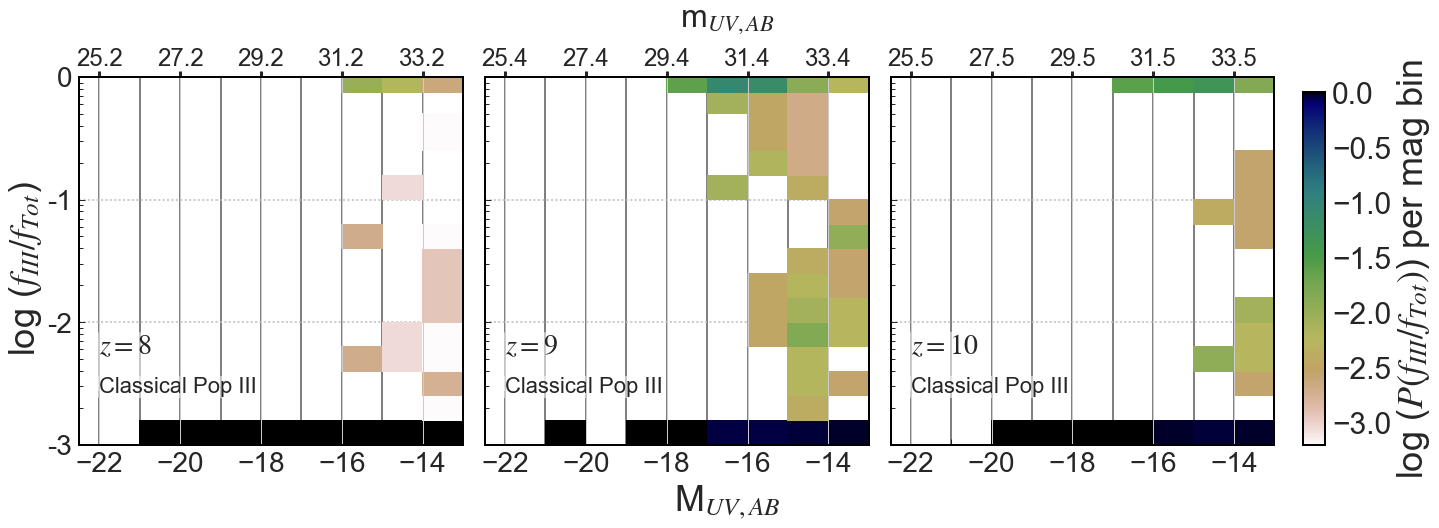

In [35]:
# Normalize the probability in each row such that it totals to 1.0

sns.set(style="whitegrid", font_scale=2, color_codes=True)
sns.set_style({'axes.edgecolor': '0.0','axes.linewidth': 2.0})

# Plot the fraction of Pop III magnitude vs M_AB NORMALIZED...

brightM = -22
limitM  = brightM+9
rgForSFunc = np.arange(brightM,limitM, 0.1)

magBins = np.linspace(brightM,limitM,(-brightM+limitM)*1 + 1) 
fracBins = np.logspace(-3,0,23)
# Contrived bin spacing such that the top bin represents .75-1.0 Pop III fraction
# and the next bin down represents .5-0.75 ...
fracBins = [0.001,  0.00158489,  0.00251189,  0.00398107,  0.00630957,
             0.01,  0.01584893,  0.02511886,  0.03981072,  0.06309573,
             0.1,  0.15848932,  0.25118864,
             0.5,   0.75,   1.0]
# fracBins = np.linspace(1e-3,9e-3,9).tolist() +np.linspace(1e-2,9e-2,9).tolist() +np.linspace(1e-1,1e-0,9).tolist()
print("Limiting absolute magnitude: {}".format(limitM))

p3ff ={}
p3ffMix = {}
doNMnow = True
fig, axs = plt.subplots(nrows=1, ncols=3, sharex='col',sharey='row',figsize=(20,7))
for z,ax in zip([8,9,10], axs.flat):

    # Convert observed magnitude to Absolute ...
    absMag, pop3Mag, nmAbsMag   = compMags(z)
    # Map 0 Pop 3 flux to 1e-3... 
    pop3Fraction = haloData[dir][z]['1500A_P3']/haloData[dir][z]['1500A']
    p3ff[z] = haloData[dir][z]['1500A_P3'].sum()/haloData[dir][z]['1500A'].sum()
    print("Pop III flux fraction is {:.5f} at z={}".format(p3ff[z],z))
    pop3Fraction[pop3Fraction < 1e-3] = 1e-3  # Map Pop 3 flux < 1e-3 to 1e-3
    p3ffMix[z] = p3ff[z] # Make a copy so we can print both mixing and no-mix

    print("Working on z={}".format(z))
    # If we are back to z = 8,9,10 then generate plots for NO Mixing
    if doNMnow:
        print("************************************************************")
        print("Working on the NON MIXING flux fractions for or galaxies ...")
        print("************************************************************")
        pop3Fraction = haloData[dir][z]['1500A_P3NM']/haloData[dir][z]['1500A_NM']
        p3ff[z] = haloData[dir][z]['1500A_P3NM'].sum()/haloData[dir][z]['1500A_NM'].sum()
#         print("Pop III flux fraction is {:.5f} at z={}".format(p3ffNM[z],z))
        pop3Fraction[pop3Fraction < 1e-3] = 1e-3  # Map Pop 3 flux < 1e-3 to 1e-3
        absMag = nmAbsMag ## Do plots for NO MIXING version of data... 
        print("z={} overall mixing p3ff={:.3f}, no mixing p3ff={:.3f}".format(z,p3ffMix[z],p3ff[z]))
        print("z={} PopIII mixing/no mixing={:.3f}".format(z,haloData[dir][z]['1500A_P3'].sum()/haloData[dir][z]['1500A_P3NM'].sum()))
        
    Ng = len(absMag) # Number of galaxies at this z
    print("Number of galaxies {}".format(Ng))
    # GENERATE THE HISTOGRAM and HISTOGRAM DATA in the array 'n' for
    # both the improved Pop III luminosity and the classical

    # Note that we are reversing x,y here since pcolormesh interprets them backwards!
    nTempA, binsx, binsy = np.histogram2d(pop3Fraction,absMag,bins=[fracBins,magBins],normed=False)
    # could use weights=[1/simVol for i in absMag] to normalize by vol here... 
    # normed : bool, optional
    #        If False, returns the number of samples in each bin. If True, returns the bin density 
    #        bin_count / sample_count / bin_area.

    X, Y = np.meshgrid(magBins, fracBins)  # Create a grid over the range of bins for the plot

    # Mask out 0 values before taking log10... 
    H = np.ma.masked_where(nTempA==0.0, nTempA)
    for i in range(len(H[0,:])):     # Column index i, over len of row 0
        colTot = np.sum(H[:,i])
        for j in range(len(H[:,0])): # Row index j, over len of column 0
            H[:,i][j] = H[:,i][j]/colTot
    H = np.log10(H)        # Take log of counts, we've already normalized by volume and area
    print("Largest bin value: {:.3f}, smallest {}".format(H.max(),H.min()))
    # Create the plot
    im = (ax.pcolormesh(X, Y, H, cmap=mpl.cm.gist_earth_r, vmin=-3.2, vmax=0) )
    
    ax.set_xscale('linear')
    ax.set_yscale('log')
    ax.yaxis.set_tick_params(which='major',width=1,length=6)
    ax.yaxis.set_tick_params(which='minor',width=1,length=4)
    ax.xaxis.set_tick_params(which='both',width=1,length=6)
    ax.xaxis.set_ticks(np.arange(brightM,limitM+1, 2))
    minorLocator = ticker.MultipleLocator(1)
    ax.xaxis.set_minor_locator(minorLocator)
    ax.get_yaxis().set_tick_params(which='both', direction='in',labelsize=28)
    ax.get_xaxis().set_tick_params(which='both', direction='in',labelsize=28)
    ax.yaxis.set_major_formatter(logfmt)
    ax.set_xlim([brightM-0.5,limitM])
    ax.set_ylim([1e-3,1.0])
    ax.grid(which='major', axis='y', color='0.75', linestyle=':', linewidth=1.5)
    ax.grid(which='both', axis='x', color='0.5', linestyle='-', linewidth=2.0)

    # Top x-axis labels ... m_ab
    ax2 = ax.twiny()
    ax2.set_xlim([brightM-0.5,limitM]) # required...
    axXtics = ax.get_xticks()
    ax2.set_xticks(axXtics)   # Set the location of the tics same as for ax
    ax2Xs = getMag(axXtics,z) # Convert M_ab -> m_ab
    ax2.set_xticklabels(["{:.1f}".format(i) for i in ax2Xs])
    ax2.xaxis.set_tick_params(which='major',width=3,length=6,direction='out',pad=0)
    ax2.get_xaxis().set_tick_params(labelsize=24)

    # plt.gca().invert_xaxis()
    gc.collect()
    
    if doNMnow:
        ax.annotate('$z={}$\n'.format(z,0.15*(1+z)+0.0001), xy = (0.5, 0.5), 
                xytext = (0.052, 0.15), xycoords='axes fraction',
                bbox = {'boxstyle': 'round,pad=0.05', 'fc': 'w', 'ec': 'None', 'alpha': 0.55},
                textcoords = 'axes fraction', ha = 'left', va = 'bottom',fontsize=28)
        ax.annotate('Classical Pop III'.format(z,0.15*(1+z)+0.0001), xy = (0.5, 0.5), 
                xytext = (0.052, 0.13), xycoords='axes fraction',
                bbox = {'boxstyle': 'round,pad=0.05', 'fc': 'w', 'ec': 'None', 'alpha': 0.55},
                textcoords = 'axes fraction', ha = 'left', va = 'bottom',fontsize=22)
    else:
        ax.annotate('$z={}$\n$\lambda_{{obs}}={:.1f} \mu$m'.format(z,0.15*(1+z)+0.0001), xy = (0.5, 0.5), 
                xytext = (0.052, 0.15), xycoords='axes fraction',
                bbox = {'boxstyle': 'round,pad=0.05', 'fc': 'w', 'ec': 'None', 'alpha': 0.55},
                textcoords = 'axes fraction', ha = 'left', va = 'bottom',fontsize=28)


plt.subplots_adjust(left=0.05, bottom=0.15, right=.88, top=0.88, wspace=.057, hspace=.125)

fig.text(0.5, 0.98,'m$_{UV,AB}$', ha='center',size=32 )
fig.text(0.5, 0.02,'M$_{UV,AB}$', ha='center',size=36 )
fig.text(0.00, 0.5, r'log ($f_{III}/f_{Tot}$)',size=36,va='center', rotation='vertical')

# Create the colorbar
cbar_ax = fig.add_axes([0.9, 0.15, 0.015, 0.7])
cbar = fig.colorbar(im, cax=cbar_ax)

cbar.ax.tick_params(labelsize=30) 
#cbar.ax.set_yticklabels(['1', '2', '4', '6', '10', maxCV], size=24)
cbar.set_label("log ($P(f_{III}/f_{Tot})$) per mag bin",fontsize=36)
plt.savefig("PopIII_fraction-Histograms-Classic.pdf",dpi=fig.dpi,bbox_inches='tight')

gc.collect()

Limiting absolute magnitude: -13
Convert to Abs Mag. DM = 47.38 @ z=9.0
Pop III flux fraction is 0.11445 at z=9
Working on z=9
Number of galaxies 1468
Largest bin value: 0.000, smallest -2.6720978579357175
Convert to Abs Mag. DM = 47.54 @ z=10.0
Pop III flux fraction is 0.05494 at z=10
Working on z=10
Number of galaxies 1021
Largest bin value: 0.000, smallest -2.54282542695918


/Users/earnric/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:72: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.


Convert to Abs Mag. DM = 47.68 @ z=11.0
Pop III flux fraction is 0.07623 at z=11
Working on z=11
Number of galaxies 687
Largest bin value: 0.000, smallest -2.367355921026019
FINISHED with z=8-12
Convert to Abs Mag. DM = 47.38 @ z=9.0
Pop III flux fraction is 0.11445 at z=9
Working on z=9
************************************************************
Working on the NON MIXING flux fractions for or galaxies ...
************************************************************
z=9 overall mixing p3ff=0.114, no mixing p3ff=0.042
z=9 PopIII mixing/no mixing=2.860
Number of galaxies 1468
Largest bin value: 0.000, smallest -2.678518379040114
Convert to Abs Mag. DM = 47.54 @ z=10.0
Pop III flux fraction is 0.05494 at z=10
Working on z=10
************************************************************
Working on the NON MIXING flux fractions for or galaxies ...
************************************************************
z=10 overall mixing p3ff=0.055, no mixing p3ff=0.023
z=10 PopIII mixing/no mixing=2.

4541

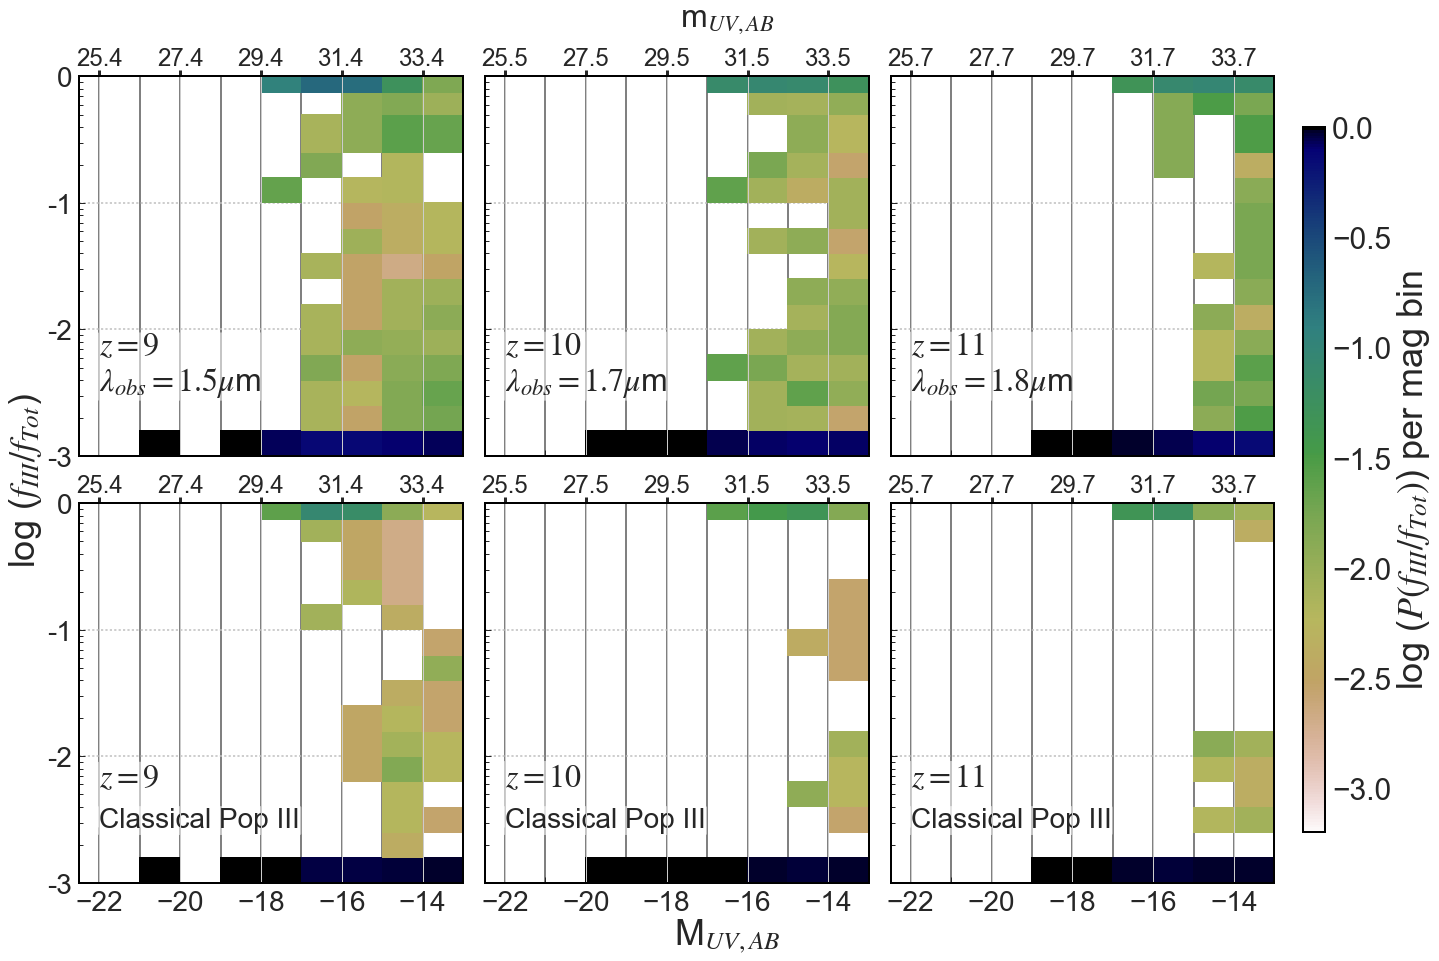

In [36]:
# Normalize the probability in each row such that it totals to 1.0

sns.set(style="whitegrid", font_scale=2, color_codes=True)
sns.set_style({'axes.edgecolor': '0.0','axes.linewidth': 2.0})

# Plot the fraction of Pop III magnitude vs M_AB NORMALIZED...

brightM = -22
limitM  = brightM+9
rgForSFunc = np.arange(brightM,limitM, 0.1)

magBins = np.linspace(brightM,limitM,(-brightM+limitM)*1 + 1) 
fracBins = np.logspace(-3,0,23)
# Contrived bin spacing such that the top bin represents .75-1.0 Pop III fraction
# and the next bin down represents .5-0.75 ...
fracBins = [0.001,  0.00158489,  0.00251189,  0.00398107,  0.00630957,
             0.01,  0.01584893,  0.02511886,  0.03981072,  0.06309573,
             0.1,  0.15848932,  0.25118864,
             0.5,   0.75,   1.0]
# fracBins = np.linspace(1e-3,9e-3,9).tolist() +np.linspace(1e-2,9e-2,9).tolist() +np.linspace(1e-1,1e-0,9).tolist()
print("Limiting absolute magnitude: {}".format(limitM))

p3ff ={}
p3ffMix = {}
doNMnow = False
fig, axs = plt.subplots(nrows=2, ncols=3, sharex='col',sharey='row',figsize=(20,14))
z_range = np.array([9,10,11,9,10,11])
for z,ax in zip(z_range, axs.flat):

    # Convert observed magnitude to Absolute ...
    absMag, pop3Mag, nmAbsMag   = compMags(z)
    # Map 0 Pop 3 flux to 1e-3... 
    pop3Fraction = haloData[dir][z]['1500A_P3']/haloData[dir][z]['1500A']
    p3ff[z] = haloData[dir][z]['1500A_P3'].sum()/haloData[dir][z]['1500A'].sum()
    print("Pop III flux fraction is {:.5f} at z={}".format(p3ff[z],z))
    pop3Fraction[pop3Fraction < 1e-3] = 1e-3  # Map Pop 3 flux < 1e-3 to 1e-3
    p3ffMix[z] = p3ff[z] # Make a copy so we can print both mixing and no-mix

    print("Working on z={}".format(z))
    # If we are back to z = 8,9,10 then generate plots for NO Mixing
    if doNMnow:
        print("************************************************************")
        print("Working on the NON MIXING flux fractions for or galaxies ...")
        print("************************************************************")
        pop3Fraction = haloData[dir][z]['1500A_P3NM']/haloData[dir][z]['1500A_NM']
        p3ff[z] = haloData[dir][z]['1500A_P3NM'].sum()/haloData[dir][z]['1500A_NM'].sum()
#         print("Pop III flux fraction is {:.5f} at z={}".format(p3ffNM[z],z))
        pop3Fraction[pop3Fraction < 1e-3] = 1e-3  # Map Pop 3 flux < 1e-3 to 1e-3
        absMag = nmAbsMag ## Do plots for NO MIXING version of data... 
        print("z={} overall mixing p3ff={:.3f}, no mixing p3ff={:.3f}".format(z,p3ffMix[z],p3ff[z]))
        print("z={} PopIII mixing/no mixing={:.3f}".format(z,haloData[dir][z]['1500A_P3'].sum()/haloData[dir][z]['1500A_P3NM'].sum()))
        
    Ng = len(absMag) # Number of galaxies at this z
    print("Number of galaxies {}".format(Ng))
    # GENERATE THE HISTOGRAM and HISTOGRAM DATA in the array 'n' for
    # both the improved Pop III luminosity and the classical

    # Note that we are reversing x,y here since pcolormesh interprets them backwards!
    nTempA, binsx, binsy = np.histogram2d(pop3Fraction,absMag,bins=[fracBins,magBins],normed=False)
    # could use weights=[1/simVol for i in absMag] to normalize by vol here... 
    # normed : bool, optional
    #        If False, returns the number of samples in each bin. If True, returns the bin density 
    #        bin_count / sample_count / bin_area.

    X, Y = np.meshgrid(magBins, fracBins)  # Create a grid over the range of bins for the plot

    # Mask out 0 values before taking log10... 
    H = np.ma.masked_where(nTempA==0.0, nTempA)
    for i in range(len(H[0,:])):     # Column index i, over len of row 0
        colTot = np.sum(H[:,i])
        for j in range(len(H[:,0])): # Row index j, over len of column 0
            H[:,i][j] = H[:,i][j]/colTot
    H = np.log10(H)        # Take log of counts, we've already normalized by volume and area
    print("Largest bin value: {:.3f}, smallest {}".format(H.max(),H.min()))
    # Create the plot
    im = (ax.pcolormesh(X, Y, H, cmap=mpl.cm.gist_earth_r, vmin=-3.2, vmax=0) )
    
    ax.set_xscale('linear')
    ax.set_yscale('log')
    ax.yaxis.set_tick_params(which='major',width=1,length=6)
    ax.yaxis.set_tick_params(which='minor',width=1,length=4)
    ax.xaxis.set_tick_params(which='both',width=1,length=6)
    ax.xaxis.set_ticks(np.arange(brightM,limitM+1, 2))
    minorLocator = ticker.MultipleLocator(1)
    ax.xaxis.set_minor_locator(minorLocator)
    ax.get_yaxis().set_tick_params(which='both', direction='in',labelsize=28)
    ax.get_xaxis().set_tick_params(which='both', direction='in',labelsize=28)
    ax.yaxis.set_major_formatter(logfmt)
    ax.set_xlim([brightM-0.5,limitM])
    ax.set_ylim([1e-3,1.0])
    ax.grid(which='major', axis='y', color='0.75', linestyle=':', linewidth=1.5)
    ax.grid(which='both', axis='x', color='0.5', linestyle='-', linewidth=2.0)

    # Top x-axis labels ... m_ab
    ax2 = ax.twiny()
    ax2.set_xlim([brightM-0.5,limitM]) # required...
    axXtics = ax.get_xticks()
    ax2.set_xticks(axXtics)   # Set the location of the tics same as for ax
    ax2Xs = getMag(axXtics,z) # Convert M_ab -> m_ab
    ax2.set_xticklabels(["{:.1f}".format(i) for i in ax2Xs])
    ax2.xaxis.set_tick_params(which='major',width=3,length=6,direction='out',pad=0)
    ax2.get_xaxis().set_tick_params(labelsize=24)

    # plt.gca().invert_xaxis()
    gc.collect()
    
    if doNMnow:
        ax.annotate('$z={}$\n'.format(z,0.15*(1+z)+0.0001), xy = (0.5, 0.5), 
                xytext = (0.052, 0.15), xycoords='axes fraction',
                bbox = {'boxstyle': 'round,pad=0.05', 'fc': 'w', 'ec': 'None', 'alpha': 0.55},
                textcoords = 'axes fraction', ha = 'left', va = 'bottom',fontsize=32)
        ax.annotate('Classical Pop III'.format(z,0.15*(1+z)+0.0001), xy = (0.5, 0.5), 
                xytext = (0.052, 0.13), xycoords='axes fraction',
                bbox = {'boxstyle': 'round,pad=0.05', 'fc': 'w', 'ec': 'None', 'alpha': 0.55},
                textcoords = 'axes fraction', ha = 'left', va = 'bottom',fontsize=28)
    else:
        ax.annotate('$z={}$\n$\lambda_{{obs}}={:.1f} \mu$m'.format(z,0.15*(1+z)+0.0001), xy = (0.5, 0.5), 
                xytext = (0.052, 0.15), xycoords='axes fraction',
                bbox = {'boxstyle': 'round,pad=0.05', 'fc': 'w', 'ec': 'None', 'alpha': 0.55},
                textcoords = 'axes fraction', ha = 'left', va = 'bottom',fontsize=32)

    
    ####
    #### If we just finished z=16, do z=8,9,10 for 
    #### no mixing case
    ####
    if z == z_range.max():
        print("FINISHED with z=8-12")
        doNMnow = True

plt.subplots_adjust(left=0.05, bottom=0.1, right=.88, top=0.90, wspace=.057, hspace=.125)

fig.text(0.5, 0.95,'m$_{UV,AB}$', ha='center',size=32 )
fig.text(0.5, 0.04,'M$_{UV,AB}$', ha='center',size=36 )
fig.text(0.00, 0.5, r'log ($f_{III}/f_{Tot}$)',size=36,va='center', rotation='vertical')

# Create the colorbar
cbar_ax = fig.add_axes([0.9, 0.15, 0.015, 0.7])
cbar = fig.colorbar(im, cax=cbar_ax)

cbar.ax.tick_params(labelsize=30) 
#cbar.ax.set_yticklabels(['1', '2', '4', '6', '10', maxCV], size=24)
cbar.set_label("log ($P(f_{III}/f_{Tot})$) per mag bin",fontsize=36)
plt.savefig("PopIII_fraction-Histograms-compare.pdf",dpi=fig.dpi,bbox_inches='tight')

gc.collect()

Limiting absolute magnitude: -13
Convert to Abs Mag. DM = 47.20 @ z=8.0
Pop III flux fraction is 0.01515 at z=8
Working on z=8
Number of galaxies 4563
Largest bin value: 0.000, smallest -2.741151598851785


/Users/earnric/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:60: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.


Convert to Abs Mag. DM = 47.38 @ z=9.0
Pop III flux fraction is 0.11445 at z=9
Working on z=9
Number of galaxies 1468
Largest bin value: 0.000, smallest -2.6720978579357175
Convert to Abs Mag. DM = 47.54 @ z=10.0
Pop III flux fraction is 0.05494 at z=10
Working on z=10
Number of galaxies 1021
Largest bin value: 0.000, smallest -2.54282542695918
Convert to Abs Mag. DM = 47.68 @ z=11.0
Pop III flux fraction is 0.07623 at z=11
Working on z=11
Number of galaxies 687
Largest bin value: 0.000, smallest -2.367355921026019
Convert to Abs Mag. DM = 47.80 @ z=12.0
Pop III flux fraction is 0.14715 at z=12
Working on z=12
Number of galaxies 451
Largest bin value: 0.000, smallest -2.1986570869544226
Convert to Abs Mag. DM = 47.92 @ z=13.0


KeyError: 13

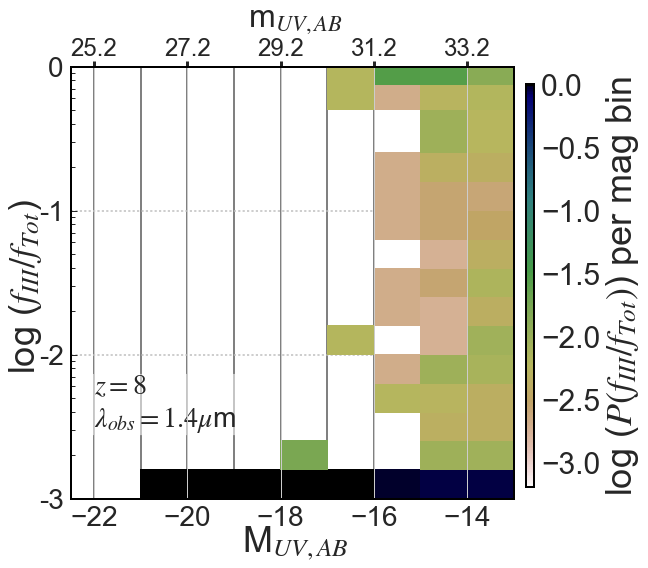

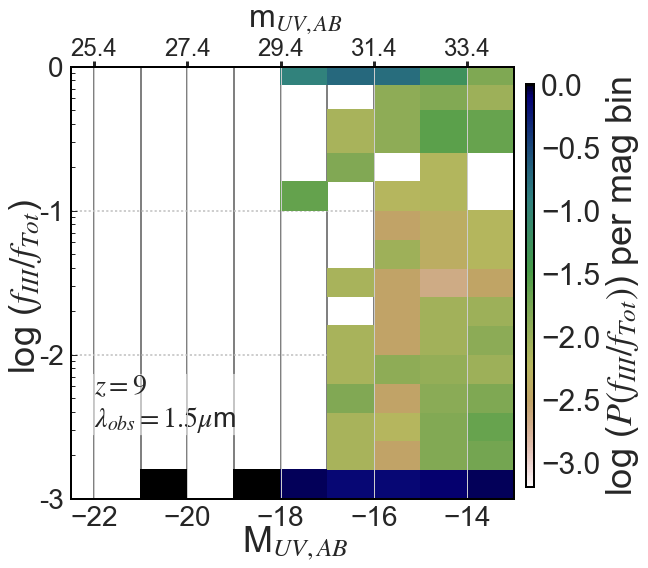

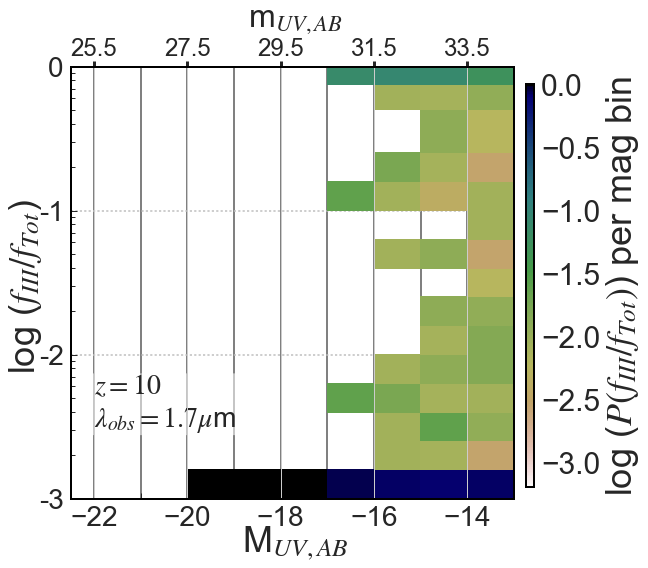

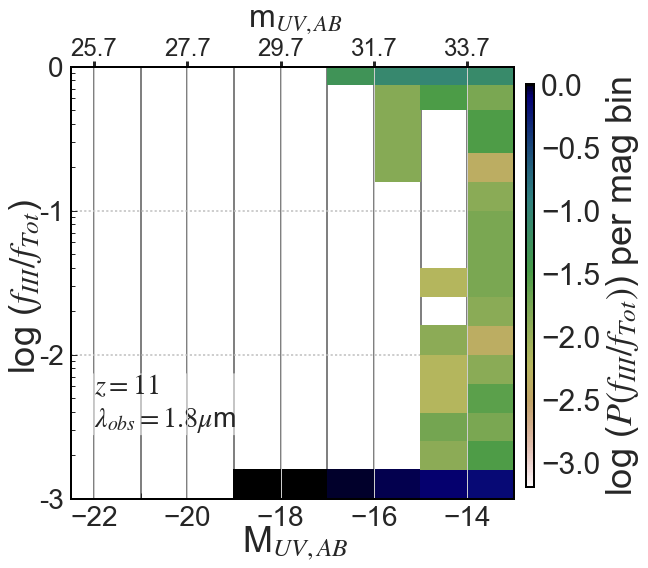

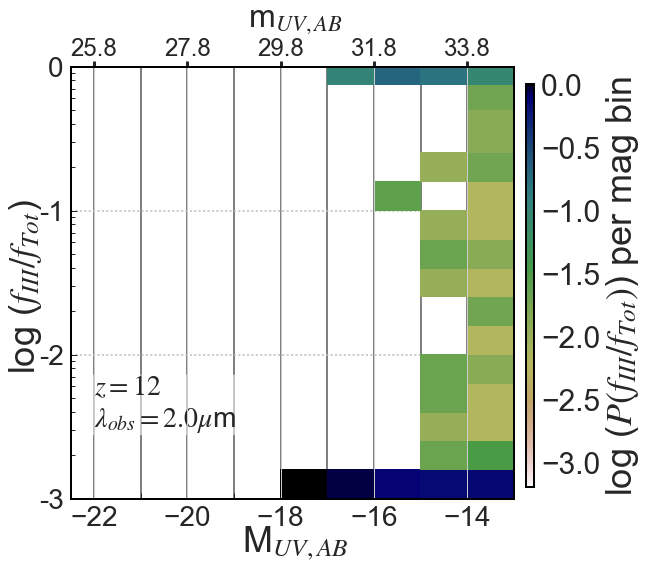

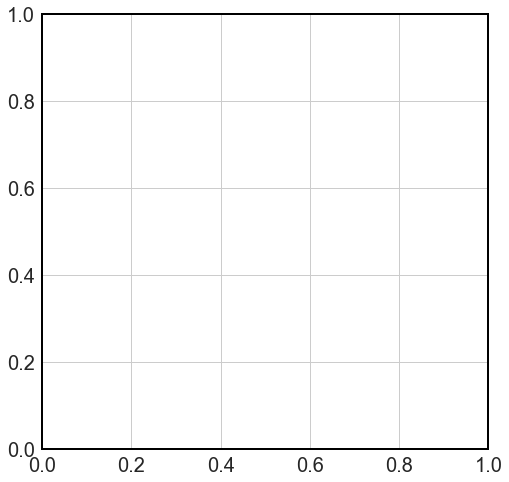

In [37]:
# Normalize the probability in each row such that it totals to 1.0

sns.set(style="whitegrid", font_scale=2, color_codes=True)
sns.set_style({'axes.edgecolor': '0.0','axes.linewidth': 2.0})

# Plot the fraction of Pop III magnitude vs M_AB NORMALIZED...

brightM = -22
limitM  = brightM+9
rgForSFunc = np.arange(brightM,limitM, 0.1)

magBins = np.linspace(brightM,limitM,(-brightM+limitM)*1 + 1) 
fracBins = np.logspace(-3,0,23)
# Contrived bin spacing such that the top bin represents .75-1.0 Pop III fraction
# and the next bin down represents .5-0.75 ...
fracBins = [0.001,  0.00158489,  0.00251189,  0.00398107,  0.00630957,
             0.01,  0.01584893,  0.02511886,  0.03981072,  0.06309573,
             0.1,  0.15848932,  0.25118864,
             0.5,   0.75,   1.0]
# fracBins = np.linspace(1e-3,9e-3,9).tolist() +np.linspace(1e-2,9e-2,9).tolist() +np.linspace(1e-1,1e-0,9).tolist()
print("Limiting absolute magnitude: {}".format(limitM))

p3ff ={}
p3ffMix = {}
doNMnow = False
for z in [8,9,10,11,12,13,14,15,16]:

    fig, ax = plt.subplots(nrows=1, ncols=1, sharex='col',sharey='row',figsize=(8,8))
    # Convert observed magnitude to Absolute ...
    absMag, pop3Mag, nmAbsMag   = compMags(z)
    # Map 0 Pop 3 flux to 1e-3... 
    pop3Fraction = haloData[dir][z]['1500A_P3']/haloData[dir][z]['1500A']
    p3ff[z] = haloData[dir][z]['1500A_P3'].sum()/haloData[dir][z]['1500A'].sum()
    print("Pop III flux fraction is {:.5f} at z={}".format(p3ff[z],z))
    pop3Fraction[pop3Fraction < 1e-3] = 1e-3  # Map Pop 3 flux < 1e-3 to 1e-3
    p3ffMix[z] = p3ff[z] # Make a copy so we can print both mixing and no-mix

    print("Working on z={}".format(z))
    # If we are back to z = 8,9,10 then generate plots for NO Mixing

    Ng = len(absMag) # Number of galaxies at this z
    print("Number of galaxies {}".format(Ng))
    # GENERATE THE HISTOGRAM and HISTOGRAM DATA in the array 'n' for
    # both the improved Pop III luminosity and the classical

    # Note that we are reversing x,y here since pcolormesh interprets them backwards!
    nTempA, binsx, binsy = np.histogram2d(pop3Fraction,absMag,bins=[fracBins,magBins],normed=False)
    # could use weights=[1/simVol for i in absMag] to normalize by vol here... 
    # normed : bool, optional
    #        If False, returns the number of samples in each bin. If True, returns the bin density 
    #        bin_count / sample_count / bin_area.

    X, Y = np.meshgrid(magBins, fracBins)  # Create a grid over the range of bins for the plot

    # Mask out 0 values before taking log10... 
    H = np.ma.masked_where(nTempA==0.0, nTempA)
    for i in range(len(H[0,:])):     # Column index i, over len of row 0
        colTot = np.sum(H[:,i])
        for j in range(len(H[:,0])): # Row index j, over len of column 0
            H[:,i][j] = H[:,i][j]/colTot
    H = np.log10(H)        # Take log of counts, we've already normalized by volume and area
    print("Largest bin value: {:.3f}, smallest {}".format(H.max(),H.min()))
    # Create the plot
    im = (ax.pcolormesh(X, Y, H, cmap=mpl.cm.gist_earth_r, vmin=-3.2, vmax=0) )
    
    ax.set_xscale('linear')
    ax.set_yscale('log')
    ax.yaxis.set_tick_params(which='major',width=1,length=6)
    ax.yaxis.set_tick_params(which='minor',width=1,length=4)
    ax.xaxis.set_tick_params(which='both',width=1,length=6)
    ax.xaxis.set_ticks(np.arange(brightM,limitM+1, 2))
    minorLocator = ticker.MultipleLocator(1)
    ax.xaxis.set_minor_locator(minorLocator)
    ax.get_yaxis().set_tick_params(which='both', direction='in',labelsize=28)
    ax.get_xaxis().set_tick_params(which='both', direction='in',labelsize=28)
    ax.yaxis.set_major_formatter(logfmt)
    ax.set_xlim([brightM-0.5,limitM])
    ax.set_ylim([1e-3,1.0])
    ax.grid(which='major', axis='y', color='0.75', linestyle=':', linewidth=1.5)
    ax.grid(which='both', axis='x', color='0.5', linestyle='-', linewidth=2.0)

    # Top x-axis labels ... m_ab
    ax2 = ax.twiny()
    ax2.set_xlim([brightM-0.5,limitM]) # required...
    axXtics = ax.get_xticks()
    ax2.set_xticks(axXtics)   # Set the location of the tics same as for ax
    ax2Xs = getMag(axXtics,z) # Convert M_ab -> m_ab
    ax2.set_xticklabels(["{:.1f}".format(i) for i in ax2Xs])
    ax2.xaxis.set_tick_params(which='major',width=3,length=6,direction='out',pad=0)
    ax2.get_xaxis().set_tick_params(labelsize=24)
    
    ax.annotate('$z={}$\n$\lambda_{{obs}}={:.1f} \mu$m'.format(z,0.15*(1+z)+0.0001), xy = (0.5, 0.5), 
                xytext = (0.052, 0.15), xycoords='axes fraction',
                bbox = {'boxstyle': 'round,pad=0.05', 'fc': 'w', 'ec': 'None', 'alpha': 0.55},
                textcoords = 'axes fraction', ha = 'left', va = 'bottom',fontsize=28)


    # plt.gca().invert_xaxis()
    gc.collect()
    
    plt.subplots_adjust(left=0.11, bottom=0.13, right=.88, top=0.88, wspace=.057, hspace=.125)

    fig.text(0.5, 0.95,'m$_{UV,AB}$', ha='center',size=32 )
    fig.text(0.5, 0.04,'M$_{UV,AB}$', ha='center',size=36 )
    fig.text(0.00, 0.5, r'log ($f_{III}/f_{Tot}$)',size=36,va='center', rotation='vertical')

    # Create the colorbar
    cbar_ax = fig.add_axes([0.9, 0.15, 0.015, 0.7])
    cbar = fig.colorbar(im, cax=cbar_ax)

    cbar.ax.tick_params(labelsize=30) 
    #cbar.ax.set_yticklabels(['1', '2', '4', '6', '10', maxCV], size=24)
    cbar.set_label("log ($P(f_{III}/f_{Tot})$) per mag bin",fontsize=36)
    plt.savefig("PopIII_fraction-Histograms-{:.1f}.pdf".format(z),dpi=fig.dpi,bbox_inches='tight')
    del fig, ax

gc.collect()

In [38]:
pd.set_option('precision', 3)
pd.set_option('display.latex.escape',False)
p3fracTab

NameError: name 'p3fracTab' is not defined

In [39]:
print(p3fracTab.to_latex(index=False))

NameError: name 'p3fracTab' is not defined

In [40]:
np.set_printoptions(precision=3)
print(10**H)

[[-- -- -- -- 1.0 0.9 0.775 0.7157894736842105 0.7468354430379747]
 [-- -- -- -- -- -- -- 0.021052631578947368 0.03164556962025316]
 [-- -- -- -- -- -- -- 0.010526315789473682 0.006329113924050633]
 [-- -- -- -- -- -- -- 0.021052631578947368 0.006329113924050633]
 [-- -- -- -- -- -- -- 0.021052631578947368 0.012658227848101267]
 [-- -- -- -- -- -- -- -- 0.006329113924050633]
 [-- -- -- -- -- -- -- -- 0.018987341772151896]
 [-- -- -- -- -- -- -- 0.010526315789473682 0.006329113924050633]
 [-- -- -- -- -- -- -- 0.021052631578947368 0.012658227848101267]
 [-- -- -- -- -- -- -- 0.010526315789473682 0.006329113924050633]
 [-- -- -- -- -- -- 0.025000000000000005 -- 0.006329113924050633]
 [-- -- -- -- -- -- -- 0.010526315789473682 0.018987341772151896]
 [-- -- -- -- -- -- -- -- 0.012658227848101267]
 [-- -- -- -- -- -- -- -- 0.018987341772151896]
 [-- -- -- -- -- 0.1 0.20000000000000004 0.15789473684210523
  0.08860759493670885]]


In [41]:
len(pop3Fraction[pop3Fraction> 0.75])/len(pop3Fraction)

0.11529933481152993

## Print out a table of P3 fractions in the 75 and 50% bins... 

** Remember to add the contributions of bins when discussing, say, f_III fraction > 50% includes
the prob from the 75% bin... **

In [43]:
brightM = -22
limitM  = brightM+9

In [44]:
magBins = np.linspace(brightM,limitM,(-brightM+limitM)*1 + 1) 
print(magBins)

[-22. -21. -20. -19. -18. -17. -16. -15. -14. -13.]


### Build tables showing f_III/f_tot = f(z,M_AB)

In [45]:
np.set_printoptions(linewidth=105)

In [46]:
# Normalize the probability in each row such that it totals to 1.0

brightM = -20
limitM  = -14
rgForSFunc = np.arange(brightM,limitM, 0.1)

magBins = np.linspace(brightM,limitM,(-brightM+limitM)*1 + 1) 
fracBins = np.logspace(-3,0,23)
fracBins = [0.001,  0.00158489,  0.00251189,  0.00398107,  0.00630957,
             0.01,  0.01584893,  0.02511886,  0.03981072,  0.06309573,
             0.1,  0.15848932,  0.25118864,
             0.5,   0.75,   1.0] # Force bins at 50% and 75% flux
print(["{}".format(i) for i in magBins])

headers = np.concatenate(([['z'],magBins[1:]]))
df75 = pd.DataFrame( columns=headers)
df50 = pd.DataFrame( columns=headers)

mat75 = np.array([])
mat50 = np.array([])
errors75 = []
ii = 0;
for z in np.sort([8,9,10,11,12,13,14,15,16]):

    # Convert observed magnitude to Absolute ...
    absMag, pop3Mag, nmAbsMag   = compMags(z)
    # Map 0 Pop 3 flux to 1e-3... 
    pop3Fraction                      = haloData[dir][z]['1500A_P3']/haloData[dir][z]['1500A']
    pop3Fraction[pop3Fraction < 1e-3] = 1e-3  # Map Pop 3 flux < 1e-3 to 1e-3
    obsmag = mag(haloData[dir][z]['1500A']) # Compute the observational UV mag: m_AB
    
    Ng = len(absMag) # Number of galaxies at this z
    # GENERATE THE HISTOGRAM and HISTOGRAM DATA in the array 'n' for
    # both the improved Pop III luminosity and the classical

    # Note that we are reversing x,y here since pcolormesh interprets them backwards!
    n, binsx, binsy = np.histogram2d(pop3Fraction,absMag,bins=[fracBins,magBins],normed=False)
    # could use weights=[1/simVol for i in absMag] to normalize by vol here... 
    # normed : bool, optional
    #        If False, returns the number of samples in each bin. If True, returns the bin density 
    #        bin_count / sample_count / bin_area.

    # Mask out 0 values before taking log10... 
    H = np.ma.masked_where(n==0.0, n)
    for i in range(len(H[0,:])):     # Column index i, over len of row 0
        colTot = np.sum(H[:,i])
        for j in range(len(H[:,0])): # Row index j, over len of column 0
            H[:,i][j] = H[:,i][j]/colTot # H is not a fraction (probability)

    # Compute error bound
    # REMEMBER, n is upside-down! Last row is > 75%
    errors75.append(np.array([np.sqrt(n[-1,i])/np.sum(n[:,i]) for i in range(len(n[0,:]))]))
    #     print("errors: ",errors75)
    #     print([np.sum(n[:,i]) for i in range(len(n[0,:]))])
    # Create arrays where fraction is greater than 50% and 75% ... 
    # REMEMBER: have to add the 73% bin to the 50% if we want combined P(>.50)
    H = np.ma.filled(H, fill_value=0.0)

    #########################################################################
    ##### Extract the "top two" rows ... these are bins 53% and 73% #########
    ##### if you change fracBins this changes!!!! ***************************
    ##### Also, the rows are actually at the BOTTOM of the matrix.. not the top
    #########################################################################
    gt50 = H[-2,:]
    gt75 = H[-1,:]
#     print("z={}, H (> 53 and 73% respectively): \n{}\n{}".format(z,["{:.4f}".format(x) for x in gt50+gt75],
#                                                                             ["{:.4f}".format(x) for x in gt75]))
    df75.loc[ii] = np.concatenate(([z],gt75))
    df50.loc[ii] = np.concatenate(([z],gt50+gt75)) ## Sum the fraction > .73 and .53 < frac < .73
    if z == 8: # first one
        print(gt75)
        # Build a new matrix with P3 frac vs M_AB 
        mat75 = np.append(mat75,gt75)
        mat50 = np.append(mat50,gt50+gt75)
    else:
        mat75 = np.vstack((mat75,gt75)) # A matrix (for plotting) of the table
        mat50 = np.vstack((mat50,gt50+gt75)) # a matrix of the table... 
    ii += 1
gc.collect()
# df75.index = range(8,16)
# df50.index = range(8,16)
print("> 75 and 50% respectively")
print (df75.to_string(index=False))
print (df50.to_string(index=False))
errors75=np.array(np.nan_to_num(errors75))

['-20.0', '-19.0', '-18.0', '-17.0', '-16.0', '-15.0', '-14.0']
Convert to Abs Mag. DM = 47.20 @ z=8.0
[ 0.     0.     0.     0.006  0.028  0.028]
Convert to Abs Mag. DM = 47.38 @ z=9.0
Convert to Abs Mag. DM = 47.54 @ z=10.0
Convert to Abs Mag. DM = 47.68 @ z=11.0
Convert to Abs Mag. DM = 47.80 @ z=12.0
Convert to Abs Mag. DM = 47.92 @ z=13.0


/Users/earnric/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:48: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.


KeyError: 13

In [47]:
# Normalize the probability in each row such that it totals to 1.0

#
# NO MIXING data 
#

brightM = -20
limitM  = -14
rgForSFunc = np.arange(brightM,limitM, 0.1)

magBins = np.linspace(brightM,limitM,(-brightM+limitM)*1 + 1) 
fracBins = np.logspace(-3,0,23)
fracBins = [0.001,  0.00158489,  0.00251189,  0.00398107,  0.00630957,
             0.01,  0.01584893,  0.02511886,  0.03981072,  0.06309573,
             0.1,  0.15848932,  0.25118864,
             0.5,   0.75,   1.0] # Force bins at 50% and 75% flux
print(["{}".format(i) for i in magBins])

headers = np.concatenate(([['z'],magBins[1:]]))
df75 = pd.DataFrame( columns=headers)
df50 = pd.DataFrame( columns=headers)

mat75 = np.array([])
mat50 = np.array([])
errors75 = []
ii = 0;
for z in np.sort([8,9,10,11,12,13,14,15,16]):

    # Convert observed magnitude to Absolute ...
    absMag, pop3Mag, nmAbsMag   = compMags(z)
    # Map 0 Pop 3 flux to 1e-3... 
    pop3Fraction                      = haloData[dir][z]['1500A_P3NM']/haloData[dir][z]['1500A_NM']
    pop3Fraction[pop3Fraction < 1e-3] = 1e-3  # Map Pop 3 flux < 1e-3 to 1e-3
    obsmag = mag(haloData[dir][z]['1500A_NM']) # Compute the observational UV mag: m_AB
    
    Ng = len(absMag) # Number of galaxies at this z
    # GENERATE THE HISTOGRAM and HISTOGRAM DATA in the array 'n' for
    # both the improved Pop III luminosity and the classical

    # Note that we are reversing x,y here since pcolormesh interprets them backwards!
    n, binsx, binsy = np.histogram2d(pop3Fraction,absMag,bins=[fracBins,magBins],normed=False)
    # could use weights=[1/simVol for i in absMag] to normalize by vol here... 
    # normed : bool, optional
    #        If False, returns the number of samples in each bin. If True, returns the bin density 
    #        bin_count / sample_count / bin_area.

    # Mask out 0 values before taking log10... 
    H = np.ma.masked_where(n==0.0, n)
    for i in range(len(H[0,:])):     # Column index i, over len of row 0
        colTot = np.sum(H[:,i])
        for j in range(len(H[:,0])): # Row index j, over len of column 0
            H[:,i][j] = H[:,i][j]/colTot # H is not a fraction (probability)

    # Compute error bound
    # REMEMBER, n is upside-down! Last row is > 75%
    errors75.append(np.array([np.sqrt(n[-1,i])/np.sum(n[:,i]) for i in range(len(n[0,:]))]))
    #     print("errors: ",errors75)
    #     print([np.sum(n[:,i]) for i in range(len(n[0,:]))])
    # Create arrays where fraction is greater than 50% and 75% ... 
    # REMEMBER: have to add the 73% bin to the 50% if we want combined P(>.50)
    H = np.ma.filled(H, fill_value=0.0)

    #########################################################################
    ##### Extract the "top two" rows ... these are bins 53% and 73% #########
    ##### if you change fracBins this changes!!!! ***************************
    ##### Also, the rows are actually at the BOTTOM of the matrix.. not the top
    #########################################################################
    gt50 = H[-2,:]
    gt75 = H[-1,:]
#     print("z={}, H (> 53 and 73% respectively): \n{}\n{}".format(z,["{:.4f}".format(x) for x in gt50+gt75],
#                                                                             ["{:.4f}".format(x) for x in gt75]))
    df75.loc[ii] = np.concatenate(([z],gt75))
    df50.loc[ii] = np.concatenate(([z],gt50+gt75)) ## Sum the fraction > .73 and .53 < frac < .73
    if z == 8: # first one
        print(gt75)
        # Build a new matrix with P3 frac vs M_AB 
        mat75 = np.append(mat75,gt75)
        mat50 = np.append(mat50,gt50+gt75)
    else:
        mat75 = np.vstack((mat75,gt75)) # A matrix (for plotting) of the table
        mat50 = np.vstack((mat50,gt50+gt75)) # a matrix of the table... 
    ii += 1
gc.collect()
# df75.index = range(8,16)
# df50.index = range(8,16)
print("> 75 and 50% respectively -- NO MIXING CASE")
print (df75.to_string(index=False))
print (df50.to_string(index=False))
errors75=np.array(np.nan_to_num(errors75))

['-20.0', '-19.0', '-18.0', '-17.0', '-16.0', '-15.0', '-14.0']
Convert to Abs Mag. DM = 47.20 @ z=8.0
[ 0.     0.     0.     0.     0.01   0.008]
Convert to Abs Mag. DM = 47.38 @ z=9.0
Convert to Abs Mag. DM = 47.54 @ z=10.0
Convert to Abs Mag. DM = 47.68 @ z=11.0
Convert to Abs Mag. DM = 47.80 @ z=12.0
Convert to Abs Mag. DM = 47.92 @ z=13.0


/Users/earnric/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:52: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.


KeyError: 13

In [48]:
# Prit out the errors for each entry
errors75, df75.values[:,1:]

([array([ 0.   ,  0.   ,  0.   ,  0.   ,  0.005,  0.003]),
  array([   nan,  0.   ,  0.039,  0.024,  0.014,  0.005]),
  array([ 0.   ,  0.   ,  0.   ,  0.034,  0.019,  0.013]),
  array([   nan,  0.   ,  0.   ,  0.048,  0.028,  0.009]),
  array([   nan,    nan,  0.   ,  0.1  ,  0.043,  0.026])],
 array([[ 0.   ,  0.   ,  0.   ,  0.   ,  0.01 ,  0.008],
        [ 0.   ,  0.   ,  0.068,  0.076,  0.064,  0.011],
        [ 0.   ,  0.   ,  0.   ,  0.049,  0.042,  0.044],
        [ 0.   ,  0.   ,  0.   ,  0.048,  0.056,  0.012],
        [ 0.   ,  0.   ,  0.   ,  0.1  ,  0.075,  0.063]]))

In [49]:
errors75[8],df75.values[8,1:]

IndexError: list index out of range

In [50]:
np.where(errors75[8]> 1.0 - df75.values[8,1:])[0] # Where is the error such that it puts us over 1.0

IndexError: list index out of range

In [51]:
upErr = np.copy(errors75)
dnErr = np.copy(errors75)
for i in range(9):
    fixUp = np.where(errors75[i]> 1.0 - df75.values[i,1:])[0] # Where is the error such that it puts us over 1.0 
    if len(fixUp):
        upErr[i][fixUp] = (1.0 - df75.values[i,1:])[fixUp] # Skip that index column, start at 1...
    fixDn = np.where(df75.values[i,1:] - errors75[i] < 0.0)[0] # Where is the error such that it puts us over 1.0 
    if len(fixDn):
        dnErr[i][fixDn] = (df75.values[i,1:])[fixDn] 
    

IndexError: list index out of range

In [52]:
np.set_printoptions(precision=3)
print(upErr,"\n",dnErr)

[[ 0.     0.     0.     0.     0.005  0.003]
 [   nan  0.     0.039  0.024  0.014  0.005]
 [ 0.     0.     0.     0.034  0.019  0.013]
 [   nan  0.     0.     0.048  0.028  0.009]
 [   nan    nan  0.     0.1    0.043  0.026]] 
 [[ 0.     0.     0.     0.     0.005  0.003]
 [   nan  0.     0.039  0.024  0.014  0.005]
 [ 0.     0.     0.     0.034  0.019  0.013]
 [   nan  0.     0.     0.048  0.028  0.009]
 [   nan    nan  0.     0.1    0.043  0.026]]


In [53]:
errors75

[array([ 0.   ,  0.   ,  0.   ,  0.   ,  0.005,  0.003]),
 array([   nan,  0.   ,  0.039,  0.024,  0.014,  0.005]),
 array([ 0.   ,  0.   ,  0.   ,  0.034,  0.019,  0.013]),
 array([   nan,  0.   ,  0.   ,  0.048,  0.028,  0.009]),
 array([   nan,    nan,  0.   ,  0.1  ,  0.043,  0.026])]

In [54]:
pd.set_option('precision', 3)
# print(df75.ix[:,[-20":"-14"]].to_latex(index=False)) # Just just the cols we need
print(df75.to_latex(index=False)) # Just just the cols we need

\begin{tabular}{rrrrrrr}
\toprule
    z &  -19.0 &  -18.0 &  -17.0 &  -16.0 &  -15.0 &  -14.0 \\
\midrule
  8.0 &    0.0 &    0.0 &  0.000 &  0.000 &  0.010 &  0.008 \\
  9.0 &    0.0 &    0.0 &  0.068 &  0.076 &  0.064 &  0.011 \\
 10.0 &    0.0 &    0.0 &  0.000 &  0.049 &  0.042 &  0.044 \\
 11.0 &    0.0 &    0.0 &  0.000 &  0.048 &  0.056 &  0.012 \\
 12.0 &    0.0 &    0.0 &  0.000 &  0.100 &  0.075 &  0.063 \\
\bottomrule
\end{tabular}



In [55]:
cm = sns.light_palette("green", as_cmap=True)

s = df75.style.background_gradient(cmap=cm)
s

In [56]:
df75

z  -19.0  -18.0  -17.0  -16.0  -15.0  -14.0
0   8.0    0.0    0.0  0.000  0.000  0.010  0.008
1   9.0    0.0    0.0  0.068  0.076  0.064  0.011
2  10.0    0.0    0.0  0.000  0.049  0.042  0.044
3  11.0    0.0    0.0  0.000  0.048  0.056  0.012
4  12.0    0.0    0.0  0.000  0.100  0.075  0.063

In [57]:
df50

z  -19.0  -18.0  -17.0  -16.0  -15.0  -14.0
0   8.0    0.0    0.0  0.000  0.000  0.010  0.008
1   9.0    0.0    0.0  0.091  0.076  0.070  0.011
2  10.0    0.0    0.0  0.000  0.049  0.042  0.044
3  11.0    0.0    0.0  0.000  0.048  0.056  0.019
4  12.0    0.0    0.0  0.000  0.100  0.075  0.063

In [58]:
np.set_printoptions(linewidth=120)
np.set_printoptions(precision=4)

In [59]:
print((mat50-mat75).max())
mat50-mat75

0.0227272727273


array([[ 0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ],
       [ 0.    ,  0.    ,  0.0227,  0.    ,  0.0061,  0.    ],
       [ 0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ],
       [ 0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.0062],
       [ 0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ]])

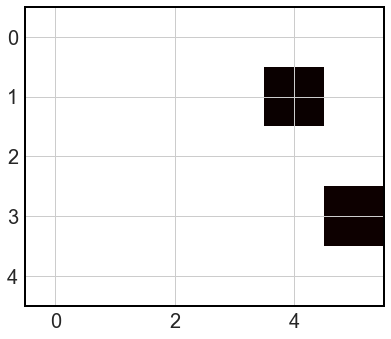

In [60]:
plt.imshow(np.ma.masked_where(mat50-mat75==0,mat50-mat75),cmap=mpl.cm.hot)

min val = 0.008166969147005444


TypeError: Dimensions of C (5, 4) are incompatible with X (4) and/or Y (10); see help(pcolormesh)

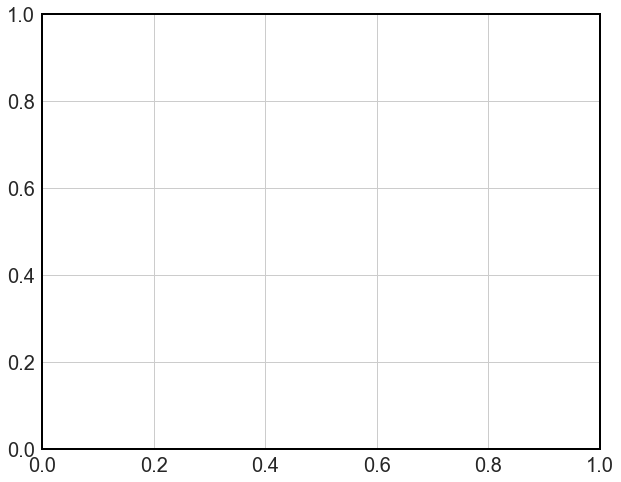

In [61]:
fig      = plt.figure(figsize=(10, 8))
ax       = plt.axes()

mat75m = np.ma.masked_where(mat75==0, mat75)

X, Y = np.meshgrid(magBins[:-1], range(7,17))  # Create a grid over the range of bins for the plot
X, Y = np.meshgrid(magBins[2:-1], range(7,17))  # Create a grid over the range of bins for the plot

print("min val = {}".format(mat75m.min()))

# im = (ax.pcolormesh(X, Y, m75m, cmap=mpl.cm.YlGnBu, vmin=-2.4, vmax=0) )
im = (ax.pcolormesh(X, Y, mat75m[:,2:], cmap=mpl.cm.YlGnBu, vmin=1e-2, vmax=1) )

ax.set_xlabel('$M_{UV,AB}$',fontsize=24)
# ax.set_xticks(magBins)
ax.set_ylabel('redshift',fontsize=24)
ax.set_yticklabels(zs+1)
ax.grid(which='major', axis='y', color='0.75', linestyle=':', linewidth=1.5)
ax.grid(which='both', axis='x', color='0.75', linestyle=':', linewidth=1.5)

# Create the colorbar
cbar = fig.colorbar(im)
cbar.ax.tick_params(labelsize=22) 
#cbar.ax.set_yticklabels(['1', '2', '4', '6', '10', maxCV], size=24)
cbar.set_label("P(>0.75)",fontsize=24)

plt.savefig("ProbvsRedshift.pdf",dpi=fig.dpi,bbox_inches='tight')


min val = 0.008166969147005444


TypeError: Dimensions of C (5, 4) are incompatible with X (4) and/or Y (10); see help(pcolormesh)

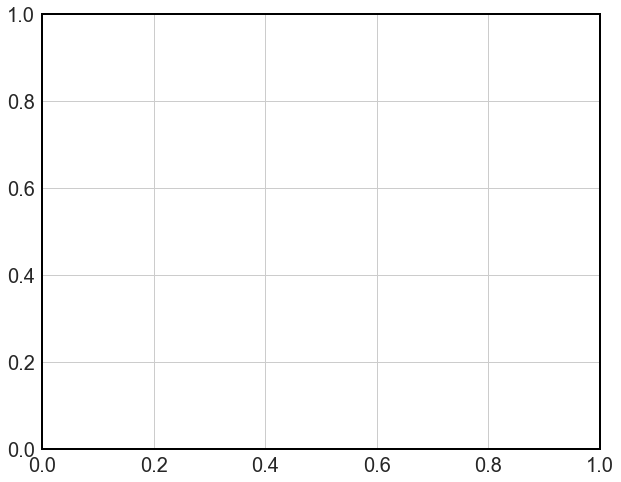

In [62]:
zs = np.arange(7,17)
fig      = plt.figure(figsize=(10, 8))
ax       = plt.axes()

mat50m = np.ma.masked_where(mat50==0, mat50)

m50m = np.log10(mat50m)
print("min val = {}".format(mat50m.min()))

X, Y = np.meshgrid(magBins[2:-1], range(7,17))  # Create a grid over the range of bins for the plot

# im = (ax.pcolormesh(X, Y, m50m, cmap=mpl.cm.YlGnBu, vmin=-2.3, vmax=0) )
im = (ax.pcolormesh(X, Y, mat50m[:,2:], cmap=mpl.cm.YlGnBu, vmin=1e-2, vmax=1) )

ax.set_xlabel('$M_{UV,AB}$',fontsize=24)
ax.set_ylabel('redshift',fontsize=24)
ax.set_yticklabels(zs+1)
ax.grid(which='major', axis='y', color='0.75', linestyle=':', linewidth=1.5)
ax.grid(which='both', axis='x', color='0.75', linestyle=':', linewidth=1.5)

# Create the colorbar
cbar = fig.colorbar(im)
cbar.ax.tick_params(labelsize=22) 
#cbar.ax.set_yticklabels(['1', '2', '4', '6', '10', maxCV], size=24)
cbar.set_label("P(>0.50)",fontsize=24)



In [ ]:
fig      = plt.figure(figsize=(10, 8))
ax       = plt.axes()

mat75m = np.ma.masked_where(mat75==0, mat75)

X, Y = np.meshgrid(magBins[:-1], range(7,17))  # Create a grid over the range of bins for the plot
X, Y = np.meshgrid(magBins[2:-1], range(7,17))  # Create a grid over the range of bins for the plot

m75m = np.log10(mat75m)
print("min val = {}".format(mat75m.min()))

# im = (ax.pcolormesh(X, Y, m75m, cmap=mpl.cm.YlGnBu, vmin=-2.4, vmax=0) )
im = (ax.pcolormesh(X, Y, mat75m[:,2:], cmap=mpl.cm.YlGnBu, vmin=1e-2, vmax=1) )

ax.set_xlabel('$M_{UV,AB}$',fontsize=24)
# ax.set_xticks(magBins)
ax.set_ylabel('redshift',fontsize=24)
ax.set_yticklabels(zs+1)
ax.grid(which='major', axis='y', color='0.75', linestyle=':', linewidth=1.5)
ax.grid(which='both', axis='x', color='0.75', linestyle=':', linewidth=1.5)

# Create the colorbar
cbar = fig.colorbar(im)
cbar.ax.tick_params(labelsize=22) 
#cbar.ax.set_yticklabels(['1', '2', '4', '6', '10', maxCV], size=24)
cbar.set_label("P(>0.75)",fontsize=24)

plt.savefig("ProbvsRedshift.pdf",dpi=fig.dpi,bbox_inches='tight')


z=8

\> 53%

['0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0017', '0.0122', '0.0137', '0.0116', '0.0166']

\> 73%

['0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0514', '0.1443', '0.1291', '0.0486', '0.0315', '0.0190']


Limiting absolute magnitude: -13
Convert to Abs Mag. DM = 47.20 @ z=8.0
Pop III flux fraction is 0.01515 at z=8
Number of galaxies 4563
Largest bin value: 0.000, smallest -2.741151598851785


/Users/earnric/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:52: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.


Convert to Abs Mag. DM = 47.38 @ z=9.0
Pop III flux fraction is 0.11445 at z=9
Number of galaxies 1468
Largest bin value: 0.000, smallest -2.6720978579357175
Convert to Abs Mag. DM = 47.54 @ z=10.0
Pop III flux fraction is 0.05494 at z=10
Number of galaxies 1021
Largest bin value: 0.000, smallest -2.54282542695918
Convert to Abs Mag. DM = 47.68 @ z=11.0
Pop III flux fraction is 0.07623 at z=11
Number of galaxies 687
Largest bin value: 0.000, smallest -2.367355921026019
Convert to Abs Mag. DM = 47.80 @ z=12.0
Pop III flux fraction is 0.14715 at z=12
Number of galaxies 451
Largest bin value: 0.000, smallest -2.1986570869544226
Convert to Abs Mag. DM = 48.03 @ z=14.0
Pop III flux fraction is 0.26543 at z=14
Number of galaxies 174
Largest bin value: -0.176, smallest -1.662757831681574
Convert to Abs Mag. DM = 48.12 @ z=15.0
Pop III flux fraction is 0.31926 at z=15
Number of galaxies 94
Largest bin value: 0.000, smallest -1.4471580313422192
Convert to Abs Mag. DM = 48.21 @ z=16.0
Pop III fl

16089

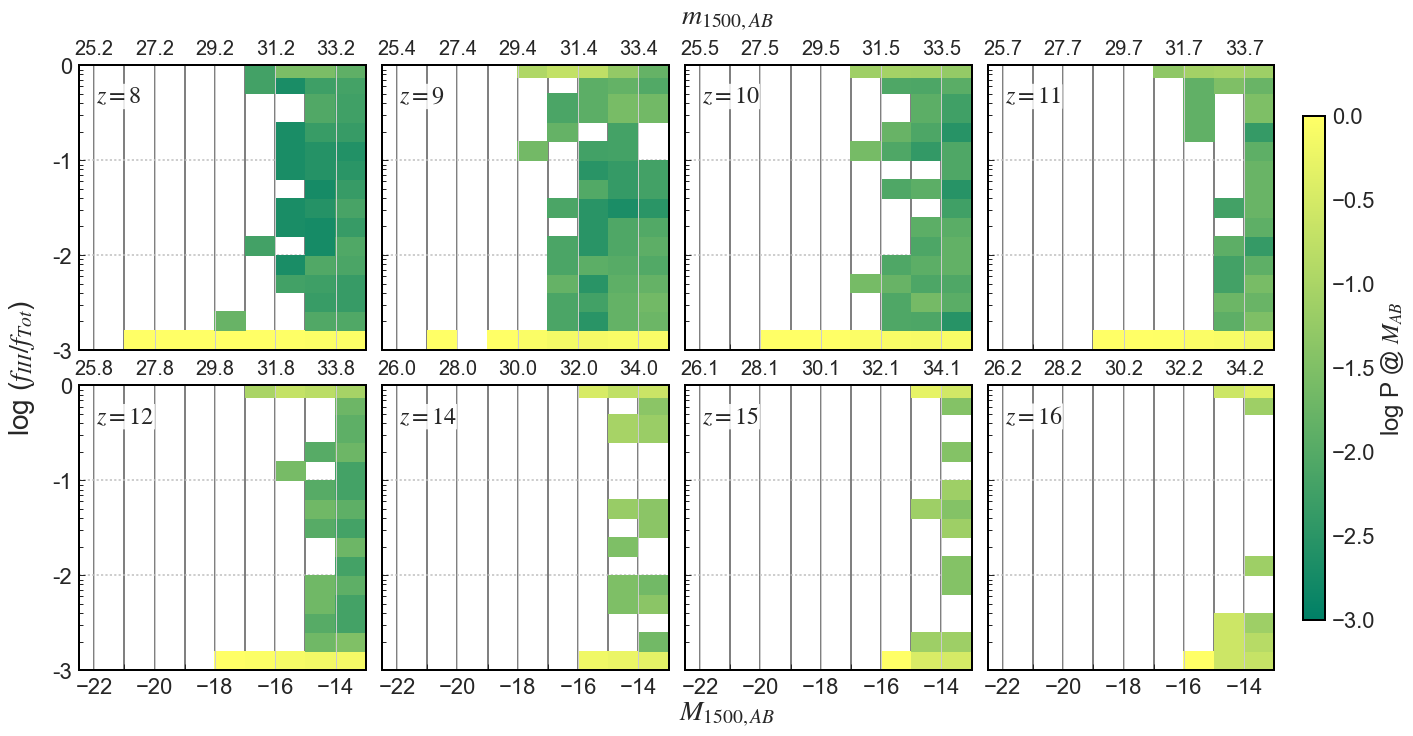

In [63]:
# Normalize the probability in each row such that it totals to 1.0

sns.set(style="whitegrid", font_scale=2, color_codes=True)
sns.set_style({'axes.edgecolor': '0.0','axes.linewidth': 2.0})

# Plot the fraction of Pop III magnitude vs M_AB NORMALIZED...

rgForSFunc = np.arange(brightM,limitM, 0.1)

brightM = -22
limitM  = brightM+9
magBins = np.linspace(brightM,limitM,(-brightM+limitM)*1 + 1) 
# Contrived bin spacing such that the top bin represents .75-1.0 Pop III fraction
# and the next bin down represents .5-0.75 ...
fracBins = [0.001,  0.00158489,  0.00251189,  0.00398107,  0.00630957,
             0.01,  0.01584893,  0.02511886,  0.03981072,  0.06309573,
             0.1,  0.15848932,  0.25118864,
             0.5,   0.75,   1.0]
print("Limiting absolute magnitude: {}".format(limitM))

fig, axs = plt.subplots(nrows=2, ncols=4, sharex='col',sharey='row',figsize=(20,10))
for z,ax in zip(np.sort([8,9,10,11,12,14,15,16]), axs.flat):

    # Convert observed magnitude to Absolute ...
    absMag, pop3Mag, nmAbsMag   = compMags(z)
    # Map 0 Pop 3 flux to 1e-3... 
    pop3Fraction                      = haloData[dir][z]['1500A_P3']/haloData[dir][z]['1500A']
    print("Pop III flux fraction is {:.5f} at z={}".format(haloData[dir][z]['1500A_P3'].sum()/haloData[dir][z]['1500A'].sum(),z))
    pop3Fraction[pop3Fraction < 1e-3] = 1e-3  # Map Pop 3 flux < 1e-3 to 1e-3
    

    
    Ng = len(absMag) # Number of galaxies at this z
    print("Number of galaxies {}".format(Ng))
    # GENERATE THE HISTOGRAM and HISTOGRAM DATA in the array 'n' for
    # both the improved Pop III luminosity and the classical

    # Note that we are reversing x,y here since pcolormesh interprets them backwards!
    nTempA, binsx, binsy = np.histogram2d(pop3Fraction,absMag,bins=[fracBins,magBins],normed=False)
    # could use weights=[1/simVol for i in absMag] to normalize by vol here... 
    # normed : bool, optional
    #        If False, returns the number of samples in each bin. If True, returns the bin density 
    #        bin_count / sample_count / bin_area.

    X, Y = np.meshgrid(magBins, fracBins)  # Create a grid over the range of bins for the plot

    # Mask out 0 values before taking log10... 
    H = np.ma.masked_where(nTempA==0.0, nTempA)
    for i in range(len(H[0,:])):     # Column index i, over len of row 0
        colTot = np.sum(H[:,i])
        for j in range(len(H[:,0])): # Row index j, over len of column 0
            H[:,i][j] = H[:,i][j]/colTot
    H = np.log10(H)        # Take log of counts, we've already normalized by volume and area
    print("Largest bin value: {:.3f}, smallest {}".format(H.max(),H.min()))
    # Create the plot
    im = (ax.pcolormesh(X, Y, H, cmap=mpl.cm.summer, vmin=-3, vmax=0) )
    
    ax.set_xscale('linear')
    ax.set_yscale('log')
    ax.yaxis.set_tick_params(which='major',width=1,length=6)
    ax.yaxis.set_tick_params(which='minor',width=1,length=4)
    ax.xaxis.set_tick_params(which='both',width=1,length=6)
    ax.xaxis.set_ticks(np.arange(brightM,limitM+1, 2))
    minorLocator = ticker.MultipleLocator(1)
    ax.xaxis.set_minor_locator(minorLocator)
    ax.get_yaxis().set_tick_params(which='both', direction='in',labelsize=22)
    ax.get_xaxis().set_tick_params(which='both', direction='in',labelsize=22)
    ax.yaxis.set_major_formatter(logfmt)
    ax.set_xlim([brightM-0.5,limitM])
#     ax.set_ylim([9e-4,1.05])
    ax.grid(which='major', axis='y', color='0.75', linestyle=':', linewidth=1.5)
    ax.grid(which='both', axis='x', color='0.5', linestyle='-', linewidth=2.0)

    # Top x-axis labels ... m_ab
    ax2 = ax.twiny()
    ax2.set_xlim([brightM-0.5,limitM]) # required...
    axXtics = ax.get_xticks()
    ax2.set_xticks(axXtics)   # Set the location of the tics same as for ax
    ax2Xs = getMag(axXtics,z) # Convert M_ab -> m_ab
    ax2.set_xticklabels(["{:.1f}".format(i) for i in ax2Xs])
    ax2.get_xaxis().set_tick_params(labelsize=20)

    # plt.gca().invert_xaxis()
    gc.collect()
    
    ax.annotate('$z={}$'.format(z), xy = (0.5, 0.5), xytext = (0.06, 0.85), xycoords='axes fraction',
                bbox = {'boxstyle': 'round,pad=0.05', 'fc': 'w', 'ec': 'None', 'alpha': 0.85},
                textcoords = 'axes fraction', ha = 'left', va = 'bottom',fontsize=24)

plt.subplots_adjust(left=0.05, bottom=0.08, right=.88, top=0.92, wspace=.057, hspace=.125)

fig.text(0.5, 0.977,'$m_{1500,AB}$', ha='center',size=28 )
fig.text(0.5, 0.01,'$M_{1500,AB}$', ha='center',size=28 )
fig.text(0.00, 0.5, r'log ($f_{III}/f_{Tot}$)',size=28,va='center', rotation='vertical')

# Create the colorbar
cbar_ax = fig.add_axes([0.9, 0.15, 0.015, 0.7])
cbar = fig.colorbar(im, cax=cbar_ax)

cbar.ax.tick_params(labelsize=22) 
#cbar.ax.set_yticklabels(['1', '2', '4', '6', '10', maxCV], size=24)
cbar.set_label("log P @ $M_{AB}$",fontsize=24)
#plt.savefig("PopIII_fraction_{}-Histograms-all.pdf".format(z),dpi=fig.dpi,bbox_inches='tight')

gc.collect()

### Build tables showing f_III/f_tot = f(z,M_AB)

In [64]:
# Normalize the probability in each row such that it totals to 1.0

brightM = 25
limitM  = 37
rgForSFunc = np.arange(brightM,limitM, 0.1)

magBins = np.linspace(brightM,limitM,(-brightM+limitM)*1 + 1) 
fracBins = np.logspace(-3,0,23)
# Contrived bin spacing such that the top bin represents .75-1.0 Pop III fraction
# and the next bin down represents .5-0.75 ...
fracBins = [0.001,  0.00158489,  0.00251189,  0.00398107,  0.00630957,
             0.01,  0.01584893,  0.02511886,  0.03981072,  0.06309573,
             0.1,  0.15848932,  0.25118864,
             0.5,   0.75,   1.0]
print(["{}".format(i) for i in magBins])

headers = np.concatenate(([['z'],magBins[1:]]))
dfom75 = pd.DataFrame( columns=headers)
dfom50 = pd.DataFrame( columns=headers)

matom75 = np.array([])
matom50 = np.array([])
ii = 0;
for z in np.sort([8,9,10,11,12,13,14,15,16]):

    # Convert flux to m ...
    mags = mag(haloData[dir][z]['1500A'])
    # Map 0 Pop 3 flux to 1e-3... 
    pop3Fraction                      = haloData[dir][z]['1500A_P3']/haloData[dir][z]['1500A']
    pop3Fraction[pop3Fraction < 1e-3] = 1e-3  # Map Pop 3 flux < 1e-3 to 1e-3
    
    Ng = len(mags) # Number of galaxies at this z
    # GENERATE THE HISTOGRAM and HISTOGRAM DATA in the array 'n' for
    # both the improved Pop III luminosity and the classical

    # Note that we are reversing x,y here since pcolormesh interprets them backwards!
    nTempA, binsx, binsy = np.histogram2d(pop3Fraction,mags,bins=[fracBins,magBins],normed=False)
    # could use weights=[1/simVol for i in mags] to normalize by vol here... 
    # normed : bool, optional
    #        If False, returns the number of samples in each bin. If True, returns the bin density 
    #        bin_count / sample_count / bin_area.


    # Mask out 0 values before taking log10... 
    H = np.ma.masked_where(nTempA==0.0, nTempA)
#     H = np.ma.masked_where(nTempA<=1.0, nTempA)
    if z==15:
        print("counts",H[-1,:])
        print("counts\n",H)
    for i in range(len(H[0,:])):     # Column index i, over len of row 0
        colTot = np.sum(H[:,i])
        for j in range(len(H[:,0])): # Row index j, over len of column 0
            H[:,i][j] = H[:,i][j]/colTot  ## IF colTot == 1 or 2, we likely have very bad statistics **************
    # Create arrays where fraction is greater than 50% and 75% ... 
    # REMEMBER: have to add the 75% bin to the 50% if we want combined P(>.50)
#     H = np.ma.filled(H, fill_value=0.0)
    if z==15:
        print("prob",H[-1,:])
    #########################################################################
    ##### Extract the "top two" rows ... these are bins 50% and 75% #########
    ##### if you change fracBins this changes!!!! ***************************
    #########################################################################
    gtom50 = H[-2,:]
    gtom75 = H[-1,:]
#     print("z={}, H (> 75%): \n{}".format(z,["{:.4f}".format(x) for x in gtom75]))
    dfom75.loc[ii] = np.concatenate(([z],gtom75))
    dfom50.loc[ii] = np.concatenate(([z],gtom50+gtom75)) ## Sum the fraction > .75 and .50 < frac < .75
    if z == 8: # first one
#         print(gtom75)
        # Build a new matrix with P3 frac vs M_AB 
        matom75 = np.append(matom75,gtom75)
        matom50 = np.append(matom50,gtom50+gtom75)
    else:
        matom75 = np.vstack((matom75,gtom75)) # A matrix (for plotting) of the table
        matom50 = np.vstack((matom50,gtom50+gtom75)) # a matrix of the table... 
    ii += 1
gc.collect()
# df75.index = range(8,16)
# df50.index = range(8,16)
print("> 75 and 50% respectively")
print (dfom75.to_string(index=False))
print (dfom50.to_string(index=False))


['25.0', '26.0', '27.0', '28.0', '29.0', '30.0', '31.0', '32.0', '33.0', '34.0', '35.0', '36.0', '37.0']


/Users/earnric/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:53: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.


KeyError: 13

In [65]:
H[-2,:],H[-1,:],magBins

(masked_array(data = [-- -- -- -- -- -- -- -- 0.009174311926605505 0.024844720496894408 0.015151515151515152 --],
              mask = [ True  True  True  True  True  True  True  True False False False  True],
        fill_value = 1e+20),
 masked_array(data = [-- -- -- -- -- -- 0.18181818181818182 0.1836734693877551 0.13761467889908258 0.09316770186335403 0.030303030303030304
  0.03571428571428571],
              mask = [ True  True  True  True  True  True False False False False False False],
        fill_value = 1e+20),
 array([ 25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,  33.,  34.,  35.,  36.,  37.]))

In [66]:
z15mags=mag(fluxes[15]['1500A']) ### Check out that 100% at z=15, m=31
pop3Fraction                      = fluxes[15]['1500A_P3']/fluxes[15]['1500A']
pop3Fraction[pop3Fraction < 1e-3] = 1e-3  # Map Pop 3 flux < 1e-3 to 1e-3
print("mags",z15mags[(z15mags<31.5)&(z15mags>30.5)])
print("ff",pop3Fraction[(z15mags<31.5)&(z15mags>30.5)])

mags []
ff []


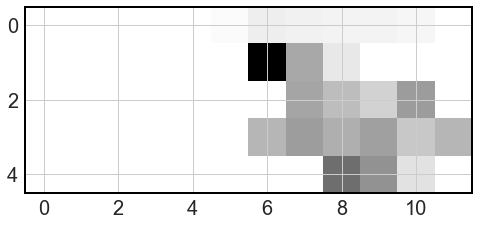

In [67]:
cm = sns.light_palette("green", as_cmap=True)
plt.imshow(matom50)
s2 = dfom75.style.background_gradient(cmap=cm)
s2.set_caption('$m_{UV,AB}$')

In [68]:
#dfom50.style.set_caption('$m_{UV,AB}$').background_gradient(cmap=cm)
dfom50.style.background_gradient(cmap=cm)

In [69]:
len(magBins[:-1]),len(mom75m[:,0]),len(mom75m[0,:])

NameError: name 'mom75m' is not defined

max val = 0.21755725190839695
min val = 0.0033112582781456954


TypeError: Dimensions of C (5, 7) are incompatible with X (8) and/or Y (10); see help(pcolormesh)

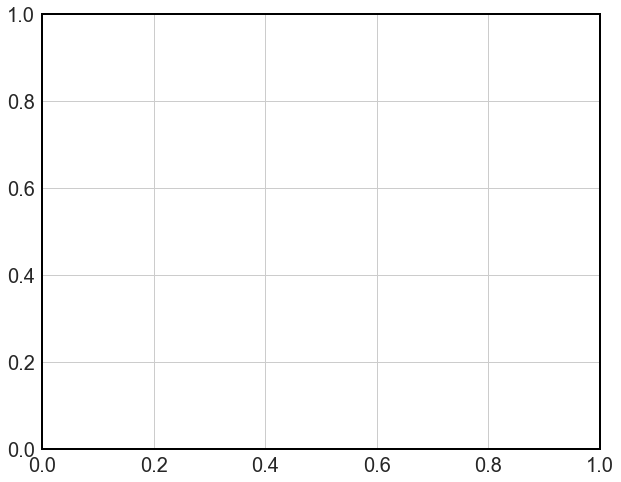

In [70]:
zs = np.arange(7,17)

fig      = plt.figure(figsize=(10, 8))
ax       = plt.axes()

matom75m = np.ma.masked_where(matom75==0, matom75)

X, Y = np.meshgrid(magBins[2:-3], zs)  # Create a grid over the range of bins for the plot

# mom75m = np.log10(matom75m)
print("max val = {}".format(matom75m.max()))
print("min val = {}".format(matom75m.min()))

# im = (ax.pcolormesh(X, Y, m75m, cmap=mpl.cm.YlGnBu, vmin=-2.4, vmax=0) )
im = (ax.pcolormesh(X, Y, matom75m[:,2:-3], cmap=mpl.cm.YlGnBu, vmin=2e-3, vmax=1) )

ax.set_xlabel('$m_{UV,AB}$',fontsize=24)
# ax.set_xticks(magBins)
ax.set_ylabel('redshift',fontsize=24)
ax.set_yticklabels(zs+1)
ax.grid(which='major', axis='y', color='0.75', linestyle=':', linewidth=1.5)
ax.grid(which='both', axis='x', color='0.75', linestyle=':', linewidth=1.5)

# Create the colorbar
cbar = fig.colorbar(im)
cbar.ax.tick_params(labelsize=22) 
#cbar.ax.set_yticklabels(['1', '2', '4', '6', '10', maxCV], size=24)
cbar.set_label("P(>0.75)",fontsize=24)

plt.savefig("ProbvsRedshiftObsMag.pdf",dpi=fig.dpi,bbox_inches='tight')


In [158]:
mom75m[:,4:]

masked_array(data =
 [[-- -- -2.682145076373832 -1.9088678258509035 -1.8066175503250896 -1.8370752510408843 -1.756192206422384
  -1.7898370087088382]
 [-1.8789046024734604 -1.9388948175981704 -1.5590775548220595 -2.0601580087341946 -2.423245873936808 -- -- --]
 [-- -2.173186268412274 -1.5902071645329623 -1.6925531793391444 -2.2840545584360687 -2.5010592622177517
  -1.9319661147281726 --]
 [-- -- -1.6989700043360187 -1.8796692056320534 -1.5893480258118247 -1.9375178920173466 -1.919078092376074
  -1.7481880270062005]
 [-- -1.5440680443502757 -1.8228216453031045 -1.3089573640660823 -1.6478174818886375 -- -2.0293837776852097 --]
 [-- -- -- -2.143014800254095 -1.8409420802430991 -1.649334858712142 -1.348953547981164 -1.1583624920952496]
 [-- -- -- -1.5910646070264993 -1.8325089127062364 -1.7745169657285496 -1.3710678622717363 -1.1249387366083]
 [-- -- -- -- -1.5314789170422551 -1.2937307569224816 -1.462397997898956 --]
 [-- -- -- -- -1.5563025007672873 -1.1856365769619117 -- -0.865301426102

In [21]:
fluxes[10].dtype.names

('halo',
 'r_v',
 'ZZsun',
 'ZPZsun',
 'MstarMsun',
 'M3StarMsun',
 'M3YngMsun',
 '1500A',
 '1500A_P3',
 '1500A_NM',
 '1500A_P3NM',
 '1500A_10pc',
 '1500A_P3_10pc')